<a href="https://colab.research.google.com/github/ancastillar/A-high-bias-low-variance-introduction-to-Machine-Learning-for-physicists.-/blob/main/ISF_PYME_FINAL_Balanceo_XGBOOST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  📈 Fase de Modelado


**Personas encargadas del modelo: Andrés Felipe Hoyos Marín, Astrid Natalia Castilla Reyes** 

**Departamento de Modelos y metodologías de Riesgo de crédito**


# 📑 Fuentes de datos

Actualmente se está empleando una única fuente de datos:

*  T_Kobra_Empresas.  Ubicada en el SQL de Cobranzas. 

# 📝 Modelos implementados

Debido a la dimensión de nuestra fuente de datos y a la posible colinealidad de las variables el primer modelo que se prueba es un **XGBOOST**, el cual es un algortimo rápido y eficiente. Adicionalmente, nos retorna la probabilidad de pago de cada cliente. 

* En total son 15 modelos, 5 para cada uno de los tres Subsegmentos de Pyme:  **Pyme Pequeña**, **Mi Pyme**, **Pyme Grande**.

* Para cada uno de los subsegmentos mencionados anteriormente, se crean 5 modelos. Cada modelo representa la altura de mora de la **Obligación**.

* Adicionalmente, debido a desbalanceo de los datos en cada subsegmento se emplea el algoritmo SMOTE, el cual crea una muestra artificial de la clase con menor datos. Esta muestra artificial se crea a partir de un algoritmo de similaridad, es decir para cada punto el algoritmo selecciona sus vecinos más cercanos y  partir de la similaridad encontrada crea el nuevo artificial.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!pip install shap

     |████████████████████████████████| 358kB 6.9MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491621 sha256=f365ca2ffc62853165512c6e200b3896f6c282361743661e30e10a0a2fa0b364
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


In [2]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.utils import shuffle

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from scipy.stats import boxcox

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)



import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import scipy.stats as st
from scipy.stats import skew
from sklearn.preprocessing import RobustScaler, StandardScaler
import regex as re
import csv

from sklearn.model_selection import train_test_split
from scipy.stats import chi2_contingency
import scipy.stats as stats
from scipy.stats.contingency import expected_freq
from scipy.stats import power_divergence, pearsonr
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.metrics import roc_curve ,log_loss, auc, f1_score, accuracy_score, mean_squared_error, mean_squared_log_error, recall_score, precision_score
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
sns.set_context("talk")

from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import plot_importance
from sklearn.metrics import precision_recall_curve
import pickle
import random
import shap
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin,RegressorMixin, clone

import statsmodels.api as sm

# Gráficos
# ==============================================================================

import matplotlib.font_manager
from matplotlib import style
style.use('ggplot') or plt.style.use('ggplot')

# Preprocesado y modelado
# ==============================================================================
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline


pd.options.display.max_columns = 400
seed= 42
ruta = "/content/drive/MyDrive/ISF_LAURA/otro_balanceo"

**Funciones globales del modelo**

In [3]:
#@title Función de métricas


def downcast(df):
  
    """ Esta función nos permite adecuar el tipo de datos que estamos empleando de tal manera que podamos 
        liberar memoria"""

    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()
    for i,t in enumerate(types):
        if 'int' in str(t):
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)
        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)
        elif t == np.object:
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
            else:
                df[cols[i]] = df[cols[i]].astype('category')
    return df  





def evalBinaryClassifier(clf, x, y, labels=['Positives','Negatives']):
   
    #predicciones del modelo
    p = clf.predict_proba(x)
    pos_p = p[:,1]
    pos_p0 = p[:,0]
    
    
    plt.figure(figsize=[21,5])
    
    #1 -- Matriz de confusión
    cm = confusion_matrix(y,clf.predict(x))
    plt.subplot(131)
    ax = sns.heatmap(cm, annot=True, cmap='Blues', cbar=False, 
                annot_kws={"size": 14}, fmt='g')
    cmlabels = ['Verdaderos Negativos', 'Falsos Positivos',
              'Falsos Negativos', 'Verdaderos Positivos']
    for i,t in enumerate(ax.texts):
        t.set_text(t.get_text() + "\n" + cmlabels[i])
    plt.title('Matriz de confusión', size=15)
    plt.xlabel('Valores estimados', size=13)
    plt.ylabel('Valores verdaderos', size=13)
      
    #2 -- Distribución de probabilidades de las dos clases
    df = pd.DataFrame({'probPos':pos_p, 'target': y.values.flatten()})
    plt.subplot(132)
    plt.hist(df[df.target==1].probPos, density=True, bins=25,
             alpha=.5, color='green',  label=labels[0])
    plt.hist(df[df.target==0].probPos, density=True, bins=25,
             alpha=.5, color='red', label=labels[1])
    plt.axvline(.5, color='blue', linestyle='--', label='Boundary')
    plt.xlim([0,1])
    plt.title('Distribución de las predicciones', size=15)
    plt.xlabel('Probabilidad positiva (estimada)', size=13)
    plt.ylabel('Muestras (escala normal)', size=13)
    plt.legend(loc="upper right")

    #3 -- Curva Roc

    fp_rates, tp_rates, _ = roc_curve(y,p[:,1])
    roc_auc = auc(fp_rates, tp_rates)
    plt.subplot(133)
    plt.plot(fp_rates, tp_rates, color='green',
             lw=1, label='Curva ROC (área (AUC) = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], lw=1, linestyle='--', color='grey')
    #plot current decision point:
    tn, fp, fn, tp = [i for i in cm.ravel()]
    plt.plot(fp/(fp+tn), tp/(tp+fn), 'bo', markersize=8, label='Punto de decisión')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Ratio de Falsos Positivos', size=13)
    plt.ylabel('Ratio Verdaderos positivos ', size=13)
    plt.title('Curva ROC', size=15)
    plt.legend(loc="lower right")
    plt.subplots_adjust(wspace=.3)
    plt.show()


def print_score(clf, X_train, y_train, X_test, y_test, train=True, valid=False):
    if (train) & (valid==False):
        print("Resultados Entrenamiento:\n")
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_train, clf.predict(X_train))))
        print("Reporte de clasificación: \n {}\n".format(classification_report(y_train, clf.predict(X_train))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_train, clf.predict(X_train))))
        print("ROC_AUC \n{}\n".format(roc_auc_score(y_train, clf.predict(X_train))))
        print("F1-score \n{}\n".format(f1_score(y_train, clf.predict(X_train))))
        print("Recall \n{}\n".format(recall_score(y_train, clf.predict(X_train))))
        print("Presicion \n{}\n".format(precision_score(y_train, clf.predict(X_train))))
        #print("Log_loss \n{}\n".format(log_loss(y_train, clf.predict(X_train))))
        #res = cross_val_score(clf, X_train, y_train, cv=5, scoring='f1')
        #print("Average AUC CV: \t {0:.4f}".format(np.mean(res)))
        #print("AUC CV SD: \t\t {0:.4f}".format(np.std(res)))   
    
        
    elif (train==False) & (valid==False):
        
        print("Resultados Prueba:\n")        
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_test, clf.predict(X_test))))
        print("Reporte de Clasificación: \n {}\n".format(classification_report(y_test, clf.predict(X_test))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_test, clf.predict(X_test))))
        print("RMSE \n{}\n".format(np.sqrt(mean_squared_error(y_test, clf.predict(X_test)))))
        print("MSLE \n{}\n".format(mean_squared_log_error(y_test, clf.predict(X_test))))
        print("ROC_AUC \n{}\n".format(roc_auc_score(y_test, clf.predict(X_test))))
        print("F1-score \n{}\n".format(f1_score(y_test, clf.predict(X_test))))
        print("Recall \n{}\n".format(recall_score(y_test, clf.predict(X_test))))
        print("Presicion \n{}\n".format(precision_score(y_test, clf.predict(X_test))))
        #print("Log_loss \n{}\n".format(log_loss(y_test, clf.predict(X_test))))
       
    
    if (valid==True) & ((train==True) | (train==False)):
        print("Resultados de validación:\n")        
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_test, clf.predict(X_test))))
        print("Reporte de clasificación: \n {}\n".format(classification_report(y_test, clf.predict(X_test))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_test, clf.predict(X_test))))
        print("RMSE \n{}\n".format(np.sqrt(mean_squared_error(y_test, clf.predict(X_test)))))
        print("MSLE \n{}\n".format(mean_squared_log_error(y_test, clf.predict(X_test))))
        #print("ROC_AUC \n{}\n".format(roc_auc_score(y_test, clf.predict(X_test))))
        print("F1-score \n{}\n".format(f1_score(y_test, clf.predict(X_test))))
        print("Recall \n{}\n".format(recall_score(y_test, clf.predict(X_test))))
        print("Presicion \n{}\n".format(precision_score(y_test, clf.predict(X_test))))
        #print("Log_loss \n{}\n".format(log_loss(y_test, clf.predict(X_test))))

In [4]:
#@title Modelo Xgboost
def model_xgboost(X_train, y_train, X_test, y_test, weight, n_estimators=100, objective='binary:logistic', grid_hiper=False):
  

  if grid_hiper==False:
        

        eval_set = [(X_train, y_train), (X_test, y_test)]
        model = XGBClassifier(n_estimators = n_estimators, objective= objective, reg_lambda= 1,alpha=1, eval_metric=["error", "logloss"], early_stopping_rounds=20 )
        model.fit(X_train, y_train,eval_set=eval_set)
        return model


  else:
    # A parameter grid for XGBoost

      params = {
            'min_child_weight': [2,3,4,6,12,15,5, 10,13, 8, 7,16],
            'gamma': [8, 10, 15, 17],
            'sampling_method':['gradient_based','uniform'],
            'subsample': [0.6, 0.8, 0.95,0.4,0.7,0.9,0.5],
            'colsample_bytree': [0.6, 0.2, 0.3, 0.8, 0.4, 0.5, 0.95],
            'max_depth': [ 2,3, 4, 5, 7,8,9,10,6],
            'eta': [0.05, 0.1,0.2,0.3,0.35, 0.4,0.25],
            'reg_alpha': [18,25,22, 19,20,22, 25],
            'reg_lambda' : [ 15, 12,16,17,18,20,22,25],
            'max_delta_step' : [6,8,10, 14,16,7,9,13],
            'n_estimators' : [150,75,120,200,250,300],
            'objective': ['binary:logistic'],
           
            }
      folds = 4
      param_comb = 5
      eval_set = [(X_train, y_train), (X_test, y_test)]
      model = XGBClassifier(eval_metric=["error", "logloss"] )
      skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

      random_search = RandomizedSearchCV(model, param_distributions=params, n_iter=param_comb, scoring='f1', n_jobs=4, cv=skf.split(X_train,y_train), verbose=3, random_state=1001 )

        # Here we go
    
      random_search.fit(X_train, y_train)
      
      eval_set = [(X_train, y_train), (X_test, y_test)]
      model = XGBClassifier(**random_search.best_params_,eval_metric=["error", "logloss"], scale_pos_weight= weight,  early_stopping_rounds=10)
      model.fit(X_train, y_train,eval_set=eval_set)

      return model


**Entrenamos hasta diciembre y probamos hasta Enero**

In [5]:
df= pd.read_parquet(ruta+"/train_todo.parquet")
df = df[df.mes_inicial!=15]
df['PAGOS'] = df['PAGOS'].fillna(0)

In [6]:
df_et= df[  (df.mes_inicial!=14) & (df.mes_inicial!=13)] 
df.loc[df['mes_inicial']== 13, 'PAGOS'] = 0
df= df[df.mes_inicial!=14]
#df.loc[df['mes_inicial']== 14, 'PAGOS'] = 0

*Para Febrero*

In [ ]:
df.loc[df['mes_inicial']== 14, 'PAGOS'] = 0

**Creación de la variable de retraso de pagos**

In [7]:
#Lag de la variable pagos para el train

def lags_pagos_df(df0):

  lag_list = [1, 2, 3,4]

  for lag in lag_list:
  
    ft_name = ('PAGOS%s' % lag)
    
    df0[ft_name] = df0.sort_values('mes_inicial', ascending=True).groupby(['OBLIGACION'])['PAGOS'].shift(lag)
  
    df0[ft_name].fillna(0, inplace=True)
  
  return df0

In [8]:
df_train = lags_pagos_df(df_et)
df_test = lags_pagos_df(df)
df_test = df_test[(df_test.mes_inicial==13)] ## Cambiar por el mes de interés
df = pd.concat([df_train, df_test])

**Para Ejecutar Febrero**

In [ ]:
df_test = lags_pagos_df(df)

#######Para Febrero
df = df_test

In [9]:
#@title Eliminación de algunas variables que contienen información repetida

a= [ 'ID_INTENSIDAD', 'RXE1_G_max', 'NO_VIRTUAL_CL_MENS_DISMINUYO',	'NO_VIRTUAL_CL_MENS_AUMENTO',	'NO_SMS_CL_MENS_DISMINUYO','NO_SMS_Cl_MENS_AUMENTO','NO_DIRECTO_CL_MENS_DISMINUYO',
       'NO_DIRECTO_CL_MENS_AUMENTO',	'NO_LLAMADAS_EFECTIVAS_CL_MENS_DISMINUYO',	'NO_LLAMADAS_EFECTIVAS_CL_MENS_AUMENTO_OBL'	,
       'EXM1_G_max','IDEJECUTIVO',	'IDASIGNADO', 'DMORA1', 'AÑO_CASTIGO','ratio_dia_mora_cl_mens_id',	'ratio_dmora_mensual',
       'RXM1_G_max', 'CIA_INICIAL_G_max', 'cliente_castigado','cantidad_transacciones_cl', 'cantidad_transacciones_obl',
       'cantidad_rxe1_obl', 'cantidad_rxe1_cl','DMORA1_MEAN_CL', 'CANT_AL_DIA_SUM_CL',  'CANT_MORA_IND_SUM_CL','SALDO_EMPRESA_MEAN_CL', 'PERIODOS_DE_GRACIAS_CL',
       'NRO_REESTRUCTURACIONES_CL', 'pagos_cl', 'ratio_mora_obl_cl',
       'ratio_dia_obl_cl', 'ratio_mora_clo', 'ratio_dia_clo', 'pagos_cl_mens','pesos_pd','ratio_pagos_mensual',
       'prob_estado_rxe1_obl', 'prob_estado_rxe1_cl', 'SALDO_C_DISMINUYO_OBL',
       'SALDO_C_AUMENTO_OBL', 'DMORA_DISMINUYO_OBL', 'DMORA_AUMENTO_OBL',
       'NO_MARCACIONES_DISMINUYO_OBL', 'NO_MARCACIONES_AUMENTO_OBL',
       'NO_VIRTUAL_DISMINUYO_OBL', 'NO_VIRTUAL_AUMENTO_OBL',
       'NO_SMS_DISMINUYO_OBL', 'NO_SMS_AUMENTO_OBL',
       'NO_DIRECTO_DISMINUYO_OBL', 'NO_DIRECTO_AUMENTO_OBL',
       'NO_LLAMADAS_EFECTIVAS_DISMINUYO_OBL',
       'NO_LLAMADAS_EFECTIVAS_AUMENTO_OBL',
       'SALDO_CAPITAL_CL_EMPRESAS_DISMINUYO',
       'SALDO_CAPITAL_CL_EMPRESAS_AUMENTO', 'DMORA1_MEAN_CL_MENS_DISMINUYO',
       'DMORA1_MEAN_CL_MENS_AUMENTO', 'NO_MARCACIONES_CL_MENS_DISMINUYO',
       'NO_MARCACIONES_CL_MENS_AUMENTO',
       'FECHA_INICIAL','RXM1', 'TASA_ACTUAL','RANGO_VENTAS','RXM_MIN', 'RXM_MAX',
       'SALDO_CAPITAL_CL_EMPRESAS_BANCO', 'RANGO_CAPITAL_CL_EMPRESAS_TOTAL','ID_REEST',
       'No_LLAMADAS_EFECTIVAS', 'No_RETORNOS', 'No_VISITAS_EFECTIVAS',
       'No_VISITAS_TOTAL', 'No_SMS', 'No_EMAIL', 'No_IVR', 'No_WHAT','No_MARCACIONES', 
       'No_CARTA', 'CANT_AL_DIA_SUM_OBL' ,'CANT_MORA_IND_SUM_OBL' ,'CANT_IMPRODUCTIVO_IND_SUM_OBL','SALDO_CAPITAL_PD_MEAN_OBL',
       'No_VIRTUAL','SALDO_CAPITAL_PD','SALDO_CAPITAL_CL_EMPRESAS_TOTAL','SALDO_INTENSIDAD','DMORA1_MEAN_CL_MENS', 'SALDO_PROMETIDO', 'No_DIRECTO', 'SALDO_CASTIGADO_INICIAL','CIA_INICIAL_G_max', 'pagos_cl', 'pagos_cl_mens', 'ratio_pagos_mensual', 'CIA_INICIAL_MIN','CIA_INICIAL_MAX', ]

df = df.drop(a, axis=1)

In [ ]:
df.to_parquet(ruta+'/febrero_test.parquet')

**Segmentación la población de clientes según la variable EXM1, la cual da la altura de mora del cliente respecto a todo el portafolio**

In [10]:
df = df[(df.EXM1!=0)  & (df.CIA_INICIAL!=9)]
df= df.sort_values(by=['OBLIGACION', 'mes_inicial'], ascending=True)
df = df.drop(['PAGOS'],axis=1)

In [12]:
#Visualización de la volumetría de datos para cada subsegmento
df.SUBSEGMENTO.value_counts()

MiPyme          126725
Pyme Pequeña     83573
Pyme Grande      35977
Name: SUBSEGMENTO, dtype: int64

#Modelo XGboost Para MiPyme.

El subsegmento Mi Pyme es obtenido mediante la variable *SUBSEGMENTO* de la base de datos de T_kobra. A continuación también podemos observar la volumetría de los datos disponibles para modelar. Este segmento es el más grande de los tres estudiados. Esta volumetría hace parte de la recolección de datos entre las fechas (Junio 2020- Enero 2021)

Text(0, 0.5, 'Cantidad')

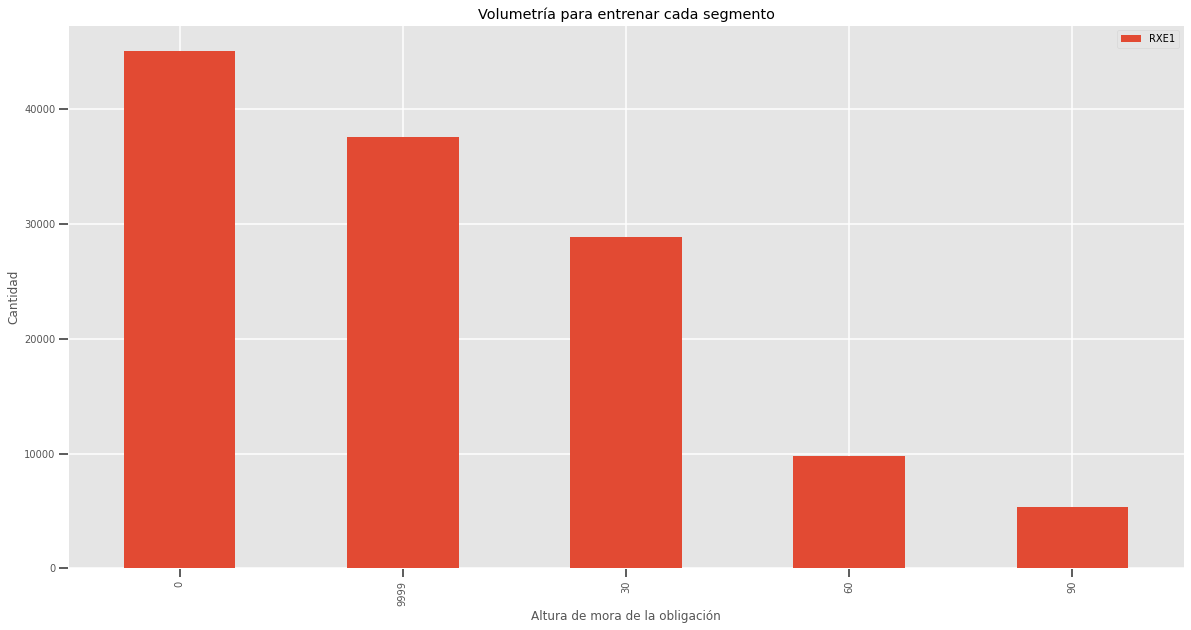

In [ ]:
pd.DataFrame(df[(df.SUBSEGMENTO=='MiPyme')].RXE1.value_counts()).plot(kind='bar')
plt.title('Volumetría para entrenar cada segmento')
plt.xlabel('Altura de mora de la obligación')
plt.ylabel('Cantidad')

**Modelo para MiPyme RXE1==0**
--------------------------------------------

In [ ]:
#@title Segmentación Pyme : MiPyme 0
df_train = df[(df.SUBSEGMENTO=='MiPyme') & (df.RXE1==0)]

df_train = df_train.drop(['SUBSEGMENTO', 'RXE1'],axis=1)
df_train = pd.get_dummies(df_train)
df_train = shuffle(df_train)

#Entrenamos hasta el mes de diciembre para realizar las pruebas en: Enero y Febrero
X = df_train[  (df_train.mes_inicial!=14) & (df_train.mes_inicial!=13)]
y = X[['ID_PAGOS']]
X = X.drop("ID_PAGOS", axis=1)
###############################################################

In [ ]:
y.value_counts()

ID_PAGOS
0           29610
1            9460
dtype: int64

[0]	validation_0-error:0.199801	validation_0-logloss:0.611824	validation_1-error:0.19955	validation_1-logloss:0.611392
[1]	validation_0-error:0.31166	validation_0-logloss:0.544222	validation_1-error:0.311618	validation_1-logloss:0.543835
[2]	validation_0-error:0.290877	validation_0-logloss:0.510821	validation_1-error:0.290368	validation_1-logloss:0.509456
[3]	validation_0-error:0.236553	validation_0-logloss:0.481313	validation_1-error:0.237397	validation_1-logloss:0.480355
[4]	validation_0-error:0.195523	validation_0-logloss:0.462853	validation_1-error:0.199783	validation_1-logloss:0.461942
[5]	validation_0-error:0.192657	validation_0-logloss:0.449701	validation_1-error:0.195595	validation_1-logloss:0.448537
[6]	validation_0-error:0.192008	validation_0-logloss:0.437534	validation_1-error:0.194199	validation_1-logloss:0.436563
[7]	validation_0-error:0.189372	validation_0-logloss:0.42801	validation_1-error:0.191097	validation_1-logloss:0.427248
[8]	validation_0-error:0.189869	validation_

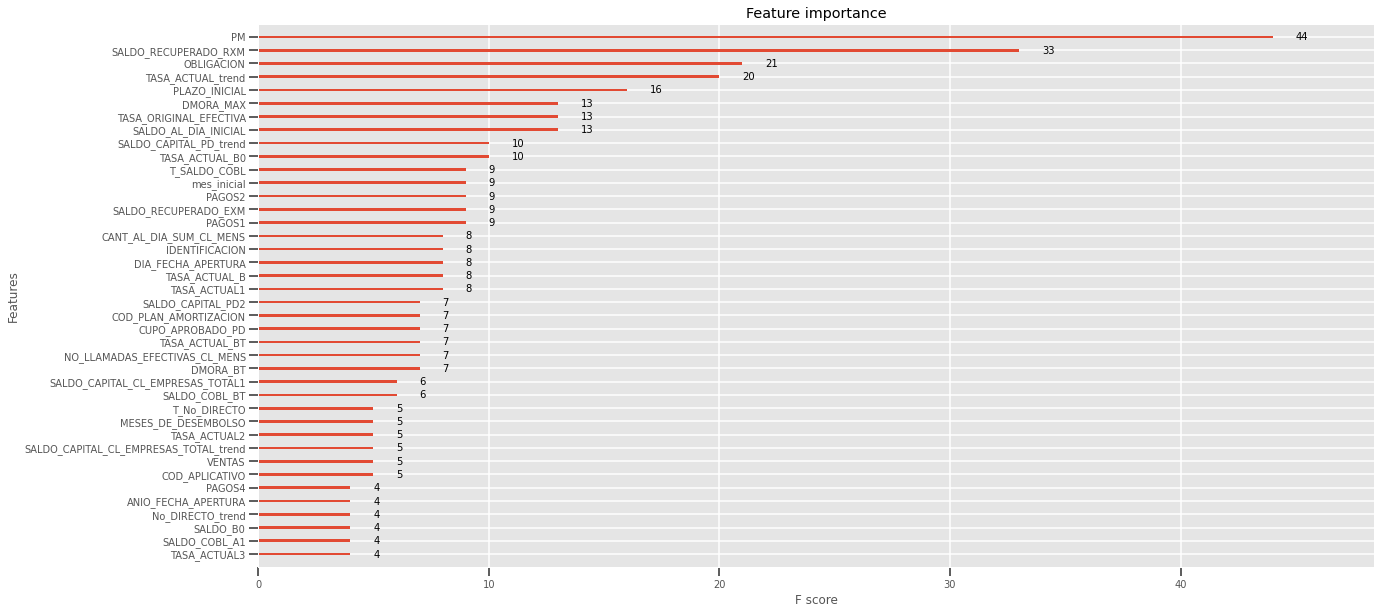

In [ ]:

#################################### Balanceo de datos

%%time

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = seed, shuffle=True, stratify=y)

weight_class=y_train.ID_PAGOS.value_counts()[0]/y_train.ID_PAGOS.value_counts()[1]


######################Modelado Xgboost


#model_xgb = model_xgboost(X_train, y_train, X_test, y_test, weight=weight_class ,grid_hiper=True)
model_xgb = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=10, eval_metric=['error', 'logloss'],
              gamma=9, learning_rate=0.3, max_delta_step=13, max_depth=2,
              min_child_weight=2, missing=None, n_estimators=250, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=12, reg_lambda=11, scale_pos_weight=3.130009466708741,
              seed=None, silent=None, subsample=0.9, verbosity=1)
eval_set = [(X_train, y_train), (X_test, y_test)]
model_xgb.fit(X_train, y_train,eval_set=eval_set)

%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 10.0)
sns.set_context("talk", font_scale=0.6)
plt.style.use('ggplot')
plot_importance(model_xgb, max_num_features= 40)

filename = ruta+ "/modelo_xgb_mipyme0.sav"
pickle.dump(model_xgb, open(filename, 'wb'))


##############################################################################################
###################################################################################################
print_score(model_xgb, X_train, y_train, X_test, y_test, train=True)
print_score(model_xgb, X_train, y_train, X_test, y_test, train=False)

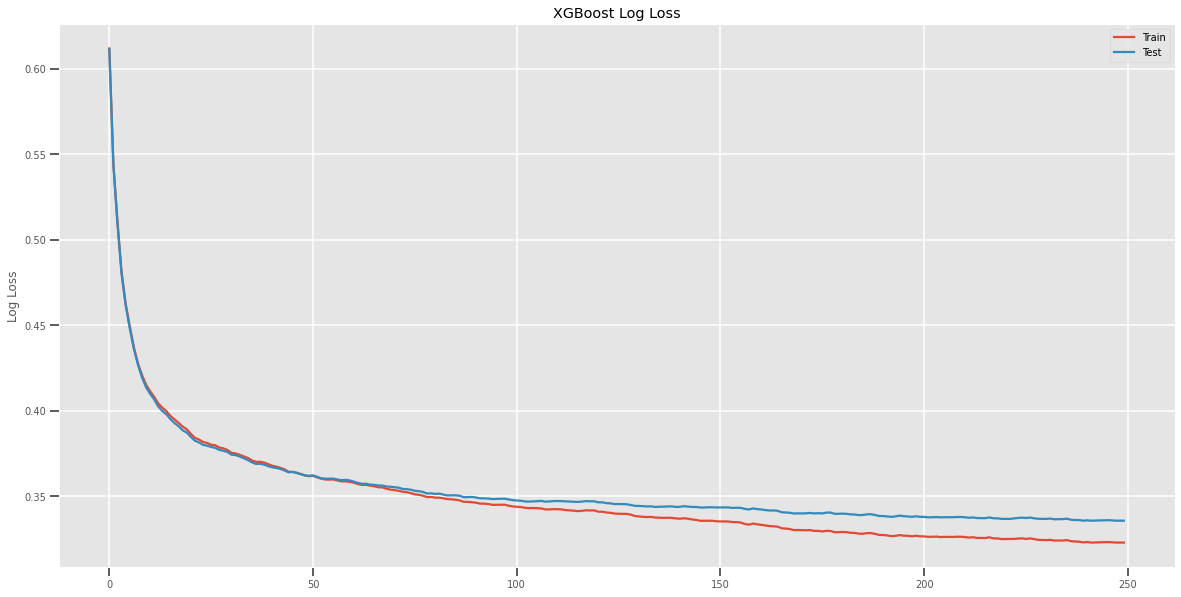

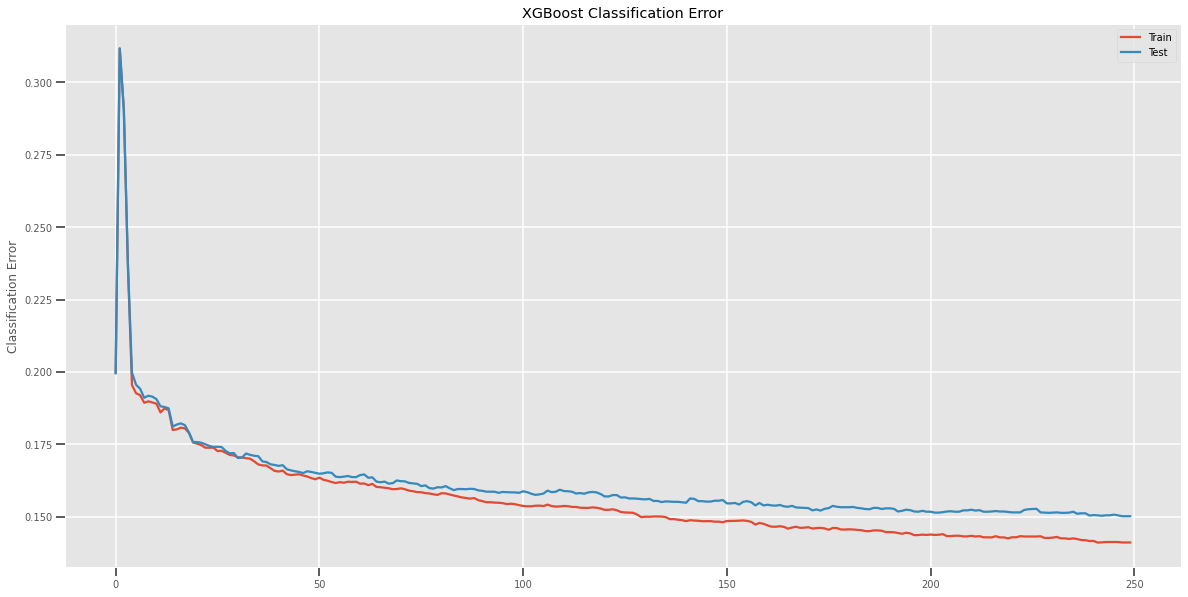

In [ ]:

   # retrieve performance metrics
results = model_xgb.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

In [ ]:
#Dataframe de resultados

idx= ['Resultados_X_train', 'Resultados_X_val', 'Resultados_X_test_enero', 'Resultados_X_test_febrero']


y_train_pred = model_xgb.predict(X_train)

p = model_xgb.predict_proba(X_train)
fp_rates, tp_rates, _ = roc_curve(y_train,p[:,1])
roc_auc = auc(fp_rates, tp_rates)

resultados_eval = pd.DataFrame(index=idx)
resultados_eval.loc['Resultados_X_train','Precision'] = precision_score(y_train, y_train_pred )
resultados_eval.loc['Resultados_X_train','Recall'] = recall_score(y_train, y_train_pred )
resultados_eval.loc['Resultados_X_train','ROC_AUC'] = roc_auc_score(y_train, y_train_pred )
resultados_eval.loc['Resultados_X_train', 'F1_Score'] = f1_score(y_train, y_train_pred )
resultados_eval.loc['Resultados_X_train', 'RMSE'] =np.sqrt( mean_squared_error(y_train, y_train_pred ))
resultados_eval.loc['Resultados_X_train', 'AUC'] = roc_auc
resultados_eval.loc['Resultados_X_train', 'Accuracy'] = accuracy_score(y_train, y_train_pred )

#------------------------------------------------------------------------------------------------------------
#Resultados de validación
#------------------------------------------------------------------------------------------------------------

y_test_pred = model_xgb.predict(X_test)
p = model_xgb.predict_proba(X_test)
fp_rates, tp_rates, _ = roc_curve(y_test,p[:,1])
roc_auc = auc(fp_rates, tp_rates)

resultados_eval.loc['Resultados_X_val','Precision'] = precision_score(y_test, y_test_pred )
resultados_eval.loc['Resultados_X_val','Recall'] = recall_score(y_test, y_test_pred )
resultados_eval.loc['Resultados_X_val','ROC_AUC'] = roc_auc_score(y_test, y_test_pred )
resultados_eval.loc['Resultados_X_val', 'F1_Score'] = f1_score(y_test, y_test_pred )
resultados_eval.loc['Resultados_X_val', 'RMSE'] =np.sqrt( mean_squared_error(y_test, y_test_pred ))
resultados_eval.loc['Resultados_X_val', 'AUC'] = roc_auc
resultados_eval.loc['Resultados_X_val', 'Accuracy'] = accuracy_score(y_test, y_test_pred)


In [ ]:
## Mejores parámetros para este modelo
model_xgb

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=10, eval_metric=['error', 'logloss'],
              gamma=9, learning_rate=0.3, max_delta_step=13, max_depth=2,
              min_child_weight=2, missing=None, n_estimators=250, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=12, reg_lambda=11, scale_pos_weight=3.130009466708741,
              seed=None, silent=None, subsample=0.9, verbosity=1)

**Resultados Enero**

Resultados de validación:

accuracy score: 0.8807

Reporte de clasificación: 
               precision    recall  f1-score   support

           0       0.91      0.92      0.92      4237
           1       0.81      0.78      0.80      1824

    accuracy                           0.88      6061
   macro avg       0.86      0.85      0.86      6061
weighted avg       0.88      0.88      0.88      6061


Confusion Matrix: 
 [[3913  324]
 [ 399 1425]]

RMSE 
0.3453798580244491

MSLE 
0.057311917020765483

F1-score 
0.7976490344248531

Recall 
0.78125

Presicion 
0.8147512864493996



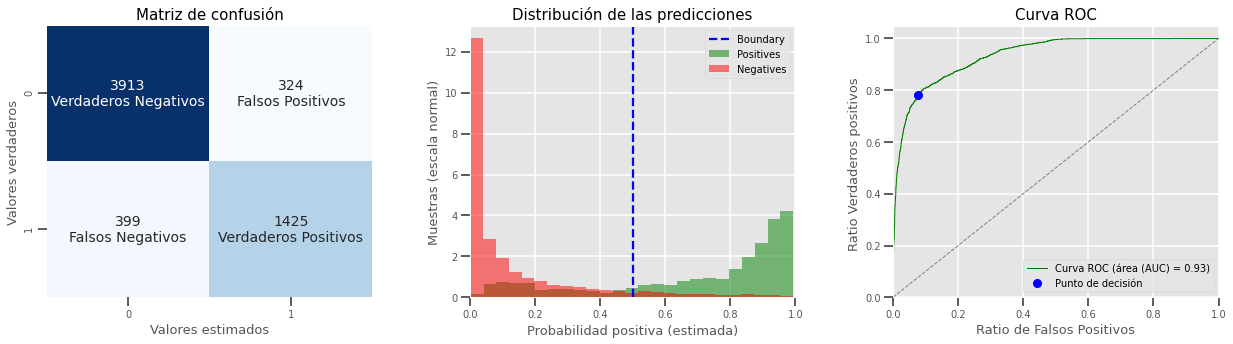

In [ ]:
##Evaluación para el mes de enero
X_test_p =  df_train[(df_train.mes_inicial==13)] 
y_test_p = X_test_p[['ID_PAGOS']]
X_test_p = X_test_p.drop("ID_PAGOS", axis=1)

print_score(model_xgb, X_test_p, y_test_p, X_test_p, y_test_p, train=False, valid=True)
###################################################################################################

F1 = evalBinaryClassifier(model_xgb, X_test_p, y_test_p)

In [ ]:
y_test_pred = model_xgb.predict(X_test_p)
p = model_xgb.predict_proba(X_test_p)
fp_rates, tp_rates, _ = roc_curve(y_test_p,p[:,1])
roc_auc = auc(fp_rates, tp_rates)
resultados_eval.loc['Resultados_X_test_enero','Precision'] = precision_score(y_test_p, y_test_pred )
resultados_eval.loc['Resultados_X_test_enero','Recall'] = recall_score(y_test_p, y_test_pred )
resultados_eval.loc['Resultados_X_test_enero','ROC_AUC'] = roc_auc_score(y_test_p, y_test_pred )
resultados_eval.loc['Resultados_X_test_enero', 'F1_Score'] = f1_score(y_test_p, y_test_pred )
resultados_eval.loc['Resultados_X_test_enero', 'RMSE'] =np.sqrt( mean_squared_error(y_test_p, y_test_pred ))
resultados_eval.loc['Resultados_X_test_enero', 'AUC'] = roc_auc
resultados_eval.loc['Resultados_X_test_enero', 'Accuracy'] = accuracy_score(y_test_p, y_test_pred)

In [ ]:
resultados_eval

Precision    Recall   ROC_AUC  F1_Score      RMSE  \
Resultados_X_train          0.660591  0.857684  0.858447  0.746344  0.375712   
Resultados_X_val            0.645756  0.840807  0.846724  0.730486  0.387589   
Resultados_X_test_enero     0.814751  0.781250  0.852390  0.797649  0.345380   
Resultados_X_test_febrero        NaN       NaN       NaN       NaN       NaN   

                                AUC  Accuracy  
Resultados_X_train         0.938483  0.858840  
Resultados_X_val           0.929188  0.849775  
Resultados_X_test_enero    0.934974  0.880713  
Resultados_X_test_febrero       NaN       NaN

In [ ]:
resultados_eval.to_csv( ruta+ "/tabla_desempeño_mipyme0.csv", index=False)

**Resultados de validación Febrero**

*Para validar el modelo en febrero cargamos el modelo entrenado anteriormente*

In [ ]:
model_xgb = pickle.load(open(ruta+ "/modelo_xgb_mipyme0.sav", 'rb'))

*Repetimos un procedimieno análogo al descrito anteriormente para poder evaluar los datos de febrero. Nota debemos crear df_train que se crea en la primera linea de este modelo, esta linea del código da la estructura para evaluar nuestros datos.*

In [ ]:
##Evaluación para el mes de Febrero
X_test_p =  df_train[(df_train.mes_inicial==14)] 
y_test_p = X_test_p[['ID_PAGOS']]
X_test_p = X_test_p.drop("ID_PAGOS", axis=1)

print_score(model_xgb, X_test_p, y_test_p, X_test_p, y_test_p, train=False, valid=True)
###################################################################################################

F1 = evalBinaryClassifier(model_xgb, X_test_p, y_test_p)

In [ ]:
resultados_eval = pd.read_csv( ruta+ "/tabla_desempeño_mipyme0.csv")
y_test_pred = model_xgb.predict(X_test_p.values)
p = model_xgb.predict_proba(X_test_p.values)
fp_rates, tp_rates, _ = roc_curve(y_test_p.values,p[:,1])
roc_auc = auc(fp_rates, tp_rates)
resultados_eval.loc['Resultados_X_test_febrero','Precision'] = precision_score(y_test_p.values, y_test_pred )
resultados_eval.loc['Resultados_X_test_febrero','Recall'] = recall_score(y_test_p.values, y_test_pred )
resultados_eval.loc['Resultados_X_test_febrero','ROC_AUC'] = roc_auc_score(y_test_p.values, y_test_pred )
resultados_eval.loc['Resultados_X_test_febrero', 'F1_Score'] = f1_score(y_test_p.values, y_test_pred )
resultados_eval.loc['Resultados_X_test_febrero', 'RMSE'] =np.sqrt( mean_squared_error(y_test_p.values, y_test_pred ))
resultados_eval.loc['Resultados_X_test_febrero', 'AUC'] = roc_auc
resultados_eval.loc['Resultados_X_test_febrero', 'Accuracy'] = accuracy_score(y_test_p.values, y_test_pred)
resultados_eval = resultados_eval.drop(3)
resultados_eval = resultados_eval.rename(index ={0:'Resultados_X_train', 1:'Resultados_X_Val', 2:'Resultados_X_test_enero'})
resultados_eval.loc['Modelo'] ='Mipyme0'
resultados_eval = resultados_eval.drop(4)


In [ ]:
resultados_eval.to_csv( ruta+ "/tabla_desempeño_mipyme0_feb.csv")

Precision    Recall   ROC_AUC  F1_Score      RMSE  \
Resultados_X_train          0.901717  0.884218  0.893919  0.892882  0.325702   
Resultados_X_val            0.893971  0.874117  0.885227  0.883933  0.338781   
Resultados_X_test_enero     0.796318  0.735197  0.827122  0.764538  0.369163   
Resultados_X_test_febrero        NaN       NaN       NaN       NaN       NaN   

                                AUC  Accuracy  
Resultados_X_train         0.959101  0.893918  
Resultados_X_val           0.959101  0.885227  
Resultados_X_test_enero    0.916078  0.863719  
Resultados_X_test_febrero       NaN       NaN

**¿Cómo está aprendiendo el modelo?**

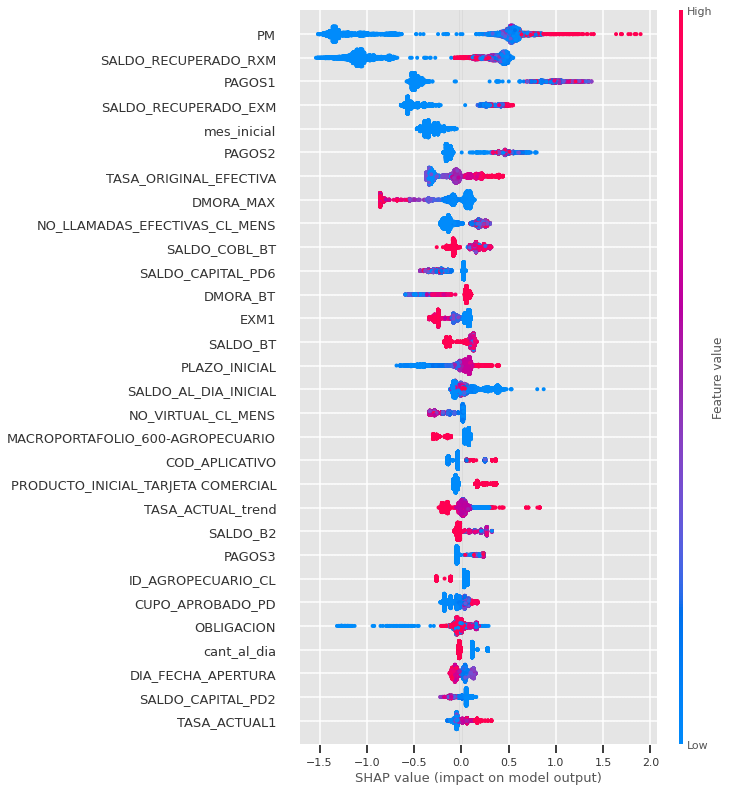

In [ ]:
explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(X_test_p)
shap.summary_plot(shap_values, X_test_p, max_display=30, feature_names=df_train.drop('ID_PAGOS', axis=1).columns)

**MiPyme RXE1==30**
-------------------------------------------------------------------------

In [ ]:
#@title Segmentación Pyme : MiPyme 30

df_train = df[(df.SUBSEGMENTO=='MiPyme') & (df.RXE1==30)]

df_train = df_train.drop(['SUBSEGMENTO', 'RXE1'],axis=1)
df_train = pd.get_dummies(df_train)
df_train = shuffle(df_train)

#Entrenamos hasta el mes de diciembre para realizar las pruebas en: Enero y Febrero
X = df_train[  (df_train.mes_inicial!=14) & (df_train.mes_inicial!=13)]
y = X[['ID_PAGOS']]
X = X.drop("ID_PAGOS", axis=1)

###############################################################


In [ ]:
y.value_counts()

ID_PAGOS
1           14561
0           10181
dtype: int64

Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:  7.1min remaining:    0.0s
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:  7.1min finished


[0]	validation_0-error:0.336671	validation_0-logloss:0.658704	validation_1-error:0.353092	validation_1-logloss:0.660444
[1]	validation_0-error:0.197684	validation_0-logloss:0.576731	validation_1-error:0.202817	validation_1-logloss:0.579595
[2]	validation_0-error:0.194185	validation_0-logloss:0.525724	validation_1-error:0.198653	validation_1-logloss:0.529492
[3]	validation_0-error:0.194245	validation_0-logloss:0.512081	validation_1-error:0.198775	validation_1-logloss:0.51659
[4]	validation_0-error:0.190384	validation_0-logloss:0.481213	validation_1-error:0.193999	validation_1-logloss:0.486374
[5]	validation_0-error:0.186825	validation_0-logloss:0.462147	validation_1-error:0.190202	validation_1-logloss:0.467968
[6]	validation_0-error:0.187006	validation_0-logloss:0.448146	validation_1-error:0.189835	validation_1-logloss:0.454356
[7]	validation_0-error:0.186885	validation_0-logloss:0.438283	validation_1-error:0.19008	validation_1-logloss:0.444601
[8]	validation_0-error:0.187006	validation

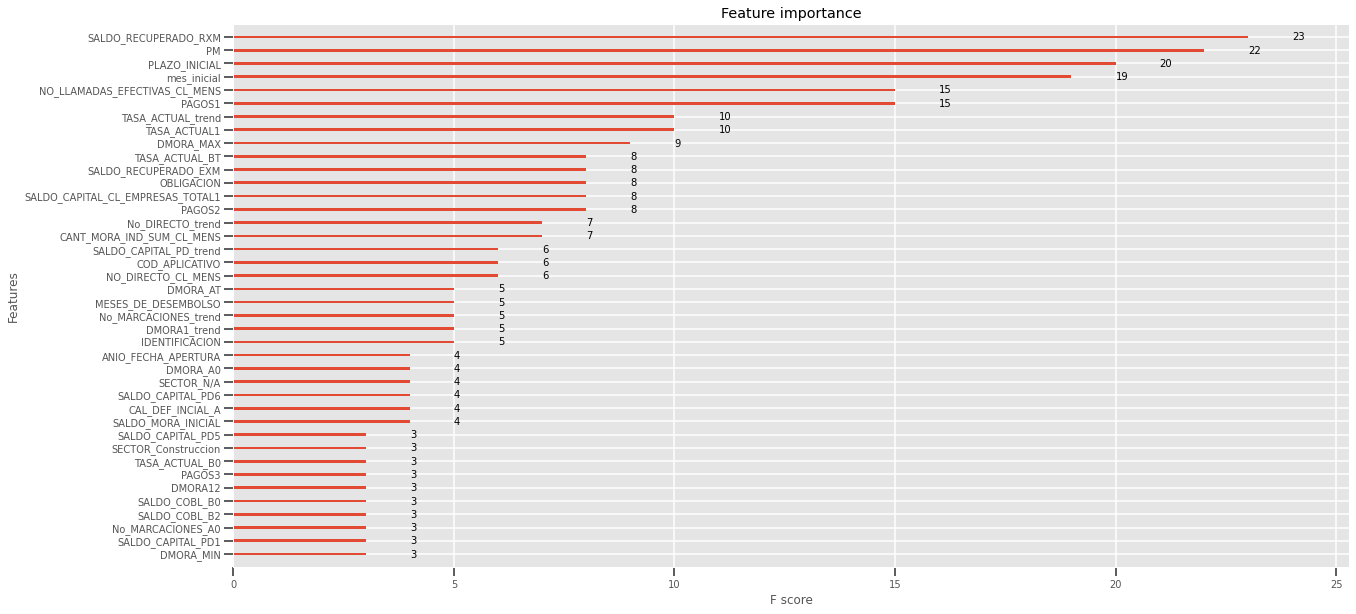

In [ ]:
%%time

#################################### Balanceo de datos



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = seed, shuffle=True, stratify=y)

weight_class=y_train.ID_PAGOS.value_counts()[1]/y_train.ID_PAGOS.value_counts()[0] #(segun la documentacion de xgboost sum(negative instances) / sum(positive instances)




######################Modelado Xgboost


model_xgb = model_xgboost(X_train, y_train, X_test, y_test, weight=weight_class ,grid_hiper=True)

%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 10.0)
sns.set_context("talk", font_scale=0.6)
plt.style.use('ggplot')
plot_importance(model_xgb, max_num_features= 40)

filename = ruta+ "/modelo_xgb_mipyme30.sav"
pickle.dump(model_xgb, open(filename, 'wb'))

##############################################################################################
###################################################################################################
print_score(model_xgb, X_train, y_train, X_test, y_test, train=True)
print_score(model_xgb, X_train, y_train, X_test, y_test, train=False)

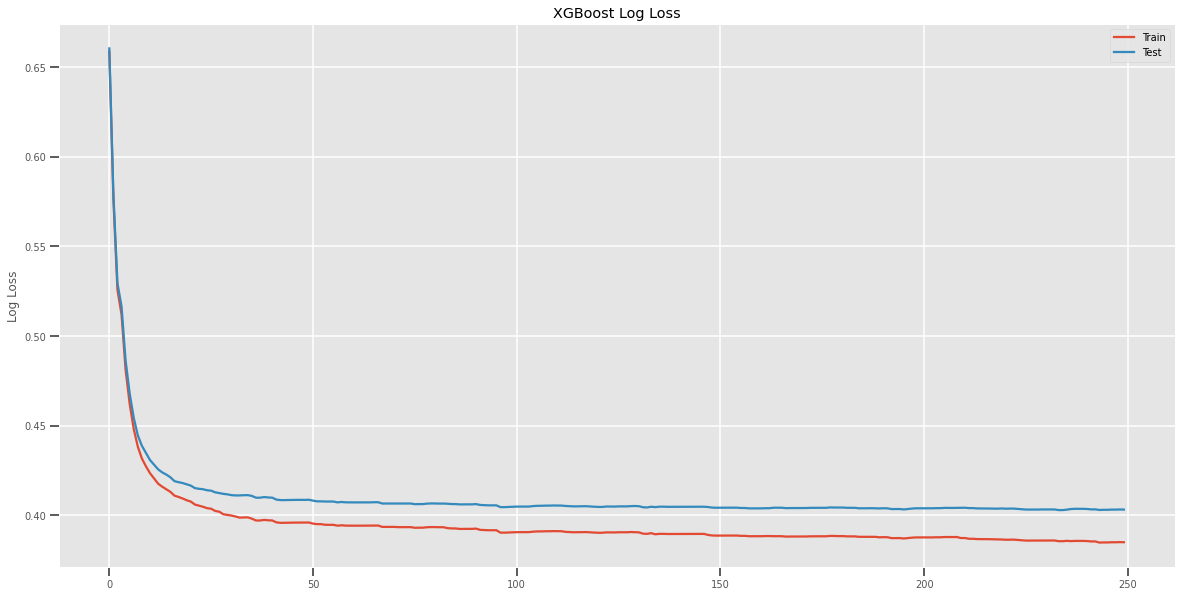

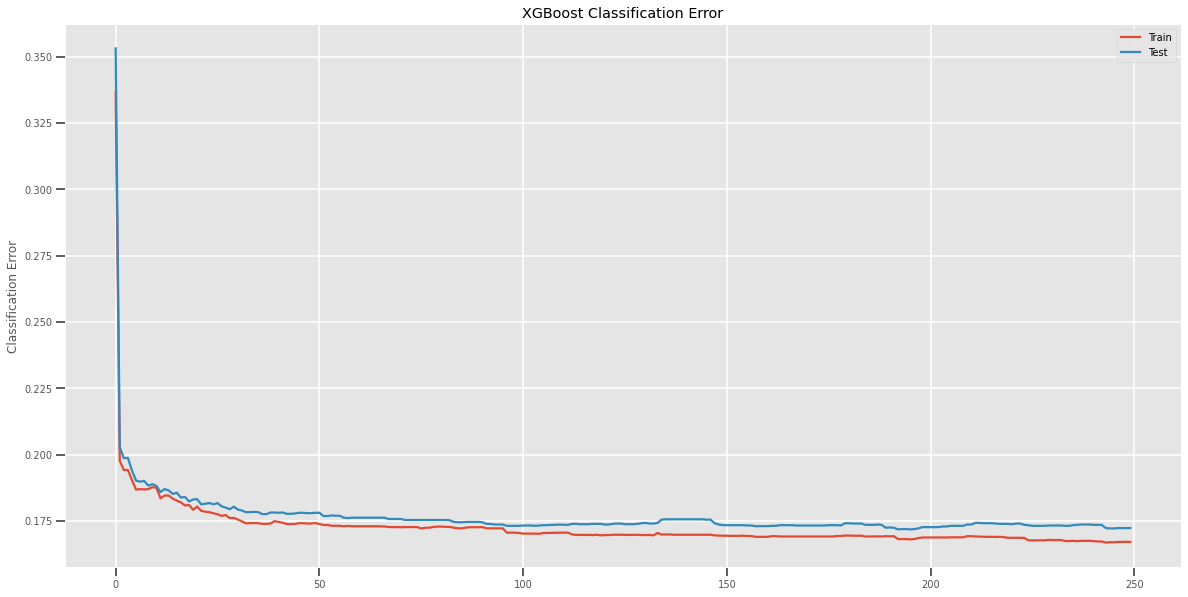

In [ ]:
# retrieve performance metrics
results = model_xgb.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

**Resultados Enero**

In [ ]:
#Dataframe de resultados

idx= ['Resultados_X_train', 'Resultados_X_val', 'Resultados_X_test_enero', 'Resultados_X_test_febrero']


y_train_pred = model_xgb.predict(X_train)

p = model_xgb.predict_proba(X_train)
fp_rates, tp_rates, _ = roc_curve(y_train,p[:,1])
roc_auc = auc(fp_rates, tp_rates)

resultados_eval = pd.DataFrame(index=idx)
resultados_eval.loc['Resultados_X_train','Precision'] = precision_score(y_train, y_train_pred )
resultados_eval.loc['Resultados_X_train','Recall'] = recall_score(y_train, y_train_pred )
resultados_eval.loc['Resultados_X_train','ROC_AUC'] = roc_auc_score(y_train, y_train_pred )
resultados_eval.loc['Resultados_X_train', 'F1_Score'] = f1_score(y_train, y_train_pred )
resultados_eval.loc['Resultados_X_train', 'RMSE'] =np.sqrt( mean_squared_error(y_train, y_train_pred ))
resultados_eval.loc['Resultados_X_train', 'AUC'] = roc_auc
resultados_eval.loc['Resultados_X_train', 'Accuracy'] = accuracy_score(y_train, y_train_pred )

#------------------------------------------------------------------------------------------------------------
#Resultados de validación
#------------------------------------------------------------------------------------------------------------

y_test_pred = model_xgb.predict(X_test)
p = model_xgb.predict_proba(X_test)
fp_rates, tp_rates, _ = roc_curve(y_test,p[:,1])
roc_auc = auc(fp_rates, tp_rates)

resultados_eval.loc['Resultados_X_val','Precision'] = precision_score(y_test, y_test_pred )
resultados_eval.loc['Resultados_X_val','Recall'] = recall_score(y_test, y_test_pred )
resultados_eval.loc['Resultados_X_val','ROC_AUC'] = roc_auc_score(y_test, y_test_pred )
resultados_eval.loc['Resultados_X_val', 'F1_Score'] = f1_score(y_test, y_test_pred )
resultados_eval.loc['Resultados_X_val', 'RMSE'] =np.sqrt( mean_squared_error(y_test, y_test_pred ))
resultados_eval.loc['Resultados_X_val', 'AUC'] = roc_auc
resultados_eval.loc['Resultados_X_val', 'Accuracy'] = accuracy_score(y_test, y_test_pred)

In [ ]:
## Mejores parámetros para este modelo
model_xgb

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6,
              early_stopping_rounds=10, eval_metric=['error', 'logloss'],
              gamma=10, learning_rate=0.25, max_delta_step=9, max_depth=7,
              min_child_weight=5, missing=None, n_estimators=250, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=12, reg_lambda=35, sampling_method='gradient_based',
              scale_pos_weight=1.4302888139568979, seed=None, silent=None,
              subsample=0.7, verbosity=1)

Resultados de validación:

accuracy score: 0.8259

Reporte de clasificación: 
               precision    recall  f1-score   support

           0       0.67      0.89      0.77      1320
           1       0.94      0.80      0.86      2793

    accuracy                           0.83      4113
   macro avg       0.81      0.84      0.81      4113
weighted avg       0.85      0.83      0.83      4113


Confusion Matrix: 
 [[1175  145]
 [ 571 2222]]

RMSE 
0.4172315645520435

MSLE 
0.08363830730985465

F1-score 
0.8612403100775193

Recall 
0.7955603293949158

Presicion 
0.9387410223912125



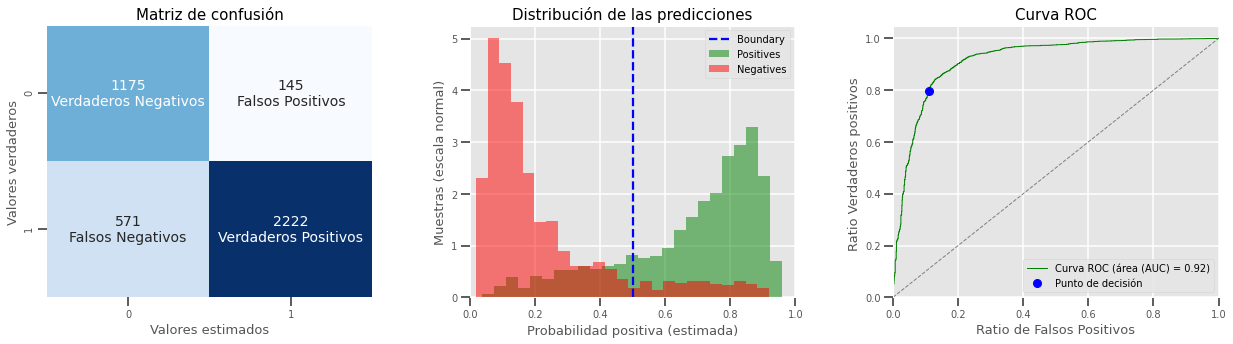

In [ ]:
##Evaluación para el mes de enero
X_test_p =  df_train[(df_train.mes_inicial==13)] 
y_test_p = X_test_p[['ID_PAGOS']]
X_test_p = X_test_p.drop("ID_PAGOS", axis=1)

print_score(model_xgb, X_test_p, y_test_p, X_test_p, y_test_p, train=False, valid=True)
###################################################################################################

F1 = evalBinaryClassifier(model_xgb, X_test_p, y_test_p)

In [ ]:
y_test_pred = model_xgb.predict(X_test_p)
p = model_xgb.predict_proba(X_test_p)
fp_rates, tp_rates, _ = roc_curve(y_test_p,p[:,1])
roc_auc = auc(fp_rates, tp_rates)
resultados_eval.loc['Resultados_X_test_enero','Precision'] = precision_score(y_test_p, y_test_pred )
resultados_eval.loc['Resultados_X_test_enero','Recall'] = recall_score(y_test_p, y_test_pred )
resultados_eval.loc['Resultados_X_test_enero','ROC_AUC'] = roc_auc_score(y_test_p, y_test_pred )
resultados_eval.loc['Resultados_X_test_enero', 'F1_Score'] = f1_score(y_test_p, y_test_pred )
resultados_eval.loc['Resultados_X_test_enero', 'RMSE'] =np.sqrt( mean_squared_error(y_test_p, y_test_pred ))
resultados_eval.loc['Resultados_X_test_enero', 'AUC'] = roc_auc
resultados_eval.loc['Resultados_X_test_enero', 'Accuracy'] = accuracy_score(y_test_p, y_test_pred)

In [ ]:
resultados_eval

Precision    Recall   ROC_AUC  F1_Score      RMSE  \
Resultados_X_train          0.820930  0.915847  0.815056  0.865795  0.408777   
Resultados_X_val            0.814164  0.916337  0.808615  0.862234  0.415116   
Resultados_X_test_enero     0.938741  0.795560  0.842856  0.861240  0.417232   
Resultados_X_test_febrero        NaN       NaN       NaN       NaN       NaN   

                                AUC  Accuracy  
Resultados_X_train         0.909403  0.832901  
Resultados_X_val           0.898384  0.827679  
Resultados_X_test_enero    0.917136  0.825918  
Resultados_X_test_febrero       NaN       NaN

In [ ]:
resultados_eval.to_csv( ruta+ "/tabla_desempeño_mipyme30.csv", index=False)

**Resultados Febrero**

*Para validar el modelo en febrero cargamos el modelo entrenado anteriormente*

In [ ]:
model_xgb = pickle.load(open(ruta+ "/modelo_xgb_mipyme30.sav", 'rb'))

*Repetimos un procedimieno análogo al descrito anteriormente para poder evaluar los datos de febrero. Nota debemos crear df_train que se crea en la primera linea de este modelo, esta linea del código da la estructura para evaluar nuestros datos.*

In [ ]:
##Evaluación para el mes de Febrero
X_test_p =  df_train[(df_train.mes_inicial==14)] 
y_test_p = X_test_p[['ID_PAGOS']]
X_test_p = X_test_p.drop("ID_PAGOS", axis=1)

print_score(model_xgb, X_test_p, y_test_p, X_test_p, y_test_p, train=False, valid=True)
###################################################################################################

F1 = evalBinaryClassifier(model_xgb, X_test_p, y_test_p)

In [ ]:
resultados_eval = pd.read_csv( ruta+ "/tabla_desempeño_mipyme30.csv")
y_test_pred = model_xgb.predict(X_test_p.values)
p = model_xgb.predict_proba(X_test_p.values)
fp_rates, tp_rates, _ = roc_curve(y_test_p.values,p[:,1])
roc_auc = auc(fp_rates, tp_rates)
resultados_eval.loc['Resultados_X_test_febrero','Precision'] = precision_score(y_test_p.values, y_test_pred )
resultados_eval.loc['Resultados_X_test_febrero','Recall'] = recall_score(y_test_p.values, y_test_pred )
resultados_eval.loc['Resultados_X_test_febrero','ROC_AUC'] = roc_auc_score(y_test_p.values, y_test_pred )
resultados_eval.loc['Resultados_X_test_febrero', 'F1_Score'] = f1_score(y_test_p.values, y_test_pred )
resultados_eval.loc['Resultados_X_test_febrero', 'RMSE'] =np.sqrt( mean_squared_error(y_test_p.values, y_test_pred ))
resultados_eval.loc['Resultados_X_test_febrero', 'AUC'] = roc_auc
resultados_eval.loc['Resultados_X_test_febrero', 'Accuracy'] = accuracy_score(y_test_p.values, y_test_pred)
resultados_eval = resultados_eval.drop(3)
resultados_eval = resultados_eval.rename(index ={0:'Resultados_X_train', 1:'Resultados_X_Val', 2:'Resultados_X_test_enero'})
resultados_eval.loc['Modelo'] ='Mipyme30'

In [ ]:
resultados_eval

In [ ]:
resultados_eval.to_csv( ruta+ "/tabla_desempeño_mipyme30_feb.csv", index=False)

**¿Cómo está aprendiendo el modelo?**

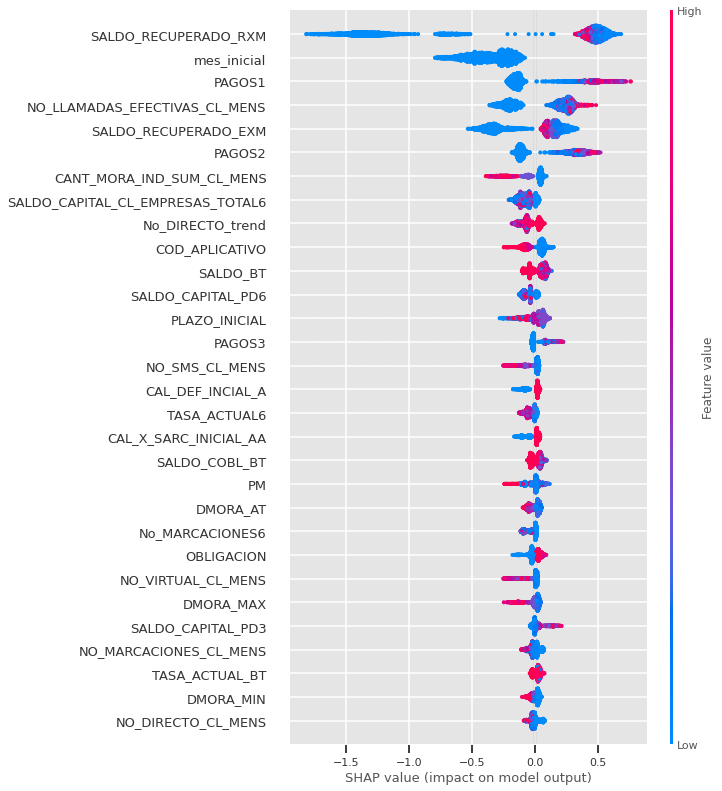

In [ ]:
explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(X_test_p)
shap.summary_plot(shap_values, X_test_p, max_display=30, feature_names=df_train.drop(['ID_PAGOS'], axis=1).columns)

**MiPyme RXE1= 60**
---------------------------------------------------------

In [ ]:
#@title Segmentación Pyme : MiPyme 60

df_train = df[(df.SUBSEGMENTO=='MiPyme') & (df.RXE1==60)]

df_train = df_train.drop(['SUBSEGMENTO', 'RXE1'],axis=1)
df_train = pd.get_dummies(df_train)
df_train = shuffle(df_train)

#Entrenamos hasta el mes de noviembre para realizar las pruebas en: Enero y Febrero
X = df_train[  (df_train.mes_inicial!=14) & (df_train.mes_inicial!=13)]
y = X[['ID_PAGOS']]
X = X.drop("ID_PAGOS", axis=1)

###############################################################

In [ ]:
y.value_counts()

ID_PAGOS
0           4967
1           3384
dtype: int64

Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:  1.1min finished


[0]	validation_0-error:0.358713	validation_0-logloss:0.676341	validation_1-error:0.370827	validation_1-logloss:0.678362
[1]	validation_0-error:0.215192	validation_0-logloss:0.595346	validation_1-error:0.217344	validation_1-logloss:0.595443
[2]	validation_0-error:0.217158	validation_0-logloss:0.560551	validation_1-error:0.214804	validation_1-logloss:0.558586
[3]	validation_0-error:0.213584	validation_0-logloss:0.533038	validation_1-error:0.213716	validation_1-logloss:0.530618
[4]	validation_0-error:0.219124	validation_0-logloss:0.518715	validation_1-error:0.22061	validation_1-logloss:0.515098
[5]	validation_0-error:0.211618	validation_0-logloss:0.506235	validation_1-error:0.219521	validation_1-logloss:0.502181
[6]	validation_0-error:0.211081	validation_0-logloss:0.497795	validation_1-error:0.218795	validation_1-logloss:0.494846
[7]	validation_0-error:0.209115	validation_0-logloss:0.493003	validation_1-error:0.212627	validation_1-logloss:0.490632
[8]	validation_0-error:0.209115	validatio

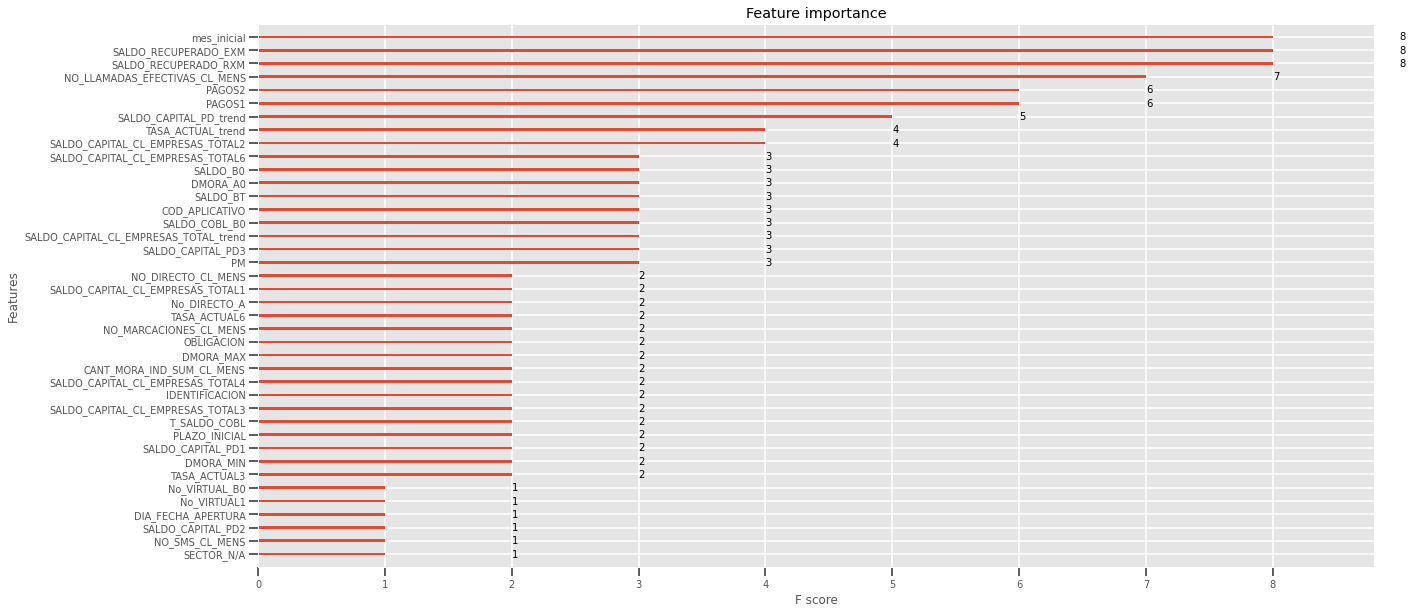

In [ ]:
%%time
#################################### Balanceo de datos



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = seed, shuffle=True, stratify=y)

weight_class=y_train.ID_PAGOS.value_counts()[0]/y_train.ID_PAGOS.value_counts()[1] #(segun la documentacion de xgboost sum(negative instances) / sum(positive instances)




######################Modelado Xgboost


model_xgb = model_xgboost(X_train, y_train, X_test, y_test, weight=weight_class ,grid_hiper=True)

%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 10.0)
sns.set_context("talk", font_scale=0.6)
plt.style.use('ggplot')
plot_importance(model_xgb, max_num_features= 40)

filename = ruta+ "/modelo_xgb_mipyme60.sav"
pickle.dump(model_xgb, open(filename, 'wb'))

##############################################################################################
###################################################################################################
print_score(model_xgb, X_train, y_train, X_test, y_test, train=True)
print_score(model_xgb, X_train, y_train, X_test, y_test, train=False)

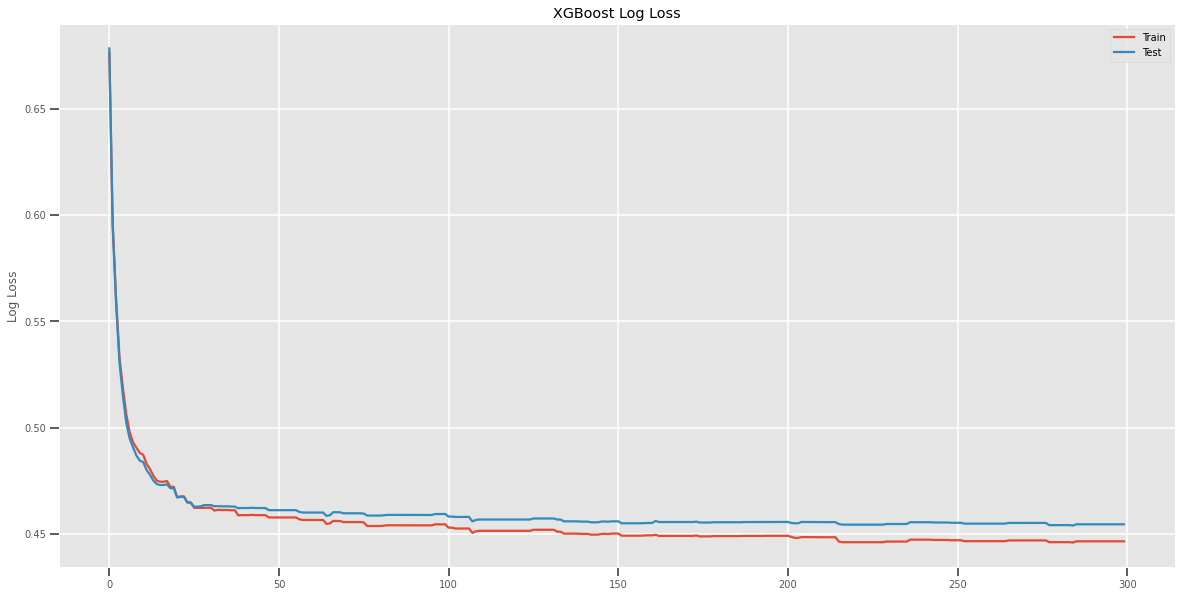

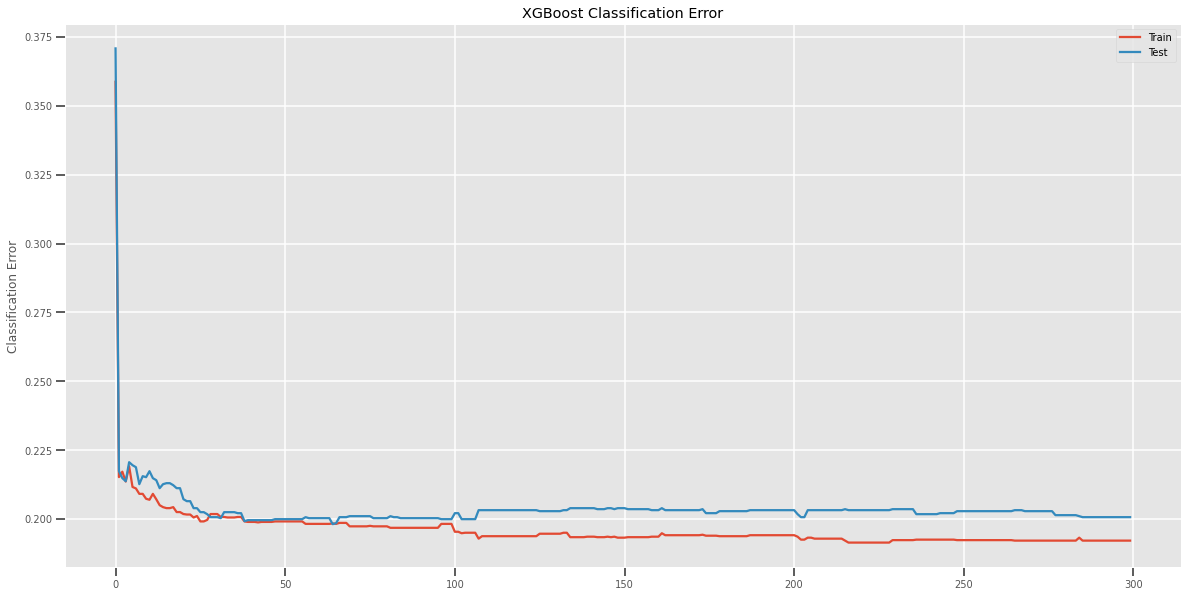

In [ ]:
# retrieve performance metrics
results = model_xgb.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

In [ ]:
#Dataframe de resultados

idx= ['Resultados_X_train', 'Resultados_X_val', 'Resultados_X_test_enero', 'Resultados_X_test_febrero']


y_train_pred = model_xgb.predict(X_train)

p = model_xgb.predict_proba(X_train)
fp_rates, tp_rates, _ = roc_curve(y_train,p[:,1])
roc_auc = auc(fp_rates, tp_rates)

resultados_eval = pd.DataFrame(index=idx)
resultados_eval.loc['Resultados_X_train','Precision'] = precision_score(y_train, y_train_pred )
resultados_eval.loc['Resultados_X_train','Recall'] = recall_score(y_train, y_train_pred )
resultados_eval.loc['Resultados_X_train','ROC_AUC'] = roc_auc_score(y_train, y_train_pred )
resultados_eval.loc['Resultados_X_train', 'F1_Score'] = f1_score(y_train, y_train_pred )
resultados_eval.loc['Resultados_X_train', 'RMSE'] =np.sqrt( mean_squared_error(y_train, y_train_pred ))
resultados_eval.loc['Resultados_X_train', 'AUC'] = roc_auc
resultados_eval.loc['Resultados_X_train', 'Accuracy'] = accuracy_score(y_train, y_train_pred )

#------------------------------------------------------------------------------------------------------------
#Resultados de validación
#------------------------------------------------------------------------------------------------------------

y_test_pred = model_xgb.predict(X_test)
p = model_xgb.predict_proba(X_test)
fp_rates, tp_rates, _ = roc_curve(y_test,p[:,1])
roc_auc = auc(fp_rates, tp_rates)

resultados_eval.loc['Resultados_X_val','Precision'] = precision_score(y_test, y_test_pred )
resultados_eval.loc['Resultados_X_val','Recall'] = recall_score(y_test, y_test_pred )
resultados_eval.loc['Resultados_X_val','ROC_AUC'] = roc_auc_score(y_test, y_test_pred )
resultados_eval.loc['Resultados_X_val', 'F1_Score'] = f1_score(y_test, y_test_pred )
resultados_eval.loc['Resultados_X_val', 'RMSE'] =np.sqrt( mean_squared_error(y_test, y_test_pred ))
resultados_eval.loc['Resultados_X_val', 'AUC'] = roc_auc
resultados_eval.loc['Resultados_X_val', 'Accuracy'] = accuracy_score(y_test, y_test_pred)

In [ ]:
## Mejores parámetros para este modelo
model_xgb

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3,
              early_stopping_rounds=10, eval_metric=['error', 'logloss'],
              gamma=6, learning_rate=0.35, max_delta_step=9, max_depth=8,
              min_child_weight=5, missing=None, n_estimators=300, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=20, reg_lambda=25, sampling_method='uniform',
              scale_pos_weight=1.4680194089104543, seed=None, silent=None,
              subsample=0.6, verbosity=1)

**Resultados Enero**

Resultados de validación:

accuracy score: 0.7464

Reporte de clasificación: 
               precision    recall  f1-score   support

           0       0.70      0.95      0.81       808
           1       0.90      0.49      0.64       663

    accuracy                           0.75      1471
   macro avg       0.80      0.72      0.72      1471
weighted avg       0.79      0.75      0.73      1471


Confusion Matrix: 
 [[771  37]
 [336 327]]

RMSE 
0.5035563530329149

MSLE 
0.12182799061284101

F1-score 
0.6368062317429407

Recall 
0.49321266968325794

Presicion 
0.8983516483516484



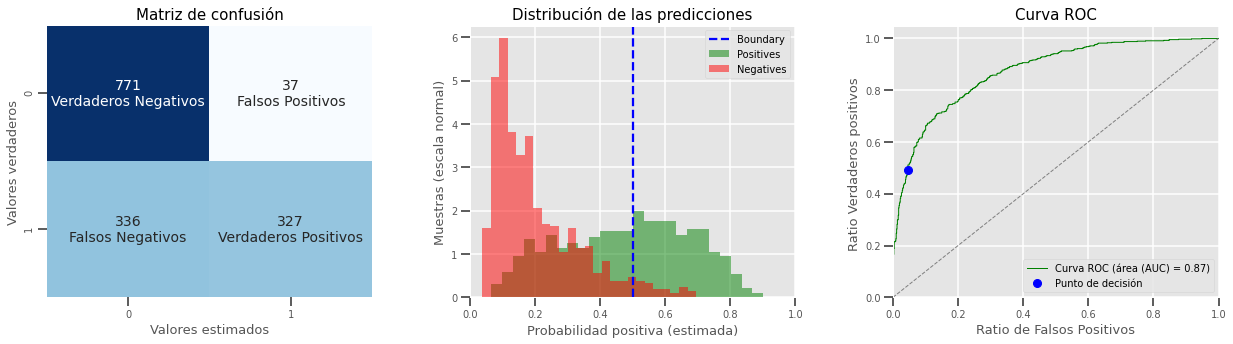

In [ ]:
##Evaluación para el mes de enero
X_test_p =  df_train[(df_train.mes_inicial==13)] 
y_test_p = X_test_p[['ID_PAGOS']]
X_test_p = X_test_p.drop("ID_PAGOS", axis=1)

print_score(model_xgb, X_test_p, y_test_p, X_test_p, y_test_p, train=False, valid=True)
###################################################################################################

F1 = evalBinaryClassifier(model_xgb, X_test_p, y_test_p)

In [ ]:
y_test_pred = model_xgb.predict(X_test_p)
p = model_xgb.predict_proba(X_test_p)
fp_rates, tp_rates, _ = roc_curve(y_test_p,p[:,1])
roc_auc = auc(fp_rates, tp_rates)
resultados_eval.loc['Resultados_X_test_enero','Precision'] = precision_score(y_test_p, y_test_pred )
resultados_eval.loc['Resultados_X_test_enero','Recall'] = recall_score(y_test_p, y_test_pred )
resultados_eval.loc['Resultados_X_test_enero','ROC_AUC'] = roc_auc_score(y_test_p, y_test_pred )
resultados_eval.loc['Resultados_X_test_enero', 'F1_Score'] = f1_score(y_test_p, y_test_pred )
resultados_eval.loc['Resultados_X_test_enero', 'RMSE'] =np.sqrt( mean_squared_error(y_test_p, y_test_pred ))
resultados_eval.loc['Resultados_X_test_enero', 'AUC'] = roc_auc
resultados_eval.loc['Resultados_X_test_enero', 'Accuracy'] = accuracy_score(y_test_p, y_test_pred)

In [ ]:
resultados_eval

Precision    Recall   ROC_AUC  F1_Score      RMSE  \
Resultados_X_train          0.748540  0.791795  0.805303  0.769561  0.438333   
Resultados_X_val            0.736975  0.785139  0.797084  0.760295  0.447943   
Resultados_X_test_enero     0.898352  0.493213  0.723710  0.636806  0.503556   
Resultados_X_test_febrero        NaN       NaN       NaN       NaN       NaN   

                                AUC  Accuracy  
Resultados_X_train         0.877090  0.807864  
Resultados_X_val           0.870500  0.799347  
Resultados_X_test_enero    0.872239  0.746431  
Resultados_X_test_febrero       NaN       NaN

In [ ]:
resultados_eval.to_csv( ruta+ "/tabla_desempeño_mipyme60.csv", index=False)

**Resultados Febrero**

*Para validar el modelo en febrero cargamos el modelo entrenado anteriormente*

In [ ]:
model_xgb = pickle.load(open(ruta+ "/modelo_xgb_mipyme60.sav", 'rb'))

*Repetimos un procedimieno análogo al descrito anteriormente para poder evaluar los datos de febrero. Nota debemos crear df_train que se crea en la primera linea de este modelo, esta linea del código da la estructura para evaluar nuestros datos.*

In [ ]:
##Evaluación para el mes de Febrero
X_test_p =  df_train[(df_train.mes_inicial==14)] 
y_test_p = X_test_p[['ID_PAGOS']]
X_test_p = X_test_p.drop("ID_PAGOS", axis=1)

print_score(model_xgb, X_test_p, y_test_p, X_test_p, y_test_p, train=False, valid=True)
###################################################################################################

F1 = evalBinaryClassifier(model_xgb, X_test_p, y_test_p)

In [ ]:
resultados_eval = pd.read_csv( ruta+ "/tabla_desempeño_mipyme60.csv")
y_test_pred = model_xgb.predict(X_test_p.values)
p = model_xgb.predict_proba(X_test_p.values)
fp_rates, tp_rates, _ = roc_curve(y_test_p.values,p[:,1])
roc_auc = auc(fp_rates, tp_rates)
resultados_eval.loc['Resultados_X_test_febrero','Precision'] = precision_score(y_test_p.values, y_test_pred )
resultados_eval.loc['Resultados_X_test_febrero','Recall'] = recall_score(y_test_p.values, y_test_pred )
resultados_eval.loc['Resultados_X_test_febrero','ROC_AUC'] = roc_auc_score(y_test_p.values, y_test_pred )
resultados_eval.loc['Resultados_X_test_febrero', 'F1_Score'] = f1_score(y_test_p.values, y_test_pred )
resultados_eval.loc['Resultados_X_test_febrero', 'RMSE'] =np.sqrt( mean_squared_error(y_test_p.values, y_test_pred ))
resultados_eval.loc['Resultados_X_test_febrero', 'AUC'] = roc_auc
resultados_eval.loc['Resultados_X_test_febrero', 'Accuracy'] = accuracy_score(y_test_p.values, y_test_pred)
resultados_eval = resultados_eval.drop(3)
resultados_eval = resultados_eval.rename(index ={0:'Resultados_X_train', 1:'Resultados_X_Val', 2:'Resultados_X_test_enero'})
resultados_eval.loc['Modelo'] ='Mipyme60'

In [ ]:
resultados_eval

In [ ]:
resultados_eval.to_csv( ruta+ "/tabla_desempeño_mipyme60_feb.csv")

**¿Cómo está aprendiendo el modelo?**

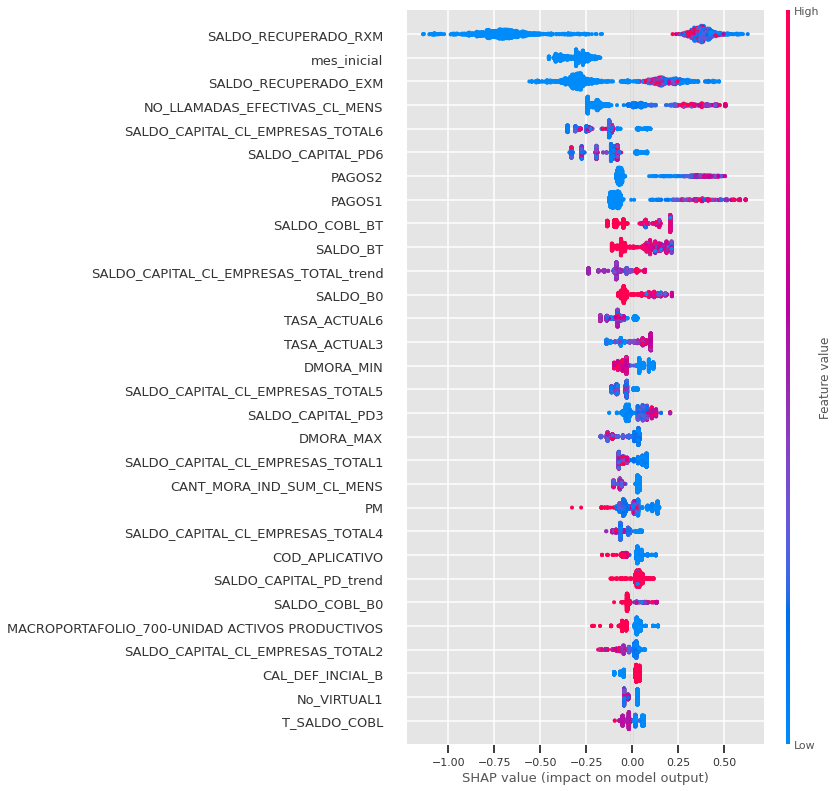

In [ ]:
explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(X_test_p)
shap.summary_plot(shap_values, X_test_p, max_display=30, feature_names=df_train.drop(['ID_PAGOS'], axis=1).columns)

**MiPyme RXE1==90**
---------------------------------------------------------

In [ ]:
#@title Segmentación Pyme : MiPyme 90


df_train = df[(df.SUBSEGMENTO=='MiPyme') & (df.RXE1==90)]

df_train = df_train.drop(['SUBSEGMENTO', 'RXE1'],axis=1)
df_train = pd.get_dummies(df_train)
df_train = shuffle(df_train)


#Entrenamos hasta el mes de noviembre para realizar las pruebas en: Enero y Febrero
X = df_train[  (df_train.mes_inicial!=14) & (df_train.mes_inicial!=13)]
y = X[['ID_PAGOS']]
X = X.drop("ID_PAGOS", axis=1)

###############################################################

In [ ]:
y.value_counts()

ID_PAGOS
0           3112
1           1370
dtype: int64

[0]	validation_0-error:0.336775	validation_0-logloss:0.689229	validation_1-error:0.360135	validation_1-logloss:0.689771
[1]	validation_0-error:0.220187	validation_0-logloss:0.673556	validation_1-error:0.224324	validation_1-logloss:0.673959
[2]	validation_0-error:0.216522	validation_0-logloss:0.669598	validation_1-error:0.232432	validation_1-logloss:0.670703
[3]	validation_0-error:0.206862	validation_0-logloss:0.654698	validation_1-error:0.214189	validation_1-logloss:0.655648
[4]	validation_0-error:0.206196	validation_0-logloss:0.641727	validation_1-error:0.212838	validation_1-logloss:0.642912
[5]	validation_0-error:0.201865	validation_0-logloss:0.629329	validation_1-error:0.210135	validation_1-logloss:0.630677
[6]	validation_0-error:0.200866	validation_0-logloss:0.617979	validation_1-error:0.208784	validation_1-logloss:0.619083
[7]	validation_0-error:0.202532	validation_0-logloss:0.607485	validation_1-error:0.213514	validation_1-logloss:0.608603
[8]	validation_0-error:0.203198	validati

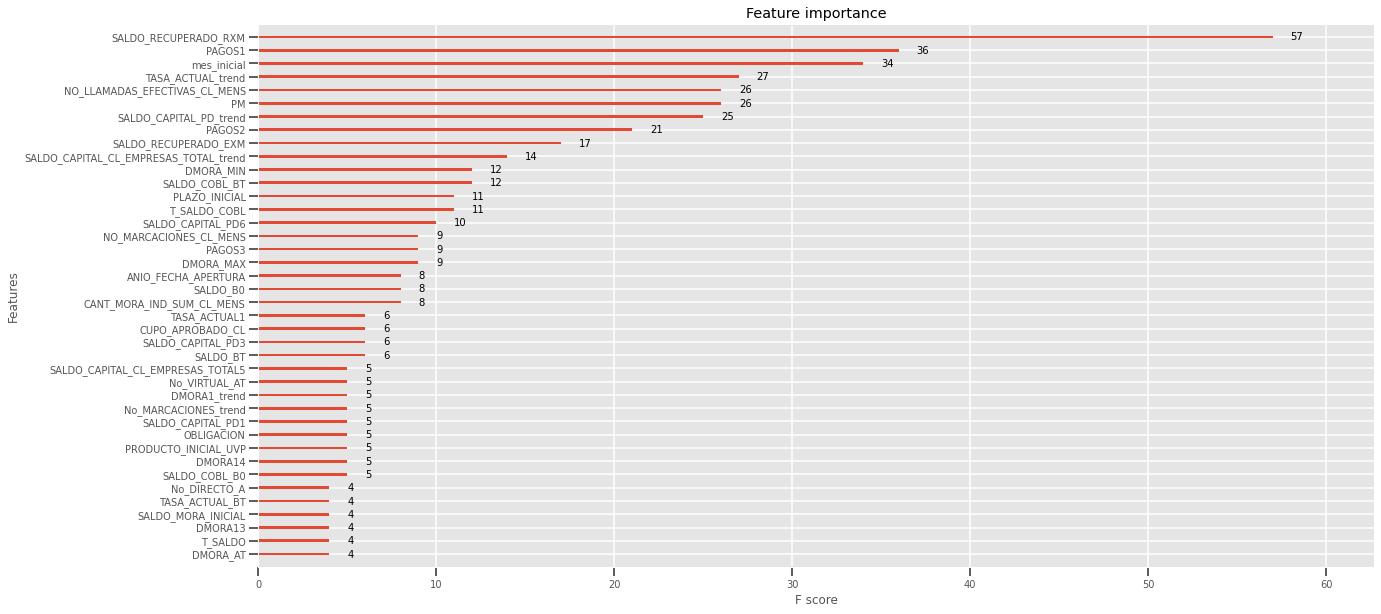

In [ ]:
%%time

#################################### Balanceo de datos



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = seed, shuffle=True, stratify=y)

weight_class=y_train.ID_PAGOS.value_counts()[0]/y_train.ID_PAGOS.value_counts()[1] #(segun la documentacion de xgboost sum(negative instances) / sum(positive instances)




######################Modelado Xgboost


model_xgb = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=10, eval_metric=['error', 'logloss'],
              gamma=6, learning_rate=0.05, max_delta_step=3, max_depth=4,
              min_child_weight=8, missing=None, n_estimators=250, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=11, reg_lambda=25, sampling_method='uniform',
              scale_pos_weight=2.270152505446623, seed=None, silent=None,
              subsample=0.5, verbosity=1)
eval_set = [(X_train, y_train), (X_test, y_test)]
model_xgb.fit(X_train, y_train,eval_set=eval_set)


%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 10.0)
sns.set_context("talk", font_scale=0.6)
plt.style.use('ggplot')
plot_importance(model_xgb, max_num_features= 40)

filename = ruta+ "/modelo_xgb_mipyme90.sav"
pickle.dump(model_xgb, open(filename, 'wb'))

##############################################################################################
###################################################################################################
print_score(model_xgb, X_train, y_train, X_test, y_test, train=True)
print_score(model_xgb, X_train, y_train, X_test, y_test, train=False)

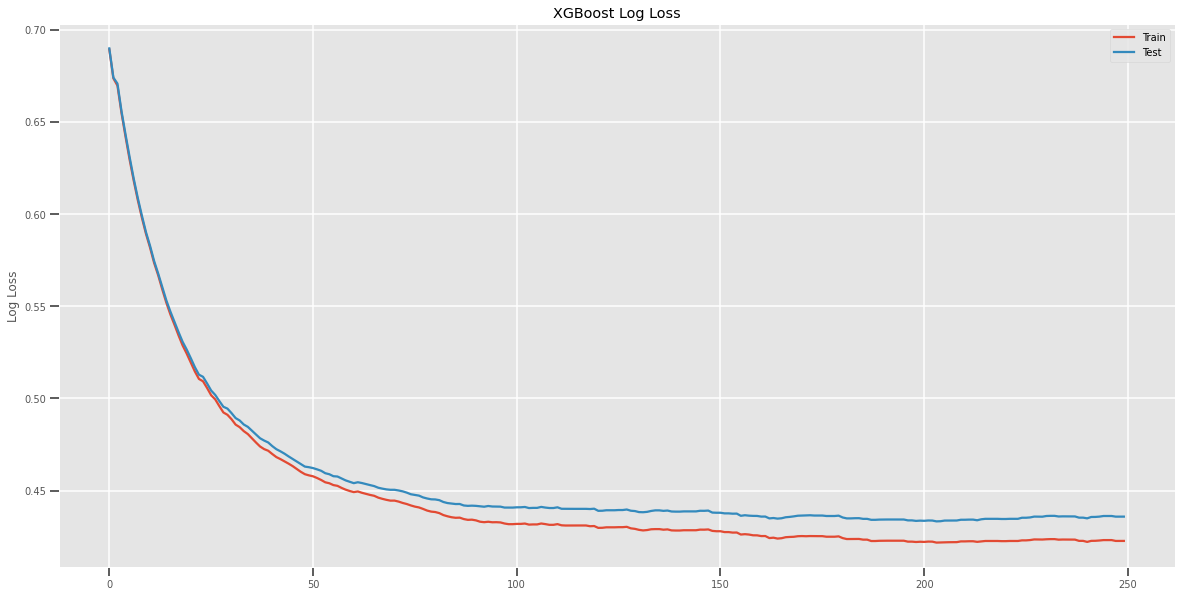

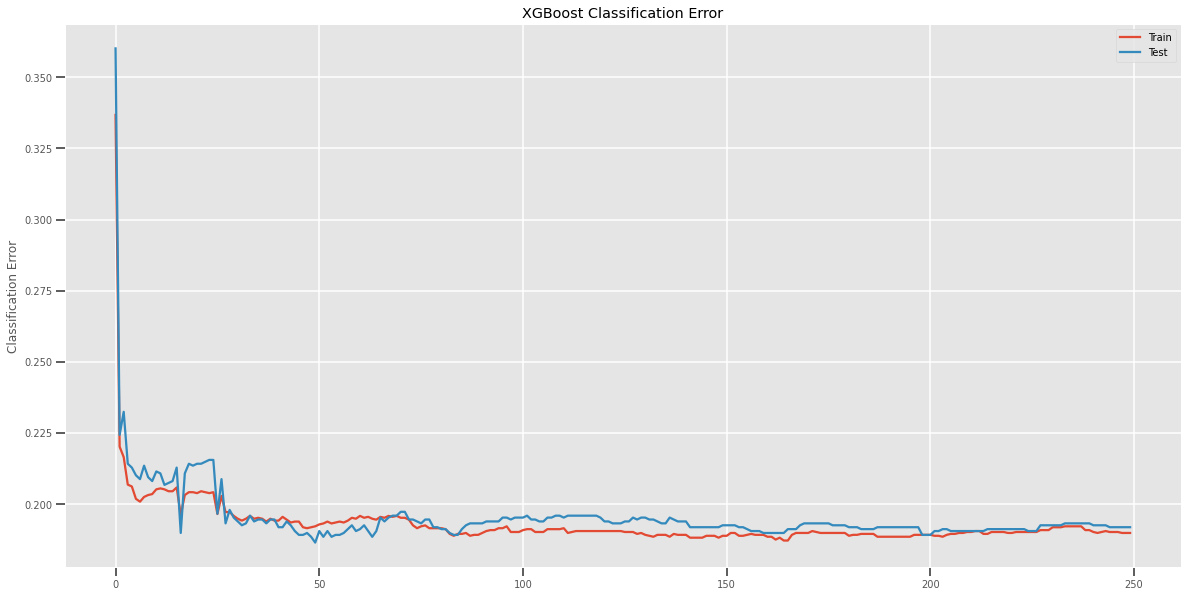

In [ ]:
# retrieve performance metrics
results = model_xgb.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

In [ ]:
#Dataframe de resultados

idx= ['Resultados_X_train', 'Resultados_X_val', 'Resultados_X_test_enero', 'Resultados_X_test_febrero']


y_train_pred = model_xgb.predict(X_train)

p = model_xgb.predict_proba(X_train)
fp_rates, tp_rates, _ = roc_curve(y_train,p[:,1])
roc_auc = auc(fp_rates, tp_rates)

resultados_eval = pd.DataFrame(index=idx)
resultados_eval.loc['Resultados_X_train','Precision'] = precision_score(y_train, y_train_pred )
resultados_eval.loc['Resultados_X_train','Recall'] = recall_score(y_train, y_train_pred )
resultados_eval.loc['Resultados_X_train','ROC_AUC'] = roc_auc_score(y_train, y_train_pred )
resultados_eval.loc['Resultados_X_train', 'F1_Score'] = f1_score(y_train, y_train_pred )
resultados_eval.loc['Resultados_X_train', 'RMSE'] =np.sqrt( mean_squared_error(y_train, y_train_pred ))
resultados_eval.loc['Resultados_X_train', 'AUC'] = roc_auc
resultados_eval.loc['Resultados_X_train', 'Accuracy'] = accuracy_score(y_train, y_train_pred )

#------------------------------------------------------------------------------------------------------------
#Resultados de validación
#------------------------------------------------------------------------------------------------------------

y_test_pred = model_xgb.predict(X_test)
p = model_xgb.predict_proba(X_test)
fp_rates, tp_rates, _ = roc_curve(y_test,p[:,1])
roc_auc = auc(fp_rates, tp_rates)

resultados_eval.loc['Resultados_X_val','Precision'] = precision_score(y_test, y_test_pred )
resultados_eval.loc['Resultados_X_val','Recall'] = recall_score(y_test, y_test_pred )
resultados_eval.loc['Resultados_X_val','ROC_AUC'] = roc_auc_score(y_test, y_test_pred )
resultados_eval.loc['Resultados_X_val', 'F1_Score'] = f1_score(y_test, y_test_pred )
resultados_eval.loc['Resultados_X_val', 'RMSE'] =np.sqrt( mean_squared_error(y_test, y_test_pred ))
resultados_eval.loc['Resultados_X_val', 'AUC'] = roc_auc
resultados_eval.loc['Resultados_X_val', 'Accuracy'] = accuracy_score(y_test, y_test_pred)

In [ ]:
# Mejores parámetros para este modelo
model_xgb

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=10, eval_metric=['error', 'logloss'],
              gamma=6, learning_rate=0.05, max_delta_step=3, max_depth=3,
              min_child_weight=8, missing=None, n_estimators=250, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=11, reg_lambda=25, sampling_method='uniform',
              scale_pos_weight=2.270152505446623, seed=None, silent=None,
              subsample=0.5, verbosity=1)

**Resultados Enero**

Resultados de validación:

accuracy score: 0.8111

Reporte de clasificación: 
               precision    recall  f1-score   support

           0       0.82      0.95      0.88       596
           1       0.78      0.45      0.57       230

    accuracy                           0.81       826
   macro avg       0.80      0.70      0.73       826
weighted avg       0.81      0.81      0.79       826


Confusion Matrix: 
 [[566  30]
 [126 104]]

RMSE 
0.4345825416099397

MSLE 
0.09073931013467243

F1-score 
0.5714285714285714

Recall 
0.45217391304347826

Presicion 
0.7761194029850746



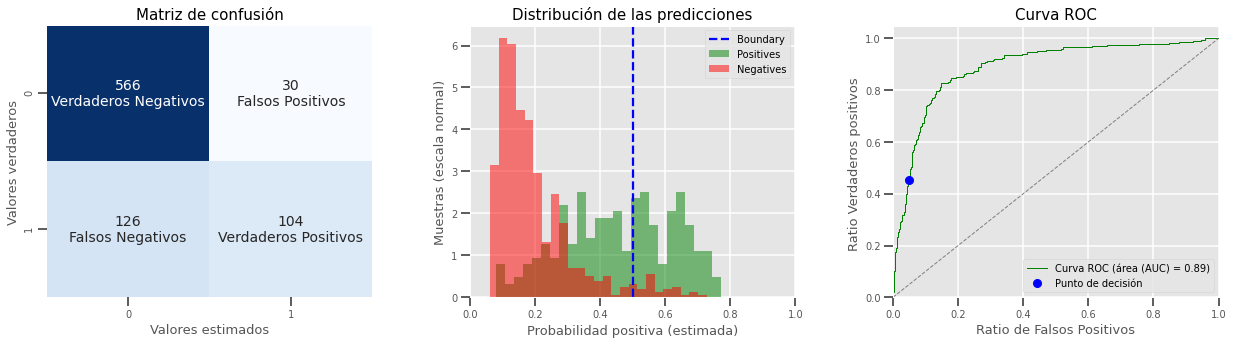

In [ ]:
##Evaluación para el mes de enero
X_test_p =  df_train[(df_train.mes_inicial==13)] 
y_test_p = X_test_p[['ID_PAGOS']]
X_test_p = X_test_p.drop("ID_PAGOS", axis=1)
print_score(model_xgb, X_test_p, y_test_p, X_test_p, y_test_p, train=False, valid=True)
###################################################################################################

F1 = evalBinaryClassifier(model_xgb, X_test_p, y_test_p)

In [ ]:
y_test_pred = model_xgb.predict(X_test_p)
p = model_xgb.predict_proba(X_test_p)
fp_rates, tp_rates, _ = roc_curve(y_test_p,p[:,1])
roc_auc = auc(fp_rates, tp_rates)
resultados_eval.loc['Resultados_X_test_enero','Precision'] = precision_score(y_test_p, y_test_pred )
resultados_eval.loc['Resultados_X_test_enero','Recall'] = recall_score(y_test_p, y_test_pred )
resultados_eval.loc['Resultados_X_test_enero','ROC_AUC'] = roc_auc_score(y_test_p, y_test_pred )
resultados_eval.loc['Resultados_X_test_enero', 'F1_Score'] = f1_score(y_test_p, y_test_pred )
resultados_eval.loc['Resultados_X_test_enero', 'RMSE'] =np.sqrt( mean_squared_error(y_test_p, y_test_pred ))
resultados_eval.loc['Resultados_X_test_enero', 'AUC'] = roc_auc
resultados_eval.loc['Resultados_X_test_enero', 'Accuracy'] = accuracy_score(y_test_p, y_test_pred)

In [ ]:
resultados_eval

Precision    Recall   ROC_AUC  F1_Score      RMSE  \
Resultados_X_train          0.645729  0.839869  0.818447  0.730114  0.435745   
Resultados_X_val            0.641892  0.840708  0.817241  0.727969  0.438055   
Resultados_X_test_enero     0.776119  0.452174  0.700919  0.571429  0.434583   
Resultados_X_test_febrero        NaN       NaN       NaN       NaN       NaN   

                                AUC  Accuracy  
Resultados_X_train         0.896423  0.810127  
Resultados_X_val           0.883206  0.808108  
Resultados_X_test_enero    0.889364  0.811138  
Resultados_X_test_febrero       NaN       NaN

In [ ]:
resultados_eval.to_csv( ruta+ "/tabla_desempeño_mipyme90.csv", index=False)

**Resultados Febrero**

*Para validar el modelo en febrero cargamos el modelo entrenado anteriormente*

In [ ]:
model_xgb = pickle.load(open(ruta+ "/modelo_xgb_mipyme90.sav", 'rb'))

#####################Cargamos el esquema de entrenamiento para darselo al marco de datos nuevo

esquema_train = pd.read_csv(ruta+"esquema_de_entrenamiento_mipyme90.csv")
columns_train = esquema_train.columns

*Repetimos un procedimieno análogo al descrito anteriormente para poder evaluar los datos de febrero. Nota debemos crear df_train que se crea en la primera linea de este modelo, esta linea del código da la estructura para evaluar nuestros datos.*


In [ ]:
##Evaluación para el mes de Febrero

X_test_p =  df_train[(df_train.mes_inicial==14)] 
y_test_p = X_test_p[['ID_PAGOS']]
X_test_p = X_test_p.drop("ID_PAGOS", axis=1)
print_score(model_xgb, X_test_p, y_test_p, X_test_p, y_test_p, train=False, valid=True)
###################################################################################################

F1 = evalBinaryClassifier(model_xgb, X_test_p, y_test_p)

In [ ]:
resultados_eval = pd.read_csv( ruta+ "/tabla_desempeño_mipyme90.csv")
y_test_pred = model_xgb.predict(X_test_p.values)
p = model_xgb.predict_proba(X_test_p.values)
fp_rates, tp_rates, _ = roc_curve(y_test_p.values,p[:,1])
roc_auc = auc(fp_rates, tp_rates)
resultados_eval.loc['Resultados_X_test_febrero','Precision'] = precision_score(y_test_p.values, y_test_pred )
resultados_eval.loc['Resultados_X_test_febrero','Recall'] = recall_score(y_test_p.values, y_test_pred )
resultados_eval.loc['Resultados_X_test_febrero','ROC_AUC'] = roc_auc_score(y_test_p.values, y_test_pred )
resultados_eval.loc['Resultados_X_test_febrero', 'F1_Score'] = f1_score(y_test_p.values, y_test_pred )
resultados_eval.loc['Resultados_X_test_febrero', 'RMSE'] =np.sqrt( mean_squared_error(y_test_p.values, y_test_pred ))
resultados_eval.loc['Resultados_X_test_febrero', 'AUC'] = roc_auc
resultados_eval.loc['Resultados_X_test_febrero', 'Accuracy'] = accuracy_score(y_test_p.values, y_test_pred)
resultados_eval = resultados_eval.drop(3)
resultados_eval = resultados_eval.rename(index ={0:'Resultados_X_train', 1:'Resultados_X_Val', 2:'Resultados_X_test_enero'})
resultados_eval.loc['Modelo'] ='Mipyme90'


In [ ]:
resultados_eval

In [ ]:
resultados_eval.to_csv( ruta+ "/tabla_desempeño_mipyme90_feb.csv")

**¿Cómo está aprendiendo el modelo?**

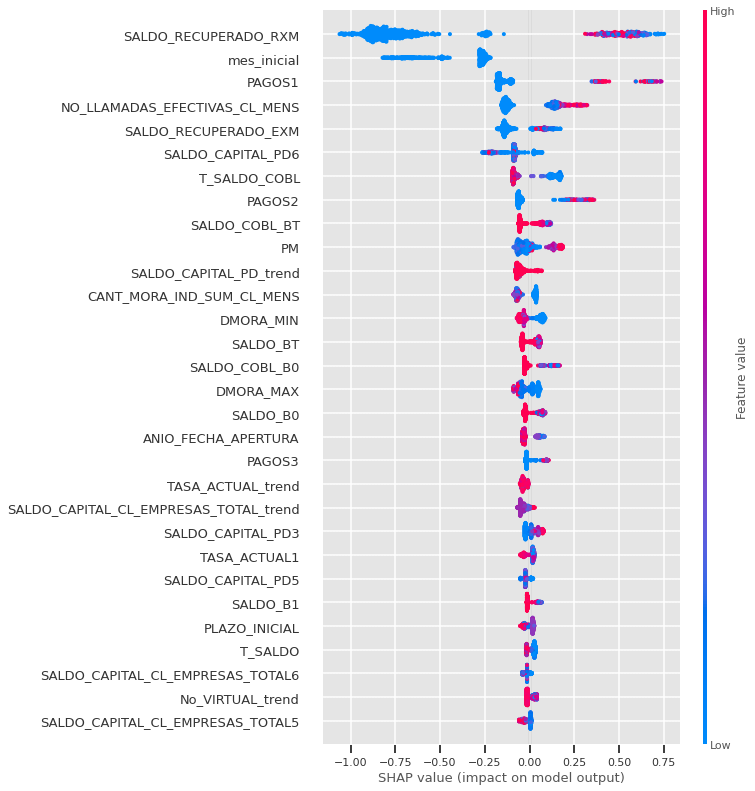

In [ ]:
explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(X_test_p)
shap.summary_plot(shap_values, X_test_p, max_display=30, feature_names=df_train.drop(['ID_PAGOS'], axis=1).columns)

**MiPyme 9999**
---------------------------------------------------

In [ ]:
#@title Segmentación Pyme : MiPyme 9999
df_train = df[(df.SUBSEGMENTO=='MiPyme') & (df.RXE1==9999)]

df_train = df_train.drop(['SUBSEGMENTO', 'RXE1'],axis=1)
df_train = pd.get_dummies(df_train)
df_train = shuffle(df_train)

#Entrenamos hasta el mes de noviembre para realizar las pruebas en: Enero y Febrero
X = df_train[  (df_train.mes_inicial!=14) & (df_train.mes_inicial!=13)]
y = X[['ID_PAGOS']]
X = X.drop("ID_PAGOS", axis=1)

###############################################################

In [ ]:
y.value_counts()

ID_PAGOS
0           30174
1            3019
dtype: int64

Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:  3.4min remaining:    0.0s
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:  3.4min finished


[0]	validation_0-error:0.296012	validation_0-logloss:0.613567	validation_1-error:0.295691	validation_1-logloss:0.614131
[1]	validation_0-error:0.196906	validation_0-logloss:0.536883	validation_1-error:0.200475	validation_1-logloss:0.540834
[2]	validation_0-error:0.195422	validation_0-logloss:0.503686	validation_1-error:0.202757	validation_1-logloss:0.508854
[3]	validation_0-error:0.169432	validation_0-logloss:0.458588	validation_1-error:0.175735	validation_1-logloss:0.46516
[4]	validation_0-error:0.15837	validation_0-logloss:0.434327	validation_1-error:0.16688	validation_1-logloss:0.442246
[5]	validation_0-error:0.15212	validation_0-logloss:0.417924	validation_1-error:0.161676	validation_1-logloss:0.426923
[6]	validation_0-error:0.15176	validation_0-logloss:0.407556	validation_1-error:0.158116	validation_1-logloss:0.417886
[7]	validation_0-error:0.147489	validation_0-logloss:0.393866	validation_1-error:0.154921	validation_1-logloss:0.406504
[8]	validation_0-error:0.15176	validation_0-l

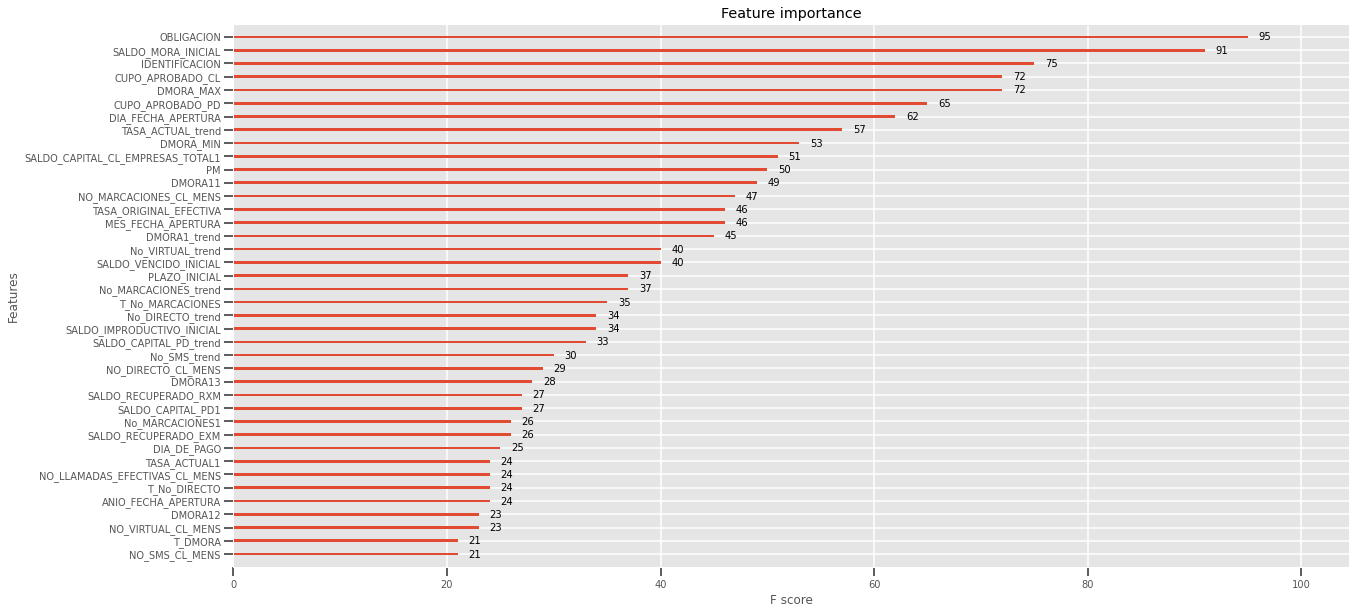

In [ ]:
%%time
#################################### Balanceo de datos



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = seed, shuffle=True, stratify=y)

weight_class=y_train.ID_PAGOS.value_counts()[0]/y_train.ID_PAGOS.value_counts()[1] #(segun la documentacion de xgboost sum(negative instances) / sum(positive instances)




######################Modelado Xgboost


model_xgb = model_xgboost(X_train, y_train, X_test, y_test, weight=weight_class ,grid_hiper=True)

%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 10.0)
sns.set_context("talk", font_scale=0.6)
plt.style.use('ggplot')
plot_importance(model_xgb, max_num_features= 40)

#filename = ruta+ "/modelo_xgb_mipyme9999.sav"
#pickle.dump(model_xgb, open(filename, 'wb'))

##############################################################################################
###################################################################################################
print_score(model_xgb, X_train, y_train, X_test, y_test, train=True)
print_score(model_xgb, X_train, y_train, X_test, y_test, train=False)

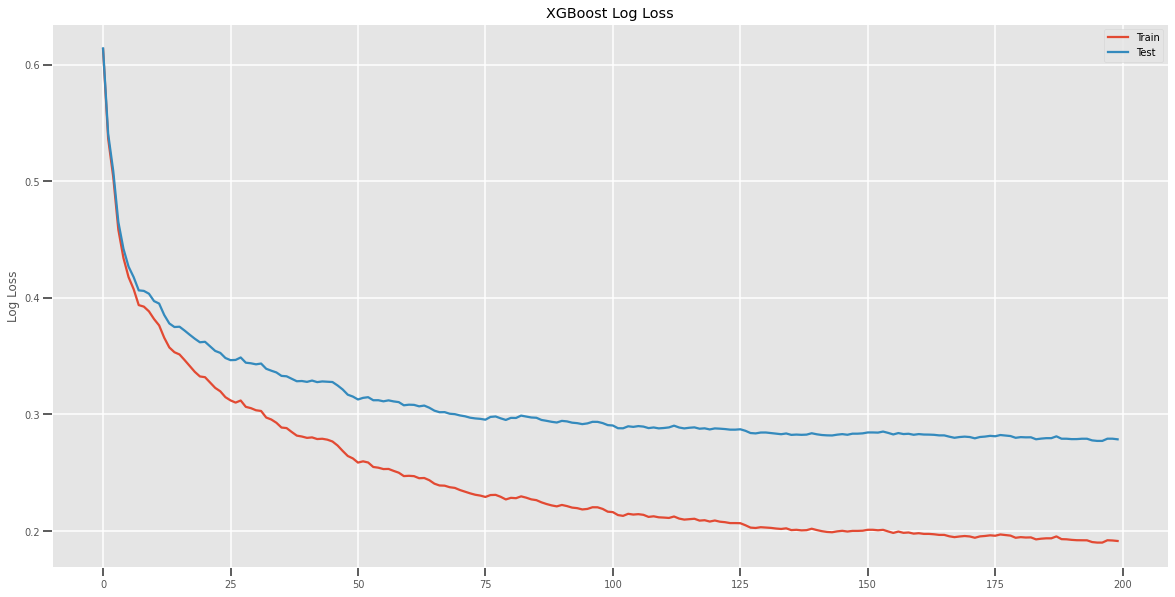

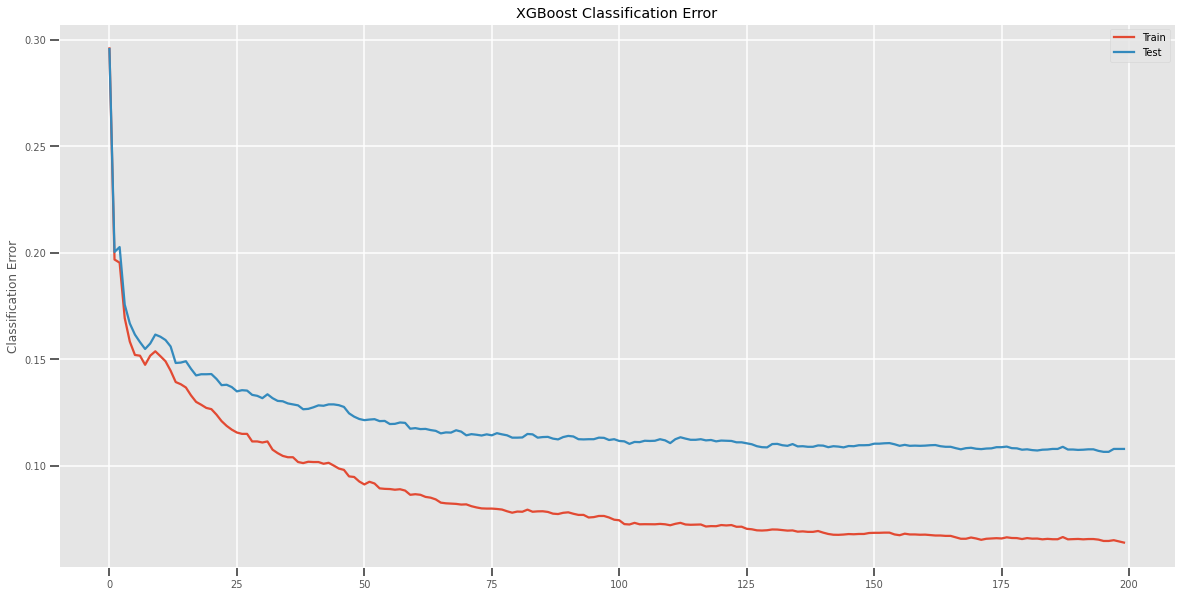

In [ ]:
# retrieve performance metrics
results = model_xgb.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

In [ ]:
#Dataframe de resultados

idx= ['Resultados_X_train', 'Resultados_X_val', 'Resultados_X_test_enero', 'Resultados_X_test_febrero']


y_train_pred = model_xgb.predict(X_train)

p = model_xgb.predict_proba(X_train)
fp_rates, tp_rates, _ = roc_curve(y_train,p[:,1])
roc_auc = auc(fp_rates, tp_rates)

resultados_eval = pd.DataFrame(index=idx)
resultados_eval.loc['Resultados_X_train','Precision'] = precision_score(y_train, y_train_pred )
resultados_eval.loc['Resultados_X_train','Recall'] = recall_score(y_train, y_train_pred )
resultados_eval.loc['Resultados_X_train','ROC_AUC'] = roc_auc_score(y_train, y_train_pred )
resultados_eval.loc['Resultados_X_train', 'F1_Score'] = f1_score(y_train, y_train_pred )
resultados_eval.loc['Resultados_X_train', 'RMSE'] =np.sqrt( mean_squared_error(y_train, y_train_pred ))
resultados_eval.loc['Resultados_X_train', 'AUC'] = roc_auc
resultados_eval.loc['Resultados_X_train', 'Accuracy'] = accuracy_score(y_train, y_train_pred )

#------------------------------------------------------------------------------------------------------------
#Resultados de validación
#------------------------------------------------------------------------------------------------------------

y_test_pred = model_xgb.predict(X_test)
p = model_xgb.predict_proba(X_test)
fp_rates, tp_rates, _ = roc_curve(y_test,p[:,1])
roc_auc = auc(fp_rates, tp_rates)

resultados_eval.loc['Resultados_X_val','Precision'] = precision_score(y_test, y_test_pred )
resultados_eval.loc['Resultados_X_val','Recall'] = recall_score(y_test, y_test_pred )
resultados_eval.loc['Resultados_X_val','ROC_AUC'] = roc_auc_score(y_test, y_test_pred )
resultados_eval.loc['Resultados_X_val', 'F1_Score'] = f1_score(y_test, y_test_pred )
resultados_eval.loc['Resultados_X_val', 'RMSE'] =np.sqrt( mean_squared_error(y_test, y_test_pred ))
resultados_eval.loc['Resultados_X_val', 'AUC'] = roc_auc
resultados_eval.loc['Resultados_X_val', 'Accuracy'] = accuracy_score(y_test, y_test_pred)

In [ ]:
## Mejores parámetros para este modelo
model_xgb

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5,
              early_stopping_rounds=10, eval_metric=['error', 'logloss'],
              gamma=9, learning_rate=0.1, max_delta_step=6, max_depth=10,
              min_child_weight=7, missing=None, n_estimators=120, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=16, reg_lambda=12, sampling_method='uniform',
              scale_pos_weight=9.993079584775087, seed=None, silent=None,
              subsample=0.8, verbosity=1)

**Resultados Enero**

Resultados de validación:

accuracy score: 0.9117

Reporte de clasificación: 
               precision    recall  f1-score   support

           0       0.95      0.95      0.95      3989
           1       0.54      0.58      0.56       427

    accuracy                           0.91      4416
   macro avg       0.75      0.76      0.76      4416
weighted avg       0.91      0.91      0.91      4416


Confusion Matrix: 
 [[3777  212]
 [ 178  249]]

RMSE 
0.2971787633585286

MSLE 
0.04243131237049333

F1-score 
0.5608108108108107

Recall 
0.5831381733021077

Presicion 
0.5401301518438177



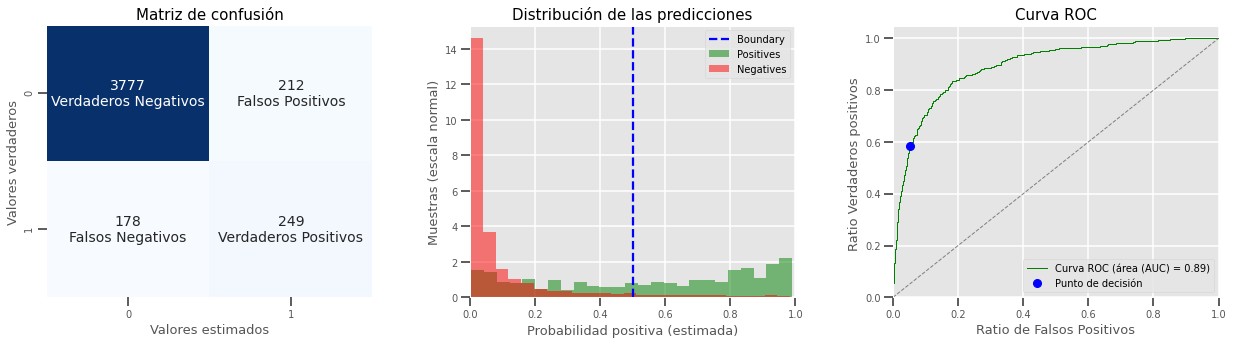

In [ ]:
##Evaluación para el mes de enero
X_test_p =  df_train[(df_train.mes_inicial==13)] 
y_test_p = X_test_p[['ID_PAGOS']]
X_test_p = X_test_p.drop("ID_PAGOS", axis=1)
print_score(model_xgb, X_test_p, y_test_p, X_test_p, y_test_p, train=False, valid=True)
###################################################################################################

F1 = evalBinaryClassifier(model_xgb, X_test_p, y_test_p)

In [ ]:
y_test_pred = model_xgb.predict(X_test_p)
p = model_xgb.predict_proba(X_test_p)
fp_rates, tp_rates, _ = roc_curve(y_test_p,p[:,1])
roc_auc = auc(fp_rates, tp_rates)
resultados_eval.loc['Resultados_X_test_enero','Precision'] = precision_score(y_test_p, y_test_pred )
resultados_eval.loc['Resultados_X_test_enero','Recall'] = recall_score(y_test_p, y_test_pred )
resultados_eval.loc['Resultados_X_test_enero','ROC_AUC'] = roc_auc_score(y_test_p, y_test_pred )
resultados_eval.loc['Resultados_X_test_enero', 'F1_Score'] = f1_score(y_test_p, y_test_pred )
resultados_eval.loc['Resultados_X_test_enero', 'RMSE'] =np.sqrt( mean_squared_error(y_test_p, y_test_pred ))
resultados_eval.loc['Resultados_X_test_enero', 'AUC'] = roc_auc
resultados_eval.loc['Resultados_X_test_enero', 'Accuracy'] = accuracy_score(y_test_p, y_test_pred)

In [ ]:
resultados_eval

Precision    Recall   ROC_AUC  F1_Score      RMSE  \
Resultados_X_train          0.552446  0.965892  0.943794  0.702878  0.272551   
Resultados_X_val            0.446331  0.738956  0.823635  0.556522  0.327237   
Resultados_X_test_enero     0.498106  0.615925  0.774746  0.550785  0.311684   
Resultados_X_test_febrero        NaN       NaN       NaN       NaN       NaN   

                                AUC  Accuracy  
Resultados_X_train         0.980581  0.925716  
Resultados_X_val           0.911541  0.892916  
Resultados_X_test_enero    0.901131  0.902853  
Resultados_X_test_febrero       NaN       NaN

In [ ]:
resultados_eval.to_csv( ruta+ "/tabla_desempeño_mipyme9999.csv", index=False)

**Resultados Febrero**

*Para validar el modelo en febrero cargamos el modelo entrenado anteriormente*

In [ ]:
model_xgb = pickle.load(open(ruta+ "/modelo_xgb_mipyme9999.sav", 'rb'))
#####################Cargamos el esquema de entrenamiento para darselo al marco de datos nuevo

esquema_train = pd.read_csv(ruta+"esquema_de_entrenamiento_mipyme9999.csv")
columns_train = esquema_train.columns


*Repetimos un procedimieno análogo al descrito anteriormente para poder evaluar los datos de febrero. Nota debemos crear df_train que se crea en la primera linea de este modelo, esta linea del código da la estructura para evaluar nuestros datos.*

In [ ]:
##Evaluación para el mes de Febrero
X_test_p =  df_train[(df_train.mes_inicial==14)] 
y_test_p = X_test_p[['ID_PAGOS']]
X_test_p = X_test_p.drop("ID_PAGOS", axis=1)
print_score(model_xgb, X_test_p, y_test_p, X_test_p, y_test_p, train=False, valid=True)
###################################################################################################

F1 = evalBinaryClassifier(model_xgb, X_test_p, y_test_p)

In [ ]:
resultados_eval = pd.read_csv( ruta+ "/tabla_desempeño_mipyme9999.csv")
y_test_pred = model_xgb.predict(X_test_p.values)
p = model_xgb.predict_proba(X_test_p.values)
fp_rates, tp_rates, _ = roc_curve(y_test_p.values,p[:,1])
roc_auc = auc(fp_rates, tp_rates)
resultados_eval.loc['Resultados_X_test_febrero','Precision'] = precision_score(y_test_p.values, y_test_pred )
resultados_eval.loc['Resultados_X_test_febrero','Recall'] = recall_score(y_test_p.values, y_test_pred )
resultados_eval.loc['Resultados_X_test_febrero','ROC_AUC'] = roc_auc_score(y_test_p.values, y_test_pred )
resultados_eval.loc['Resultados_X_test_febrero', 'F1_Score'] = f1_score(y_test_p.values, y_test_pred )
resultados_eval.loc['Resultados_X_test_febrero', 'RMSE'] =np.sqrt( mean_squared_error(y_test_p.values, y_test_pred ))
resultados_eval.loc['Resultados_X_test_febrero', 'AUC'] = roc_auc
resultados_eval.loc['Resultados_X_test_febrero', 'Accuracy'] = accuracy_score(y_test_p.values, y_test_pred)
resultados_eval = resultados_eval.drop(3)
resultados_eval = resultados_eval.rename(index ={0:'Resultados_X_train', 1:'Resultados_X_Val', 2:'Resultados_X_test_enero'})
resultados_eval.loc['Modelo'] ='Mipyme9999'



In [ ]:
resultados_eval

In [ ]:
resultados_eval.to_csv( ruta+ "/tabla_desempeño_mipyme9999_feb.csv")

**¿Cómo está aprendiendo el modelo?**

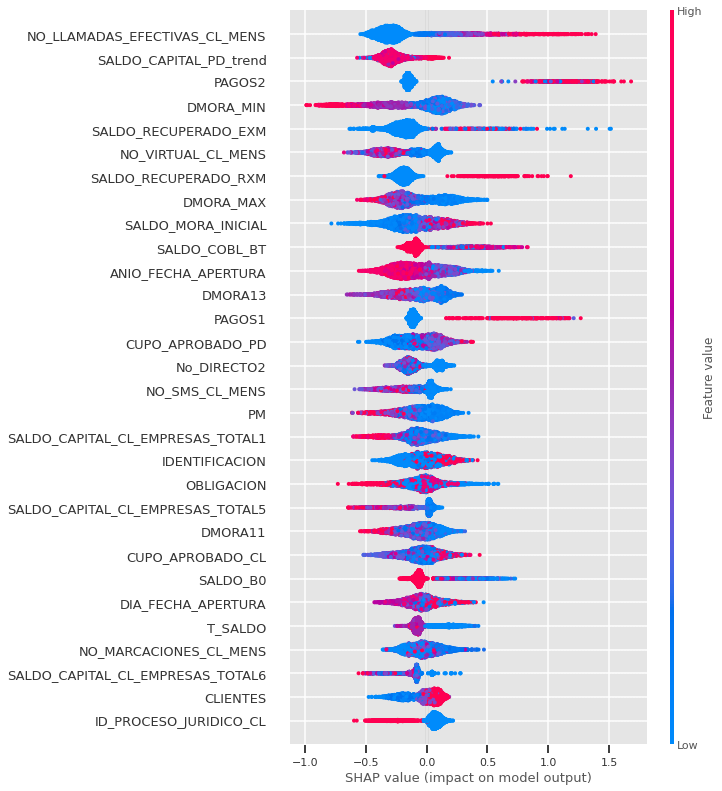

In [ ]:
explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(X_test_p)
shap.summary_plot(shap_values, X_test_p, max_display=30, feature_names=df_train.drop(['ID_PAGOS'], axis=1).columns)

#Pyme Pequeña

El subsegmento Pyme Pequeña es obtenido mediante la variable *SUBSEGMENTO* de la base de datos de T_kobra. A continuación también podemos observar la volumetría de los datos disponibles para modelar. Este segmento es el segundo con más datos. Esta volumetría hace parte de la recolección de datos entre las fechas (Junio 2020- Enero 2021)

Text(0, 0.5, 'Cantidad')

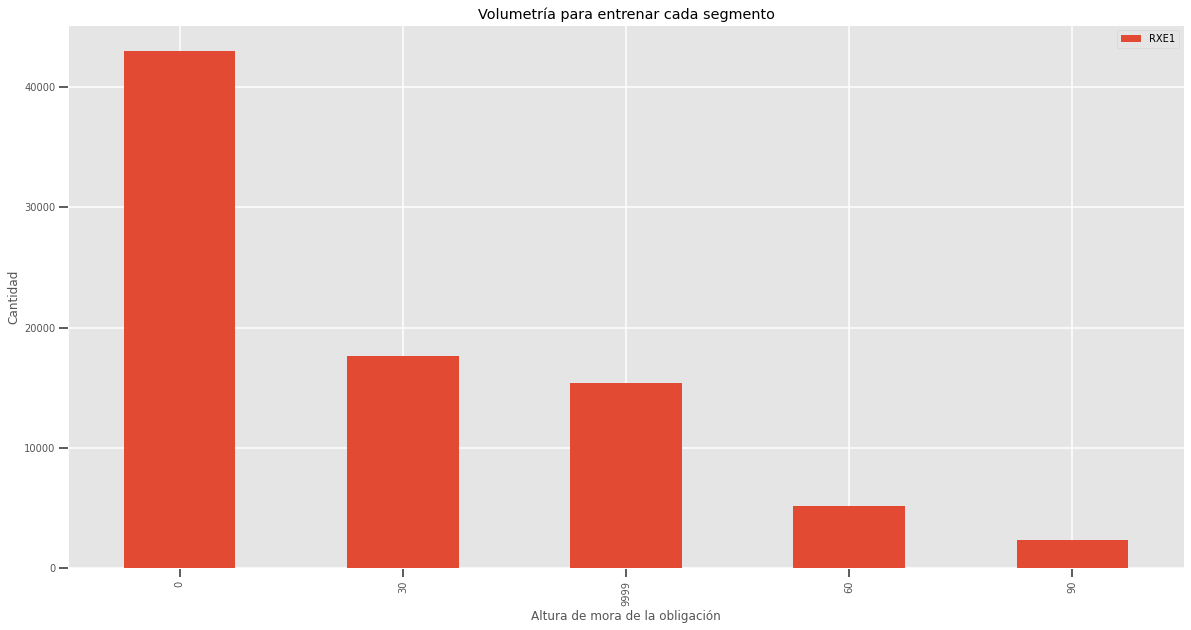

In [74]:
pd.DataFrame(df[(df.SUBSEGMENTO=='Pyme Pequeña')].RXE1.value_counts()).plot(kind='bar')
plt.title('Volumetría para entrenar cada segmento')
plt.xlabel('Altura de mora de la obligación')
plt.ylabel('Cantidad')

**Pyme Pequeña RXE1==0**
-----------------------------------------------------

In [21]:
#@title Segmentación Pyme : Pyme Pequeña 0
df_train = df[(df.SUBSEGMENTO=='Pyme Pequeña') & (df.RXE1==0)]

df_train = df_train.drop(['SUBSEGMENTO', 'RXE1'],axis=1)
df_train = pd.get_dummies(df_train)
df_train = shuffle(df_train)

#Entrenamos hasta el mes de diciembre para realizar las pruebas en: Enero y Febrero
X = df_train[  (df_train.mes_inicial!=14) & (df_train.mes_inicial!=13)]
y = X[['ID_PAGOS']]
X = X.drop("ID_PAGOS", axis=1)
###############################################################

In [27]:
y.value_counts()

ID_PAGOS
0           26217
1           10842
dtype: int64

Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:  5.5min remaining:    0.0s
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:  5.5min finished


[0]	validation_0-error:0.198435	validation_0-logloss:0.662423	validation_1-error:0.191851	validation_1-logloss:0.661687
[1]	validation_0-error:0.202483	validation_0-logloss:0.632708	validation_1-error:0.196573	validation_1-logloss:0.631823
[2]	validation_0-error:0.188485	validation_0-logloss:0.606308	validation_1-error:0.188478	validation_1-logloss:0.60574
[3]	validation_0-error:0.187641	validation_0-logloss:0.585907	validation_1-error:0.18497	validation_1-logloss:0.585079
[4]	validation_0-error:0.21186	validation_0-logloss:0.565074	validation_1-error:0.213168	validation_1-logloss:0.564229
[5]	validation_0-error:0.184403	validation_0-logloss:0.547288	validation_1-error:0.182137	validation_1-logloss:0.54656
[6]	validation_0-error:0.182244	validation_0-logloss:0.533702	validation_1-error:0.181732	validation_1-logloss:0.533235
[7]	validation_0-error:0.1813	validation_0-logloss:0.525334	validation_1-error:0.181732	validation_1-logloss:0.524974
[8]	validation_0-error:0.182514	validation_0-l

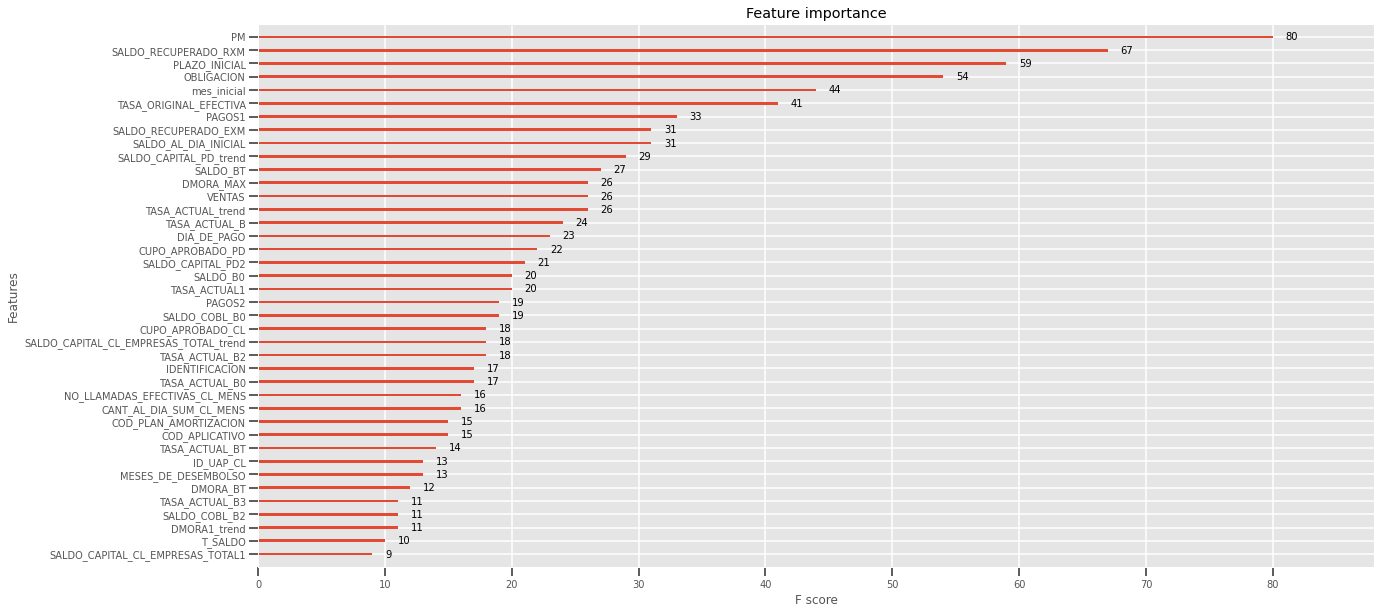

In [22]:
%%time
#################################### Balanceo de datos


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = seed, shuffle=True, stratify=y)

weight_class=y_train.ID_PAGOS.value_counts()[0]/y_train.ID_PAGOS.value_counts()[1] #(segun la documentacion de xgboost sum(negative instances) / sum(positive instances)




######################Modelado Xgboost


model_xgb = model_xgboost(X_train, y_train, X_test, y_test, weight=weight_class ,grid_hiper=True)

%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 10.0)
sns.set_context("talk", font_scale=0.6)
plt.style.use('ggplot')
plot_importance(model_xgb, max_num_features= 40)

filename = ruta+ "/modelo_xgb_pymepequeña0.sav"
pickle.dump(model_xgb, open(filename, 'wb'))

##############################################################################################
###################################################################################################
print_score(model_xgb, X_train, y_train, X_test, y_test, train=True)
print_score(model_xgb, X_train, y_train, X_test, y_test, train=False)

**Función de pérdida y error**

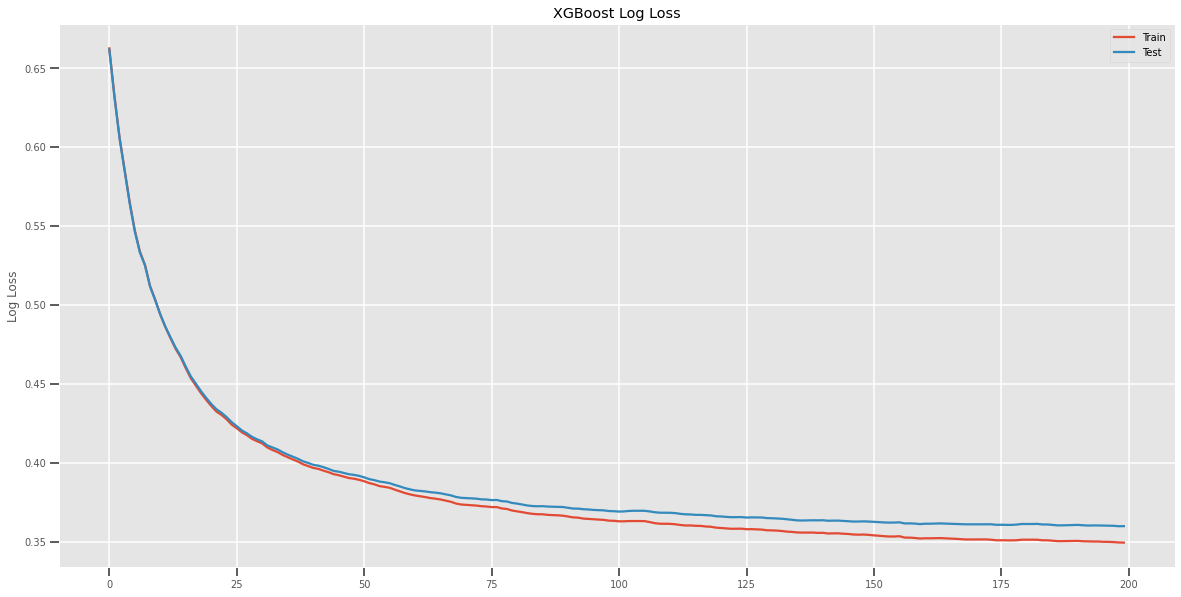

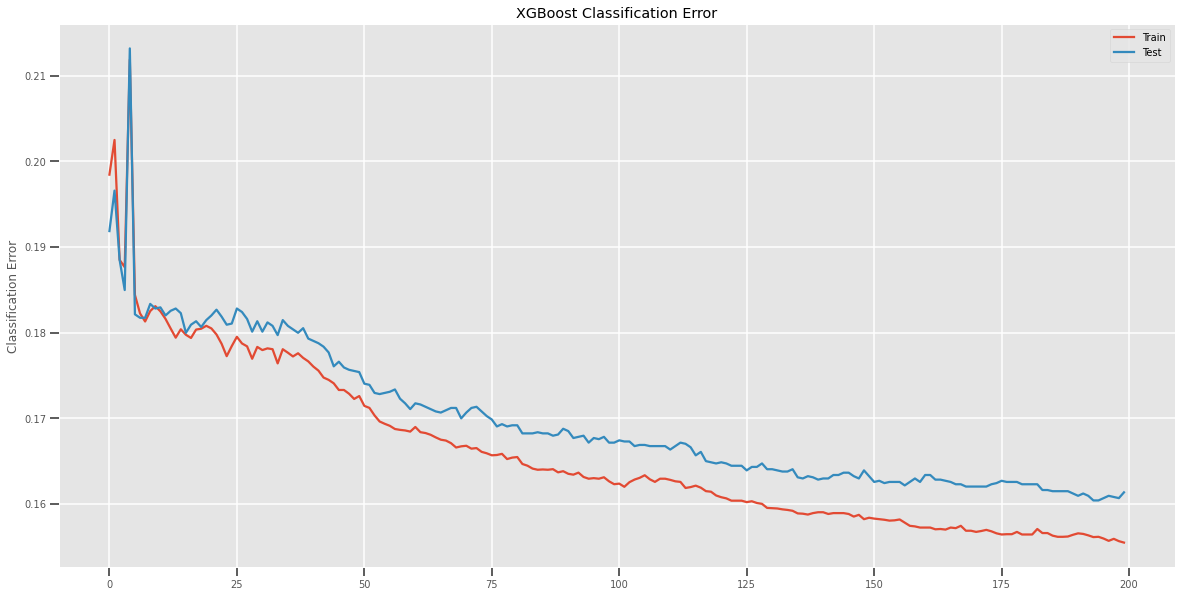

In [23]:
# retrieve performance metrics
results = model_xgb.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

In [28]:
#Dataframe de resultados

idx= ['Resultados_X_train', 'Resultados_X_val', 'Resultados_X_test_enero', 'Resultados_X_test_febrero']


y_train_pred = model_xgb.predict(X_train)

p = model_xgb.predict_proba(X_train)
fp_rates, tp_rates, _ = roc_curve(y_train,p[:,1])
roc_auc = auc(fp_rates, tp_rates)

resultados_eval = pd.DataFrame(index=idx)
resultados_eval.loc['Resultados_X_train','Precision'] = precision_score(y_train, y_train_pred )
resultados_eval.loc['Resultados_X_train','Recall'] = recall_score(y_train, y_train_pred )
resultados_eval.loc['Resultados_X_train','ROC_AUC'] = roc_auc_score(y_train, y_train_pred )
resultados_eval.loc['Resultados_X_train', 'F1_Score'] = f1_score(y_train, y_train_pred )
resultados_eval.loc['Resultados_X_train', 'RMSE'] =np.sqrt( mean_squared_error(y_train, y_train_pred ))
resultados_eval.loc['Resultados_X_train', 'AUC'] = roc_auc
resultados_eval.loc['Resultados_X_train', 'Accuracy'] = accuracy_score(y_train, y_train_pred )

#------------------------------------------------------------------------------------------------------------
#Resultados de validación
#------------------------------------------------------------------------------------------------------------

y_test_pred = model_xgb.predict(X_test)
p = model_xgb.predict_proba(X_test)
fp_rates, tp_rates, _ = roc_curve(y_test,p[:,1])
roc_auc = auc(fp_rates, tp_rates)

resultados_eval.loc['Resultados_X_val','Precision'] = precision_score(y_test, y_test_pred )
resultados_eval.loc['Resultados_X_val','Recall'] = recall_score(y_test, y_test_pred )
resultados_eval.loc['Resultados_X_val','ROC_AUC'] = roc_auc_score(y_test, y_test_pred )
resultados_eval.loc['Resultados_X_val', 'F1_Score'] = f1_score(y_test, y_test_pred )
resultados_eval.loc['Resultados_X_val', 'RMSE'] =np.sqrt( mean_squared_error(y_test, y_test_pred ))
resultados_eval.loc['Resultados_X_val', 'AUC'] = roc_auc
resultados_eval.loc['Resultados_X_val', 'Accuracy'] = accuracy_score(y_test, y_test_pred)

In [29]:
## Mejores parámetros para este modelo
model_xgb

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5,
              early_stopping_rounds=10, eta=0.3,
              eval_metric=['error', 'logloss'], gamma=10, learning_rate=0.1,
              max_delta_step=9, max_depth=4, min_child_weight=8, missing=None,
              n_estimators=200, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=25,
              reg_lambda=12, sampling_method='gradient_based',
              scale_pos_weight=2.417915609868573, seed=None, silent=None,
              subsample=0.6, verbosity=1)

**Resultados Enero**

Resultados de validación:

accuracy score: 0.8500

Reporte de clasificación: 
               precision    recall  f1-score   support

           0       0.86      0.90      0.88      3578
           1       0.83      0.78      0.81      2367

    accuracy                           0.85      5945
   macro avg       0.85      0.84      0.84      5945
weighted avg       0.85      0.85      0.85      5945


Confusion Matrix: 
 [[3205  373]
 [ 519 1848]]

RMSE 
0.3873526199016335

MSLE 
0.07208815616737352

F1-score 
0.8055797733217088

Recall 
0.7807351077313055

Presicion 
0.8320576316974336



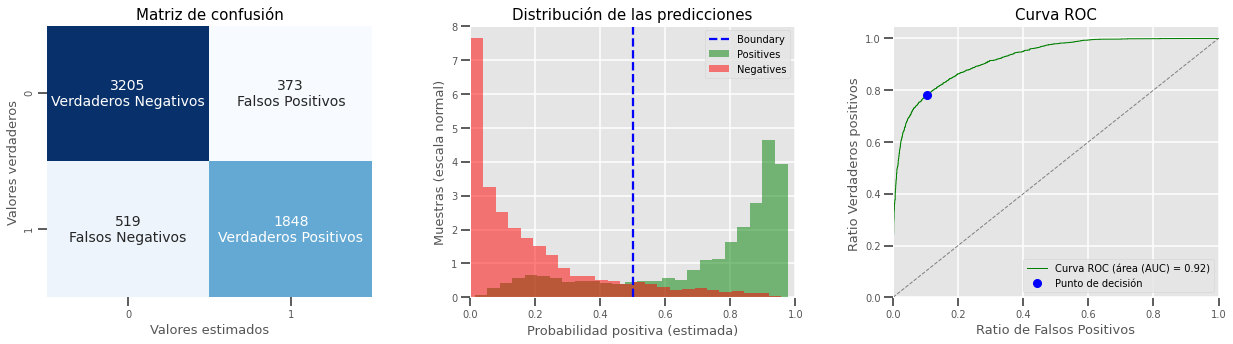

In [30]:
##Evaluación para el mes de enero
X_test_p =  df_train[(df_train.mes_inicial==13)] 
y_test_p = X_test_p[['ID_PAGOS']]
X_test_p = X_test_p.drop("ID_PAGOS", axis=1)

print_score(model_xgb, X_test_p, y_test_p, X_test_p, y_test_p, train=False, valid=True)
###################################################################################################

F1 = evalBinaryClassifier(model_xgb, X_test_p, y_test_p)

In [31]:
y_test_pred = model_xgb.predict(X_test_p)
p = model_xgb.predict_proba(X_test_p)
fp_rates, tp_rates, _ = roc_curve(y_test_p,p[:,1])
roc_auc = auc(fp_rates, tp_rates)
resultados_eval.loc['Resultados_X_test_enero','Precision'] = precision_score(y_test_p, y_test_pred )
resultados_eval.loc['Resultados_X_test_enero','Recall'] = recall_score(y_test_p, y_test_pred )
resultados_eval.loc['Resultados_X_test_enero','ROC_AUC'] = roc_auc_score(y_test_p, y_test_pred )
resultados_eval.loc['Resultados_X_test_enero', 'F1_Score'] = f1_score(y_test_p, y_test_pred )
resultados_eval.loc['Resultados_X_test_enero', 'RMSE'] =np.sqrt( mean_squared_error(y_test_p, y_test_pred ))
resultados_eval.loc['Resultados_X_test_enero', 'AUC'] = roc_auc
resultados_eval.loc['Resultados_X_test_enero', 'Accuracy'] = accuracy_score(y_test_p, y_test_pred)

In [32]:
resultados_eval

Precision    Recall   ROC_AUC  F1_Score      RMSE  \
Resultados_X_train          0.694413  0.836754  0.842231  0.758967  0.394330   
Resultados_X_val            0.682844  0.837177  0.838211  0.752176  0.401696   
Resultados_X_test_enero     0.832058  0.780735  0.838243  0.805580  0.387353   
Resultados_X_test_febrero        NaN       NaN       NaN       NaN       NaN   

                                AUC  Accuracy  
Resultados_X_train         0.926097  0.844504  
Resultados_X_val           0.919854  0.838640  
Resultados_X_test_enero    0.924010  0.849958  
Resultados_X_test_febrero       NaN       NaN

In [33]:
resultados_eval.to_csv( ruta+ "/tabla_desempeño_pymep0.csv", index=False)

**Resultados Febrero**

*Para validar el modelo en febrero cargamos el modelo entrenado anteriormente*

In [ ]:
model_xgb = pickle.load(open(ruta+ "/modelo_xgb_pymepequeña0.sav", 'rb'))

#####################Cargamos el esquema de entrenamiento para darselo al marco de datos nuevo

esquema_train = pd.read_csv(ruta+"esquema_de_entrenamiento_pymep0.csv")
columns_train = esquema_train.columns

*Repetimos un procedimieno análogo al descrito anteriormente para poder evaluar los datos de febrero. Nota debemos crear df_train que se crea en la primera linea de este modelo, esta linea del código da la estructura para evaluar nuestros datos.*

In [ ]:
##Evaluación para el mes de enero
X_test_p =  df_train[(df_train.mes_inicial==14)] 
y_test_p = X_test_p[['ID_PAGOS']]
X_test_p = X_test_p.drop("ID_PAGOS", axis=1)

print_score(model_xgb, X_test_p, y_test_p, X_test_p, y_test_p, train=False, valid=True)
###################################################################################################

F1 = evalBinaryClassifier(model_xgb, X_test_p, y_test_p)

In [ ]:
resultados_eval = pd.read_csv( ruta+ "/tabla_desempeño_pymep0.csv")
y_test_pred = model_xgb.predict(X_test_p.values)
p = model_xgb.predict_proba(X_test_p.values)
fp_rates, tp_rates, _ = roc_curve(y_test_p.values,p[:,1])
roc_auc = auc(fp_rates, tp_rates)
resultados_eval.loc['Resultados_X_test_febrero','Precision'] = precision_score(y_test_p.values, y_test_pred )
resultados_eval.loc['Resultados_X_test_febrero','Recall'] = recall_score(y_test_p.values, y_test_pred )
resultados_eval.loc['Resultados_X_test_febrero','ROC_AUC'] = roc_auc_score(y_test_p.values, y_test_pred )
resultados_eval.loc['Resultados_X_test_febrero', 'F1_Score'] = f1_score(y_test_p.values, y_test_pred )
resultados_eval.loc['Resultados_X_test_febrero', 'RMSE'] =np.sqrt( mean_squared_error(y_test_p.values, y_test_pred ))
resultados_eval.loc['Resultados_X_test_febrero', 'AUC'] = roc_auc
resultados_eval.loc['Resultados_X_test_febrero', 'Accuracy'] = accuracy_score(y_test_p.values, y_test_pred)
resultados_eval = resultados_eval.drop(3)
resultados_eval = resultados_eval.rename(index ={0:'Resultados_X_train', 1:'Resultados_X_Val', 2:'Resultados_X_test_enero'})
resultados_eval.loc['Modelo'] ='Pyme Pequeña 0'


In [ ]:
resultados_eval

In [ ]:
resultados_eval.to_csv( ruta+ "/tabla_desempeño_pymep0_feb.csv")


**¿Cómo está aprendiendo el modelo?**

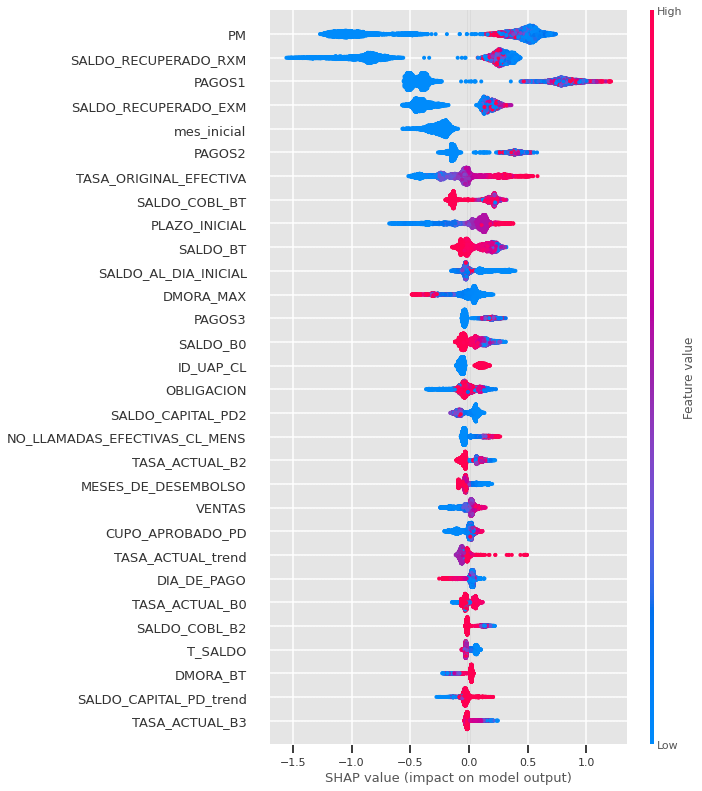

In [34]:
explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(X_test_p)
shap.summary_plot(shap_values, X_test_p, max_display=30, feature_names=df_train.drop(['ID_PAGOS'], axis=1).columns)

**Pyme Pequeña RXE1==30**
-----------------------------------

In [39]:
#@title Segmentación Pyme : Pyme Pequeña 30
df_train = df[(df.SUBSEGMENTO=='Pyme Pequeña') & (df.RXE1==30)]

df_train = df_train.drop(['SUBSEGMENTO', 'RXE1'],axis=1)
df_train = pd.get_dummies(df_train)
df_train = shuffle(df_train)

#Entrenamos hasta el mes de diciembre para realizar las pruebas en: Enero y Febrero
X = df_train[  (df_train.mes_inicial!=14) & (df_train.mes_inicial!=13)]
y = X[['ID_PAGOS']]
X = X.drop("ID_PAGOS", axis=1)
###############################################################

In [38]:
y.value_counts()

ID_PAGOS
1           8522
0           6430
dtype: int64

Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:  2.3min remaining:    0.0s
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:  2.3min finished


[0]	validation_0-error:0.333835	validation_0-logloss:0.678984	validation_1-error:0.340689	validation_1-logloss:0.679937
[1]	validation_0-error:0.200652	validation_0-logloss:0.643178	validation_1-error:0.207957	validation_1-logloss:0.644393
[2]	validation_0-error:0.21938	validation_0-logloss:0.629634	validation_1-error:0.227349	validation_1-logloss:0.631231
[3]	validation_0-error:0.201655	validation_0-logloss:0.603442	validation_1-error:0.210966	validation_1-logloss:0.605522
[4]	validation_0-error:0.197642	validation_0-logloss:0.579355	validation_1-error:0.204948	validation_1-logloss:0.581152
[5]	validation_0-error:0.193295	validation_0-logloss:0.562644	validation_1-error:0.198596	validation_1-logloss:0.564363
[6]	validation_0-error:0.194967	validation_0-logloss:0.545659	validation_1-error:0.19893	validation_1-logloss:0.547156
[7]	validation_0-error:0.193797	validation_0-logloss:0.531146	validation_1-error:0.196924	validation_1-logloss:0.532879
[8]	validation_0-error:0.19388	validation_

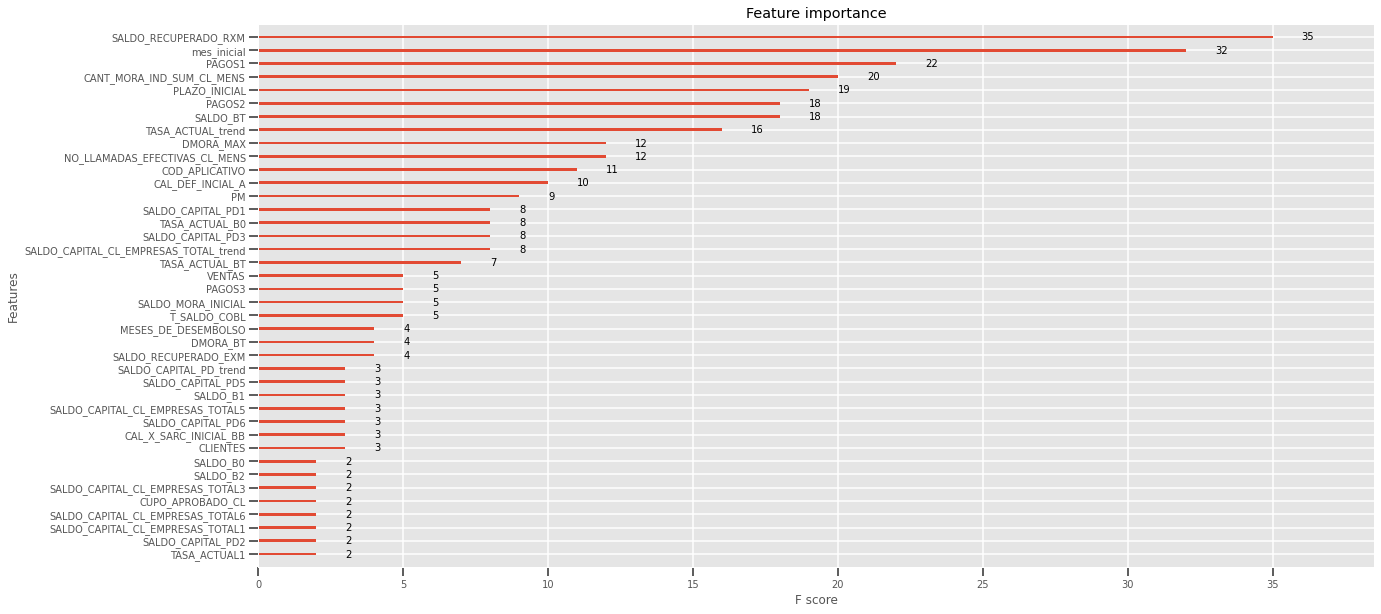

In [42]:
%%time

#################################### Balanceo de datos



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = seed, shuffle=True, stratify=y)

weight_class=y_train.ID_PAGOS.value_counts()[1]/y_train.ID_PAGOS.value_counts()[0]


######################Modelado Xgboost


model_xgb = model_xgboost(X_train, y_train, X_test, y_test, weight=weight_class ,grid_hiper=True)

%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 10.0)
sns.set_context("talk", font_scale=0.6)
plt.style.use('ggplot')
plot_importance(model_xgb, max_num_features= 40)

filename = ruta+ "/modelo_xgb_pymepequeña30.sav"
pickle.dump(model_xgb, open(filename, 'wb'))

##############################################################################################
###################################################################################################
print_score(model_xgb, X_train, y_train, X_test, y_test, train=True)
print_score(model_xgb, X_train, y_train, X_test, y_test, train=False)

**Función de pérdida y error**

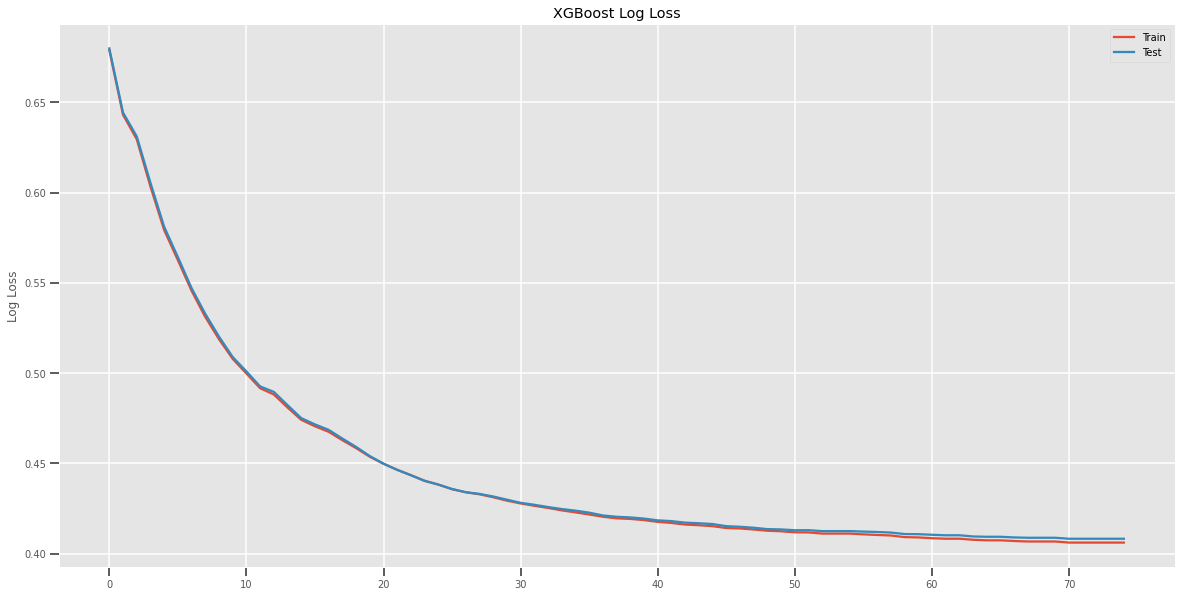

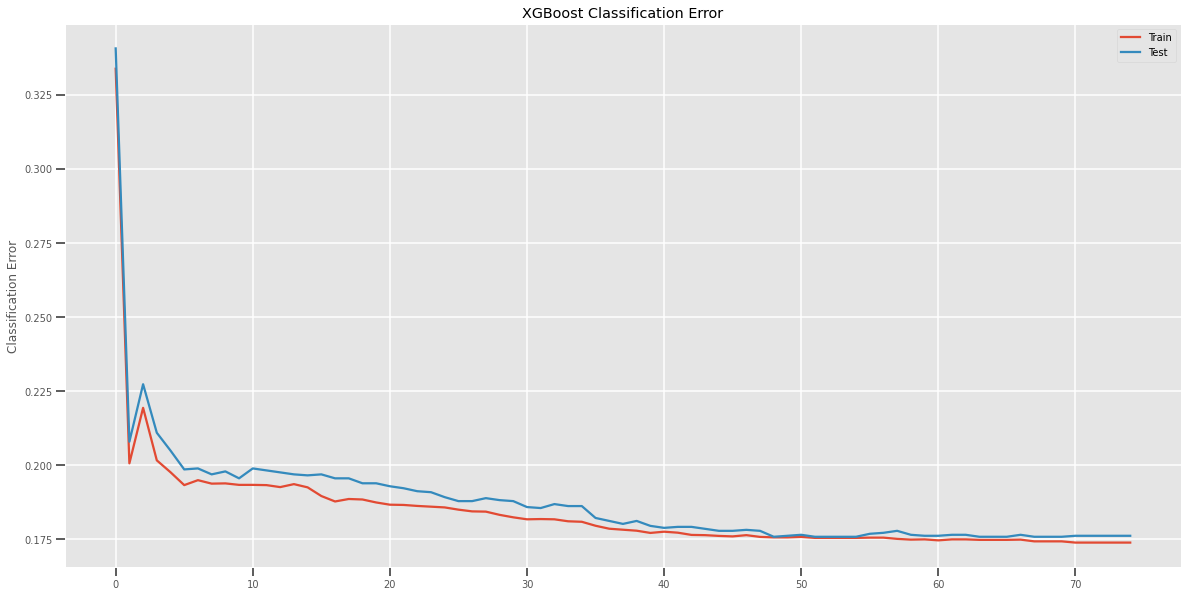

In [43]:
# retrieve performance metrics
results = model_xgb.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

In [44]:
#Dataframe de resultados

idx= ['Resultados_X_train', 'Resultados_X_val', 'Resultados_X_test_enero', 'Resultados_X_test_febrero']


y_train_pred = model_xgb.predict(X_train)

p = model_xgb.predict_proba(X_train)
fp_rates, tp_rates, _ = roc_curve(y_train,p[:,1])
roc_auc = auc(fp_rates, tp_rates)

resultados_eval = pd.DataFrame(index=idx)
resultados_eval.loc['Resultados_X_train','Precision'] = precision_score(y_train, y_train_pred )
resultados_eval.loc['Resultados_X_train','Recall'] = recall_score(y_train, y_train_pred )
resultados_eval.loc['Resultados_X_train','ROC_AUC'] = roc_auc_score(y_train, y_train_pred )
resultados_eval.loc['Resultados_X_train', 'F1_Score'] = f1_score(y_train, y_train_pred )
resultados_eval.loc['Resultados_X_train', 'RMSE'] =np.sqrt( mean_squared_error(y_train, y_train_pred ))
resultados_eval.loc['Resultados_X_train', 'AUC'] = roc_auc
resultados_eval.loc['Resultados_X_train', 'Accuracy'] = accuracy_score(y_train, y_train_pred )

#------------------------------------------------------------------------------------------------------------
#Resultados de validación
#------------------------------------------------------------------------------------------------------------

y_test_pred = model_xgb.predict(X_test)
p = model_xgb.predict_proba(X_test)
fp_rates, tp_rates, _ = roc_curve(y_test,p[:,1])
roc_auc = auc(fp_rates, tp_rates)

resultados_eval.loc['Resultados_X_val','Precision'] = precision_score(y_test, y_test_pred )
resultados_eval.loc['Resultados_X_val','Recall'] = recall_score(y_test, y_test_pred )
resultados_eval.loc['Resultados_X_val','ROC_AUC'] = roc_auc_score(y_test, y_test_pred )
resultados_eval.loc['Resultados_X_val', 'F1_Score'] = f1_score(y_test, y_test_pred )
resultados_eval.loc['Resultados_X_val', 'RMSE'] =np.sqrt( mean_squared_error(y_test, y_test_pred ))
resultados_eval.loc['Resultados_X_val', 'AUC'] = roc_auc
resultados_eval.loc['Resultados_X_val', 'Accuracy'] = accuracy_score(y_test, y_test_pred)

In [45]:
## Mejores parámetros para este modelo
model_xgb

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6,
              early_stopping_rounds=10, eta=0.4,
              eval_metric=['error', 'logloss'], gamma=15, learning_rate=0.1,
              max_delta_step=2, max_depth=4, min_child_weight=5, missing=None,
              n_estimators=75, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=18,
              reg_lambda=12, sampling_method='gradient_based',
              scale_pos_weight=1.3252332814930015, seed=None, silent=None,
              subsample=0.9, verbosity=1)

**Resultados Enero**

Resultados de validación:

accuracy score: 0.7855

Reporte de clasificación: 
               precision    recall  f1-score   support

           0       0.62      0.79      0.69       835
           1       0.89      0.78      0.83      1864

    accuracy                           0.79      2699
   macro avg       0.76      0.79      0.76      2699
weighted avg       0.81      0.79      0.79      2699


Confusion Matrix: 
 [[ 657  178]
 [ 401 1463]]

RMSE 
0.4631672459705065

MSLE 
0.10306865322661675

F1-score 
0.8348074179743225

Recall 
0.7848712446351931

Presicion 
0.8915295551492992



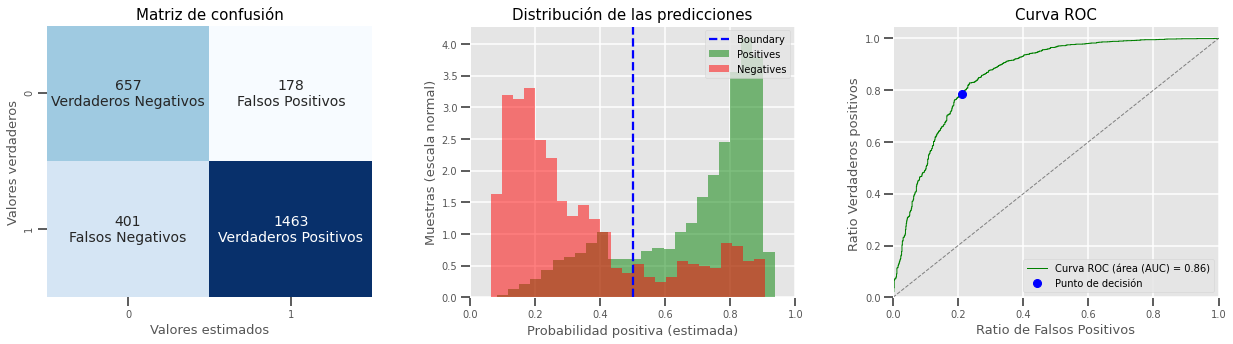

In [46]:
##Evaluación para el mes de enero
X_test_p =  df_train[(df_train.mes_inicial==13)] 
y_test_p = X_test_p[['ID_PAGOS']]
X_test_p = X_test_p.drop("ID_PAGOS", axis=1)

print_score(model_xgb, X_test_p, y_test_p, X_test_p, y_test_p, train=False, valid=True)
###################################################################################################

F1 = evalBinaryClassifier(model_xgb, X_test_p, y_test_p)

In [47]:
y_test_pred = model_xgb.predict(X_test_p)
p = model_xgb.predict_proba(X_test_p)
fp_rates, tp_rates, _ = roc_curve(y_test_p,p[:,1])
roc_auc = auc(fp_rates, tp_rates)
resultados_eval.loc['Resultados_X_test_enero','Precision'] = precision_score(y_test_p, y_test_pred )
resultados_eval.loc['Resultados_X_test_enero','Recall'] = recall_score(y_test_p, y_test_pred )
resultados_eval.loc['Resultados_X_test_enero','ROC_AUC'] = roc_auc_score(y_test_p, y_test_pred )
resultados_eval.loc['Resultados_X_test_enero', 'F1_Score'] = f1_score(y_test_p, y_test_pred )
resultados_eval.loc['Resultados_X_test_enero', 'RMSE'] =np.sqrt( mean_squared_error(y_test_p, y_test_pred ))
resultados_eval.loc['Resultados_X_test_enero', 'AUC'] = roc_auc
resultados_eval.loc['Resultados_X_test_enero', 'Accuracy'] = accuracy_score(y_test_p, y_test_pred)

In [48]:
resultados_eval

Precision    Recall   ROC_AUC  F1_Score      RMSE  \
Resultados_X_train          0.803615  0.919613  0.810895  0.857710  0.417011   
Resultados_X_val            0.798077  0.924927  0.807331  0.856832  0.419756   
Resultados_X_test_enero     0.891530  0.784871  0.785849  0.834807  0.463167   
Resultados_X_test_febrero        NaN       NaN       NaN       NaN       NaN   

                                AUC  Accuracy  
Resultados_X_train         0.900911  0.826101  
Resultados_X_val           0.899514  0.823805  
Resultados_X_test_enero    0.859141  0.785476  
Resultados_X_test_febrero       NaN       NaN

In [49]:
resultados_eval.to_csv( ruta+ "/tabla_desempeño_pymep30.csv", index=False)

**Resultados Febrero**

*Para validar el modelo en febrero cargamos el modelo entrenado anteriormente*

In [ ]:
model_xgb = pickle.load(open(ruta+ "/modelo_xgb_pymepequeña30.sav", 'rb'))

#####################Cargamos el esquema de entrenamiento para darselo al marco de datos nuevo

esquema_train = pd.read_csv(ruta+"esquema_de_entrenamiento_pymep30.csv")
columns_train = esquema_train.columns

*Repetimos un procedimieno análogo al descrito anteriormente para poder evaluar los datos de febrero. Nota debemos crear df_train que se crea en la primera linea de este modelo, esta linea del código da la estructura para evaluar nuestros datos.*

In [ ]:
##Evaluación para el mes de Febrero
X_test_p =  df_train[(df_train.mes_inicial==14)] 
y_test_p = X_test_p[['ID_PAGOS']]
X_test_p = X_test_p.drop("ID_PAGOS", axis=1)

print_score(model_xgb, X_test_p, y_test_p, X_test_p, y_test_p, train=False, valid=True)
###################################################################################################

F1 = evalBinaryClassifier(model_xgb, X_test_p, y_test_p)

In [ ]:
resultados_eval = pd.read_csv( ruta+ "/tabla_desempeño_pymep30.csv")
y_test_pred = model_xgb.predict(X_test_p.values)
p = model_xgb.predict_proba(X_test_p.values)
fp_rates, tp_rates, _ = roc_curve(y_test_p.values,p[:,1])
roc_auc = auc(fp_rates, tp_rates)
resultados_eval.loc['Resultados_X_test_febrero','Precision'] = precision_score(y_test_p.values, y_test_pred )
resultados_eval.loc['Resultados_X_test_febrero','Recall'] = recall_score(y_test_p.values, y_test_pred )
resultados_eval.loc['Resultados_X_test_febrero','ROC_AUC'] = roc_auc_score(y_test_p.values, y_test_pred )
resultados_eval.loc['Resultados_X_test_febrero', 'F1_Score'] = f1_score(y_test_p.values, y_test_pred )
resultados_eval.loc['Resultados_X_test_febrero', 'RMSE'] =np.sqrt( mean_squared_error(y_test_p.values, y_test_pred ))
resultados_eval.loc['Resultados_X_test_febrero', 'AUC'] = roc_auc
resultados_eval.loc['Resultados_X_test_febrero', 'Accuracy'] = accuracy_score(y_test_p.values, y_test_pred)
resultados_eval = resultados_eval.drop(3)
resultados_eval = resultados_eval.rename(index ={0:'Resultados_X_train', 1:'Resultados_X_Val', 2:'Resultados_X_test_enero'})
resultados_eval.loc['Modelo'] ='Pyme Pequeña 30'

In [ ]:
resultados_eval

In [ ]:
resultados_eval.to_csv( ruta+ "/tabla_desempeño_pymep30_feb.csv")

**¿Cómo está aprendiendo el modelo?**

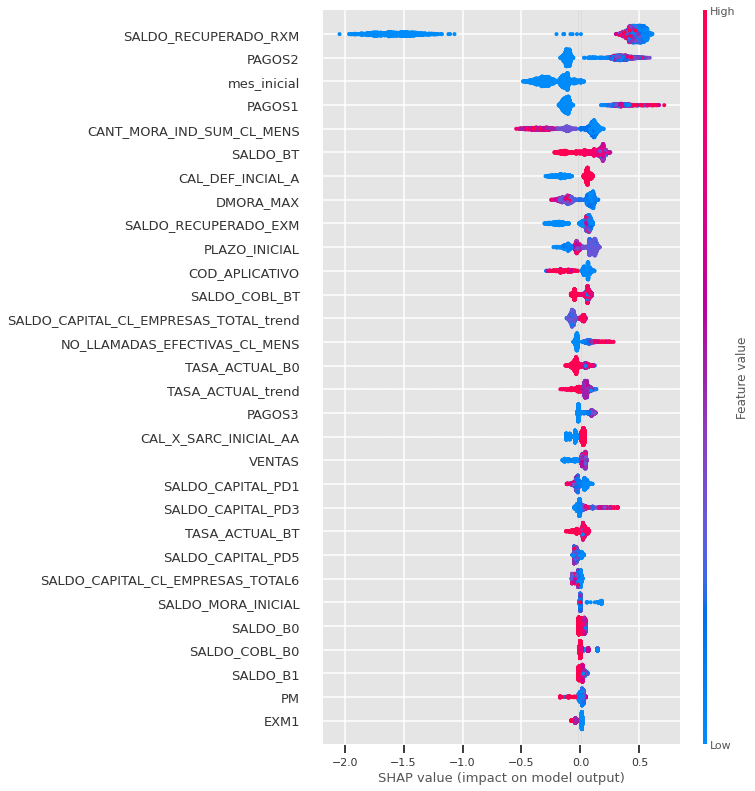

In [50]:
explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(X_test_p)
shap.summary_plot(shap_values, X_test_p, max_display=30, feature_names=df_train.drop(['ID_PAGOS'], axis=1).columns)

**Pyme Pequeña RXE1==60**
--------------------------------------------------------

In [51]:
#@title Segmentación Pyme : Pyme Pequeña 60
df_train = df[(df.SUBSEGMENTO=='Pyme Pequeña') & (df.RXE1==60)]

df_train = df_train.drop(['SUBSEGMENTO', 'RXE1'],axis=1)
df_train = pd.get_dummies(df_train)
df_train = shuffle(df_train)

#Entrenamos hasta el mes de diciembre para realizar las pruebas en: Enero y Febrero
X = df_train[  (df_train.mes_inicial!=14) & (df_train.mes_inicial!=13)]
y = X[['ID_PAGOS']]
X = X.drop("ID_PAGOS", axis=1)
###############################################################

In [52]:
y.value_counts()

ID_PAGOS
0           2607
1           1685
dtype: int64

Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:   33.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:   33.0s finished


[0]	validation_0-error:0.346053	validation_0-logloss:0.684558	validation_1-error:0.381839	validation_1-logloss:0.685984
[1]	validation_0-error:0.200408	validation_0-logloss:0.654156	validation_1-error:0.228172	validation_1-logloss:0.657688
[2]	validation_0-error:0.193708	validation_0-logloss:0.628655	validation_1-error:0.22468	validation_1-logloss:0.633753
[3]	validation_0-error:0.196038	validation_0-logloss:0.606735	validation_1-error:0.225844	validation_1-logloss:0.613811
[4]	validation_0-error:0.190213	validation_0-logloss:0.599454	validation_1-error:0.22468	validation_1-logloss:0.6072
[5]	validation_0-error:0.187882	validation_0-logloss:0.583584	validation_1-error:0.220023	validation_1-logloss:0.592155
[6]	validation_0-error:0.189339	validation_0-logloss:0.571658	validation_1-error:0.216531	validation_1-logloss:0.58136
[7]	validation_0-error:0.189921	validation_0-logloss:0.561912	validation_1-error:0.217695	validation_1-logloss:0.571321
[8]	validation_0-error:0.190213	validation_0-

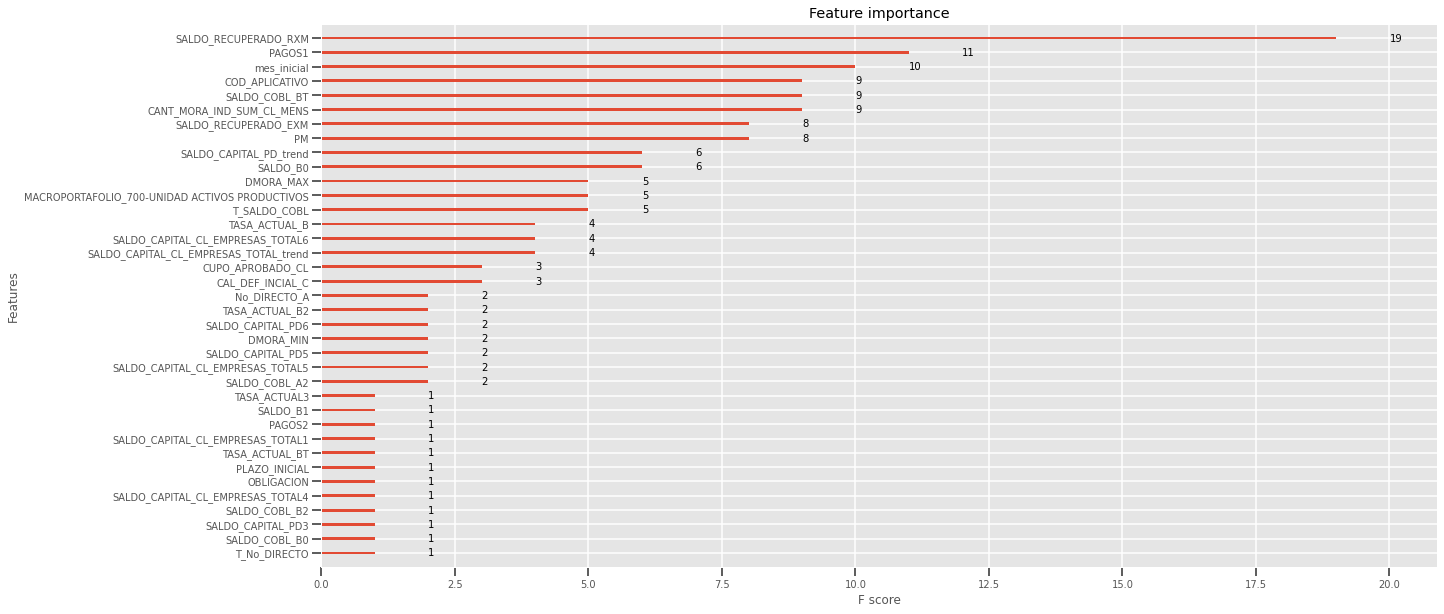

In [53]:
%%time

#################################### Balanceo de datos



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = seed, shuffle=True, stratify=y)

weight_class=y.ID_PAGOS.value_counts()[0]/y.ID_PAGOS.value_counts()[1]


######################Modelado Xgboost


model_xgb = model_xgboost(X_train, y_train, X_test, y_test, weight=weight_class ,grid_hiper=True)

%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 10.0)
sns.set_context("talk", font_scale=0.6)
plt.style.use('ggplot')
plot_importance(model_xgb, max_num_features= 40)

#filename = ruta+ "/modelo_xgb_pymepequeña60.sav"
#pickle.dump(model_xgb, open(filename, 'wb'))

##############################################################################################
###################################################################################################
print_score(model_xgb, X_train, y_train, X_test, y_test, train=True)
print_score(model_xgb, X_train, y_train, X_test, y_test, train=False)

**Función de pérdida y error**

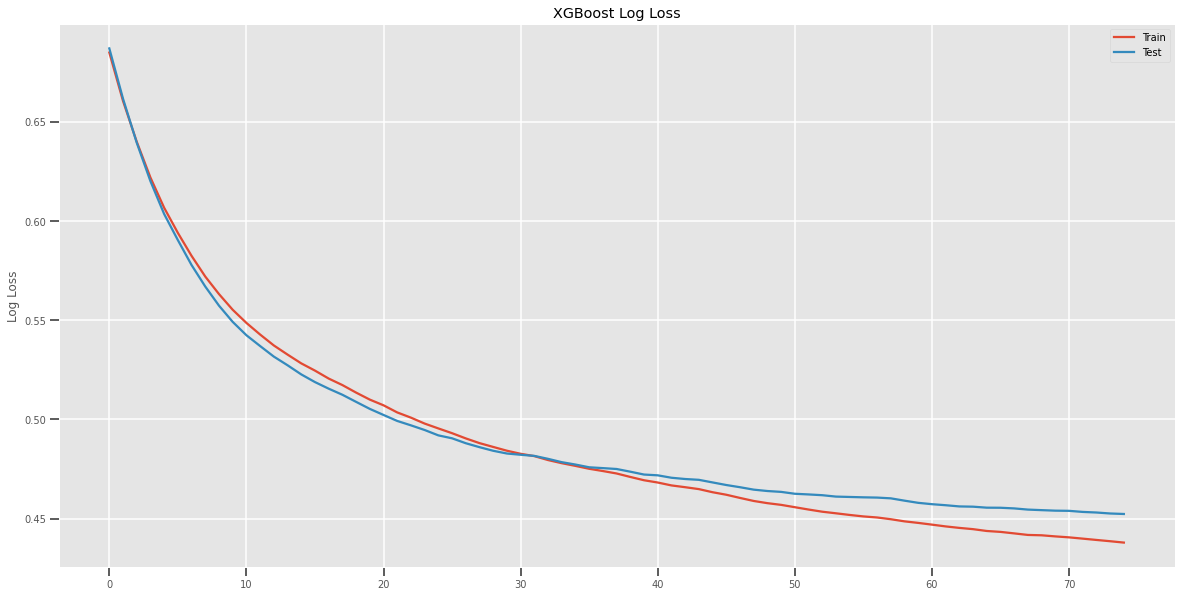

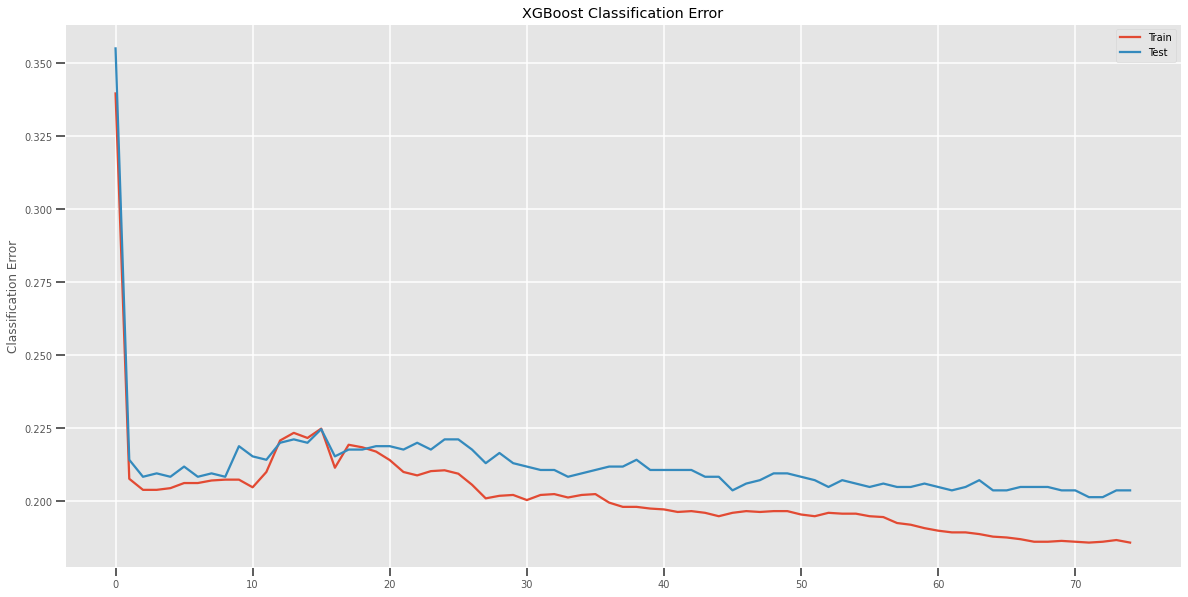

In [ ]:
# retrieve performance metrics
results = model_xgb.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

In [ ]:

#Dataframe de resultados

idx= ['Resultados_X_train', 'Resultados_X_val', 'Resultados_X_test_enero', 'Resultados_X_test_febrero']


y_train_pred = model_xgb.predict(X_train)

p = model_xgb.predict_proba(X_train)
fp_rates, tp_rates, _ = roc_curve(y_train,p[:,1])
roc_auc = auc(fp_rates, tp_rates)

resultados_eval = pd.DataFrame(index=idx)
resultados_eval.loc['Resultados_X_train','Precision'] = precision_score(y_train, y_train_pred )
resultados_eval.loc['Resultados_X_train','Recall'] = recall_score(y_train, y_train_pred )
resultados_eval.loc['Resultados_X_train','ROC_AUC'] = roc_auc_score(y_train, y_train_pred )
resultados_eval.loc['Resultados_X_train', 'F1_Score'] = f1_score(y_train, y_train_pred )
resultados_eval.loc['Resultados_X_train', 'RMSE'] =np.sqrt( mean_squared_error(y_train, y_train_pred ))
resultados_eval.loc['Resultados_X_train', 'AUC'] = roc_auc
resultados_eval.loc['Resultados_X_train', 'Accuracy'] = accuracy_score(y_train, y_train_pred )

#------------------------------------------------------------------------------------------------------------
#Resultados de validación
#------------------------------------------------------------------------------------------------------------

y_test_pred = model_xgb.predict(X_test)
p = model_xgb.predict_proba(X_test)
fp_rates, tp_rates, _ = roc_curve(y_test,p[:,1])
roc_auc = auc(fp_rates, tp_rates)

resultados_eval.loc['Resultados_X_val','Precision'] = precision_score(y_test, y_test_pred )
resultados_eval.loc['Resultados_X_val','Recall'] = recall_score(y_test, y_test_pred )
resultados_eval.loc['Resultados_X_val','ROC_AUC'] = roc_auc_score(y_test, y_test_pred )
resultados_eval.loc['Resultados_X_val', 'F1_Score'] = f1_score(y_test, y_test_pred )
resultados_eval.loc['Resultados_X_val', 'RMSE'] =np.sqrt( mean_squared_error(y_test, y_test_pred ))
resultados_eval.loc['Resultados_X_val', 'AUC'] = roc_auc
resultados_eval.loc['Resultados_X_val', 'Accuracy'] = accuracy_score(y_test, y_test_pred)

In [ ]:
## Mejores parámetros para este modelo
model_xgb

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=10, eval_metric=['error', 'logloss'],
              gamma=1, learning_rate=0.1, max_delta_step=8, max_depth=3,
              min_child_weight=13, missing=None, n_estimators=75, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=27, reg_lambda=40, scale_pos_weight=1.5467359050445104,
              seed=None, silent=None, subsample=0.9, verbosity=1)

**Resultados Enero**

Resultados de validación:

accuracy score: 0.7555

Reporte de clasificación: 
               precision    recall  f1-score   support

           0       0.73      0.95      0.83       529
           1       0.84      0.45      0.58       330

    accuracy                           0.76       859
   macro avg       0.79      0.70      0.71       859
weighted avg       0.77      0.76      0.73       859


Confusion Matrix: 
 [[501  28]
 [182 148]]

RMSE 
0.49443939397966213

MSLE 
0.11745649932808182

F1-score 
0.5849802371541502

Recall 
0.4484848484848485

Presicion 
0.8409090909090909



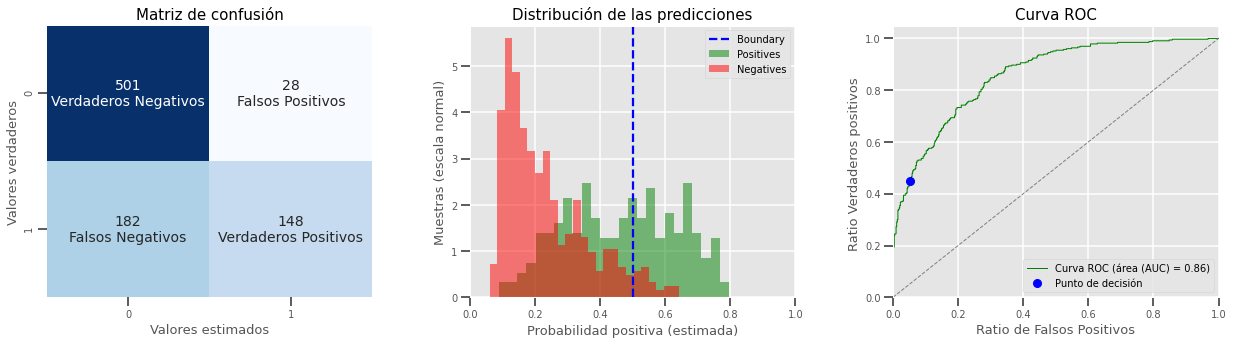

In [ ]:
##Evaluación para el mes de enero
X_test_p =  df_train[(df_train.mes_inicial==13)] 
y_test_p = X_test_p[['ID_PAGOS']]
X_test_p = X_test_p.drop("ID_PAGOS", axis=1)
print_score(model_xgb, X_test_p, y_test_p, X_test_p, y_test_p, train=False, valid=True)
###################################################################################################

F1 = evalBinaryClassifier(model_xgb, X_test_p, y_test_p)

In [ ]:
y_test_pred = model_xgb.predict(X_test_p)
p = model_xgb.predict_proba(X_test_p)
fp_rates, tp_rates, _ = roc_curve(y_test_p,p[:,1])
roc_auc = auc(fp_rates, tp_rates)
resultados_eval.loc['Resultados_X_test_enero','Precision'] = precision_score(y_test_p, y_test_pred )
resultados_eval.loc['Resultados_X_test_enero','Recall'] = recall_score(y_test_p, y_test_pred )
resultados_eval.loc['Resultados_X_test_enero','ROC_AUC'] = roc_auc_score(y_test_p, y_test_pred )
resultados_eval.loc['Resultados_X_test_enero', 'F1_Score'] = f1_score(y_test_p, y_test_pred )
resultados_eval.loc['Resultados_X_test_enero', 'RMSE'] =np.sqrt( mean_squared_error(y_test_p, y_test_pred ))
resultados_eval.loc['Resultados_X_test_enero', 'AUC'] = roc_auc
resultados_eval.loc['Resultados_X_test_enero', 'Accuracy'] = accuracy_score(y_test_p, y_test_pred)

In [ ]:
resultados_eval

Precision    Recall   ROC_AUC  F1_Score      RMSE  \
Resultados_X_train          0.759409  0.838279  0.833288  0.796897  0.409614   
Resultados_X_val            0.733333  0.816024  0.812226  0.772472  0.434271   
Resultados_X_test_enero     0.841530  0.466667  0.705923  0.600390  0.488518   
Resultados_X_test_febrero        NaN       NaN       NaN       NaN       NaN   

                                AUC  Accuracy  
Resultados_X_train         0.908031  0.832217  
Resultados_X_val           0.889949  0.811409  
Resultados_X_test_enero    0.845987  0.761350  
Resultados_X_test_febrero       NaN       NaN

In [ ]:
resultados_eval.to_csv( ruta+ "/tabla_desempeño_pymep60.csv", index=False)

**Resultados Febrero**

*Para validar el modelo en febrero cargamos el modelo entrenado anteriormente*

In [ ]:
model_xgb = pickle.load(open(ruta+ "/modelo_xgb_pymepequeña60.sav", 'rb'))

#####################Cargamos el esquema de entrenamiento para darselo al marco de datos nuevo

esquema_train = pd.read_csv(ruta+"esquema_de_entrenamiento_pymep60.csv")
columns_train = esquema_train.columns


*Repetimos un procedimieno análogo al descrito anteriormente para poder evaluar los datos de febrero. Nota debemos crear df_train que se crea en la primera linea de este modelo, esta linea del código da la estructura para evaluar nuestros datos.*

Resultados de validación:

accuracy score: 0.7623

Reporte de clasificación: 
               precision    recall  f1-score   support

           0       0.71      0.96      0.82       436
           1       0.91      0.52      0.67       359

    accuracy                           0.76       795
   macro avg       0.81      0.74      0.74       795
weighted avg       0.80      0.76      0.75       795


Confusion Matrix: 
 [[418  18]
 [171 188]]

RMSE 
0.48758163322320064

MSLE 
0.11422090519564788

F1-score 
0.6654867256637168

Recall 
0.5236768802228412

Presicion 
0.912621359223301



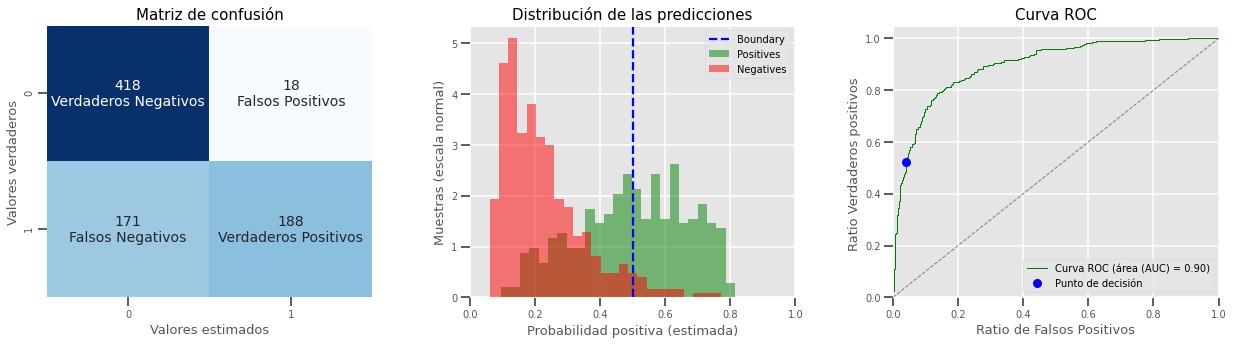

In [ ]:
##Evaluación para el mes de  Febrero
X_test_p =  df_train[(df_train.mes_inicial==14)] 

###Definir esquema
X_test_p = X_test_p[columns_train]
y_test_p = X_test_p[['ID_PAGOS']]
X_test_p = X_test_p.drop("ID_PAGOS", axis=1)

print_score(model_xgb, X_test_p, y_test_p, X_test_p, y_test_p, train=False, valid=True)
###################################################################################################

F1 = evalBinaryClassifier(model_xgb, X_test_p, y_test_p)

In [ ]:
resultados_eval = pd.read_csv( ruta+ "/tabla_desempeño_pymep60.csv")
y_test_pred = model_xgb.predict(X_test_p.values)
p = model_xgb.predict_proba(X_test_p.values)
fp_rates, tp_rates, _ = roc_curve(y_test_p.values,p[:,1])
roc_auc = auc(fp_rates, tp_rates)
resultados_eval.loc['Resultados_X_test_febrero','Precision'] = precision_score(y_test_p.values, y_test_pred )
resultados_eval.loc['Resultados_X_test_febrero','Recall'] = recall_score(y_test_p.values, y_test_pred )
resultados_eval.loc['Resultados_X_test_febrero','ROC_AUC'] = roc_auc_score(y_test_p.values, y_test_pred )
resultados_eval.loc['Resultados_X_test_febrero', 'F1_Score'] = f1_score(y_test_p.values, y_test_pred )
resultados_eval.loc['Resultados_X_test_febrero', 'RMSE'] =np.sqrt( mean_squared_error(y_test_p.values, y_test_pred ))
resultados_eval.loc['Resultados_X_test_febrero', 'AUC'] = roc_auc
resultados_eval.loc['Resultados_X_test_febrero', 'Accuracy'] = accuracy_score(y_test_p.values, y_test_pred)
resultados_eval = resultados_eval.drop(3)
resultados_eval = resultados_eval.rename(index ={0:'Resultados_X_train', 1:'Resultados_X_Val', 2:'Resultados_X_test_enero'})
resultados_eval.loc['Modelo'] ='Pyme Pequeña 60'

In [ ]:
resultados_eval

In [ ]:
resultados_eval.to_csv(ruta+ "/tabla_desempeño_pymep60_feb.csv")

**¿Cómo está aprendiendo el modelo?**

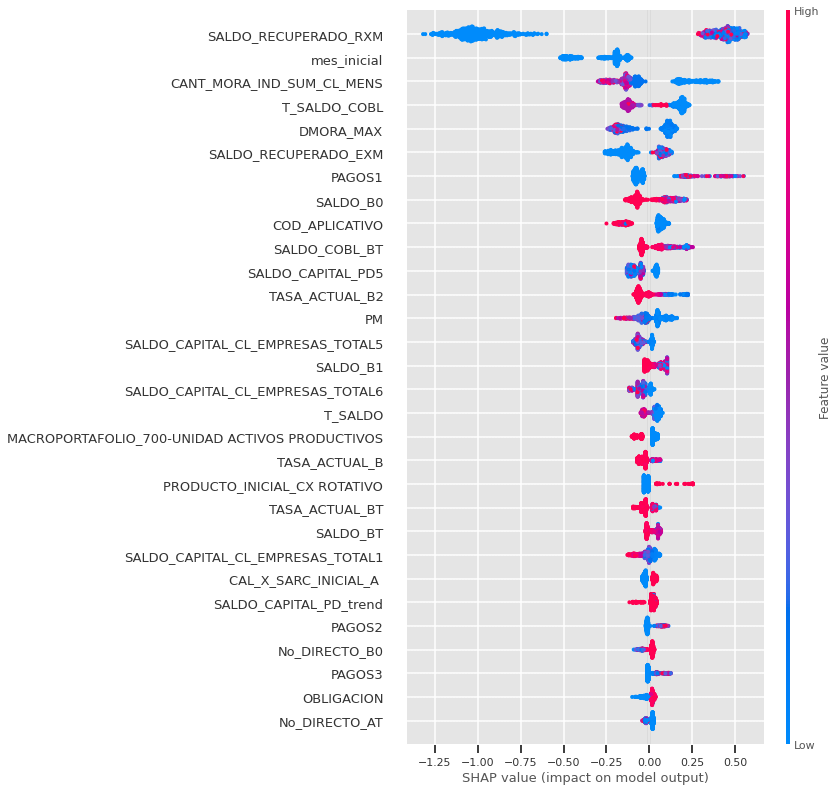

In [ ]:
explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(X_test_p)
shap.summary_plot(shap_values, X_test_p, max_display=30, feature_names=df_train.drop(['ID_PAGOS'], axis=1).columns)

**Pyme Pequeña RXE1==90**
--------------------------------------------------------

In [77]:
#@title Segmentación Pyme : Pyme Pequeña 90
df_train = df[(df.SUBSEGMENTO=='Pyme Pequeña') & (df.RXE1==90)]

df_train = df_train.drop(['SUBSEGMENTO', 'RXE1'],axis=1)
df_train = pd.get_dummies(df_train)
df_train = shuffle(df_train)

#Entrenamos hasta el mes de diciembre para realizar las pruebas en: Enero y Febrero
X = df_train[  (df_train.mes_inicial!=14) & (df_train.mes_inicial!=13)]
y = X[['ID_PAGOS']]
X = X.drop("ID_PAGOS", axis=1)
###############################################################

In [66]:
y.value_counts()

ID_PAGOS
0           1451
1            528
dtype: int64

Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:   14.8s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:   14.8s finished


[0]	validation_0-error:0.432723	validation_0-logloss:0.683495	validation_1-error:0.444444	validation_1-logloss:0.684585
[1]	validation_0-error:0.227416	validation_0-logloss:0.653549	validation_1-error:0.20202	validation_1-logloss:0.651023
[2]	validation_0-error:0.222363	validation_0-logloss:0.628763	validation_1-error:0.207071	validation_1-logloss:0.624912
[3]	validation_0-error:0.220467	validation_0-logloss:0.607683	validation_1-error:0.207071	validation_1-logloss:0.60121
[4]	validation_0-error:0.220467	validation_0-logloss:0.591686	validation_1-error:0.204545	validation_1-logloss:0.582616
[5]	validation_0-error:0.222363	validation_0-logloss:0.575019	validation_1-error:0.207071	validation_1-logloss:0.565494
[6]	validation_0-error:0.226153	validation_0-logloss:0.561859	validation_1-error:0.209596	validation_1-logloss:0.551555
[7]	validation_0-error:0.227416	validation_0-logloss:0.551151	validation_1-error:0.20202	validation_1-logloss:0.540759
[8]	validation_0-error:0.230575	validation_

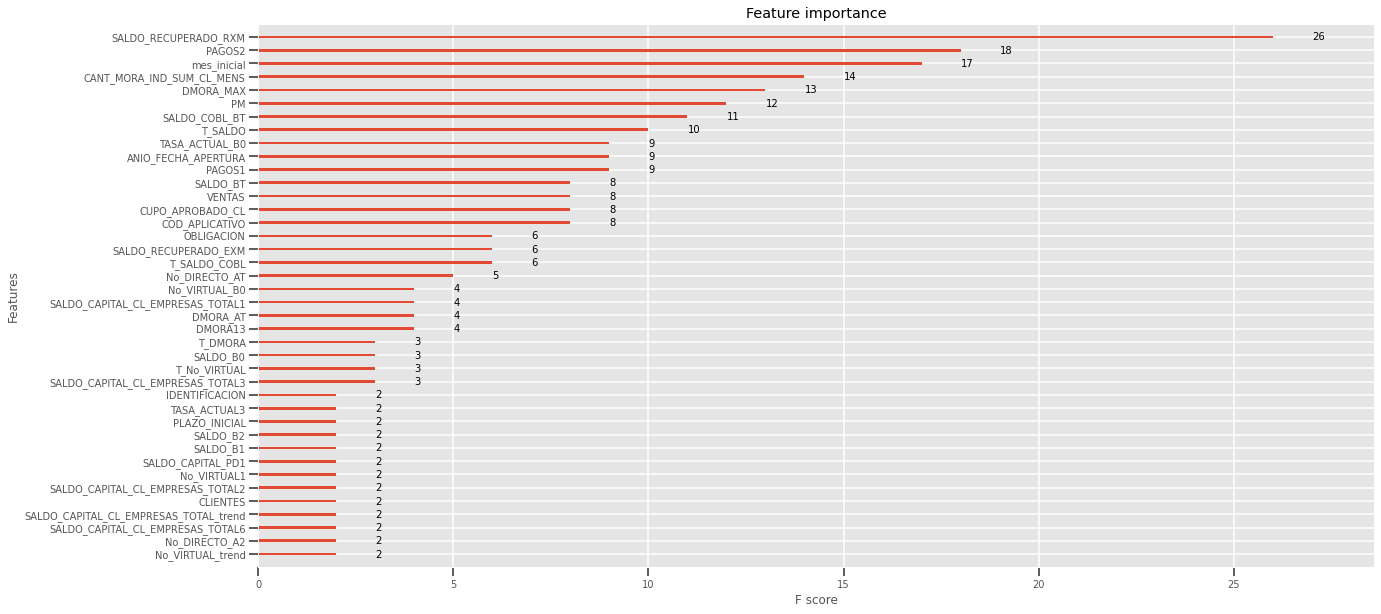

In [78]:
%%time
#################################### Balanceo de datos


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = seed, shuffle=True, stratify=y)

weight_class=y_train.ID_PAGOS.value_counts()[0]/y_train.ID_PAGOS.value_counts()[1] #(segun la documentacion de xgboost sum(negative instances) / sum(positive instances)




######################Modelado Xgboost


model_xgb = model_xgboost(X_train, y_train, X_test, y_test, weight=weight_class ,grid_hiper=True)

%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 10.0)
sns.set_context("talk", font_scale=0.6)
plt.style.use('ggplot')
plot_importance(model_xgb, max_num_features= 40)

filename = ruta+ "/modelo_xgb_pymepequeña90.sav"
pickle.dump(model_xgb, open(filename, 'wb'))

##############################################################################################
###################################################################################################
print_score(model_xgb, X_train, y_train, X_test, y_test, train=True)
print_score(model_xgb, X_train, y_train, X_test, y_test, train=False)

**Resultados de función de pérdida y error**

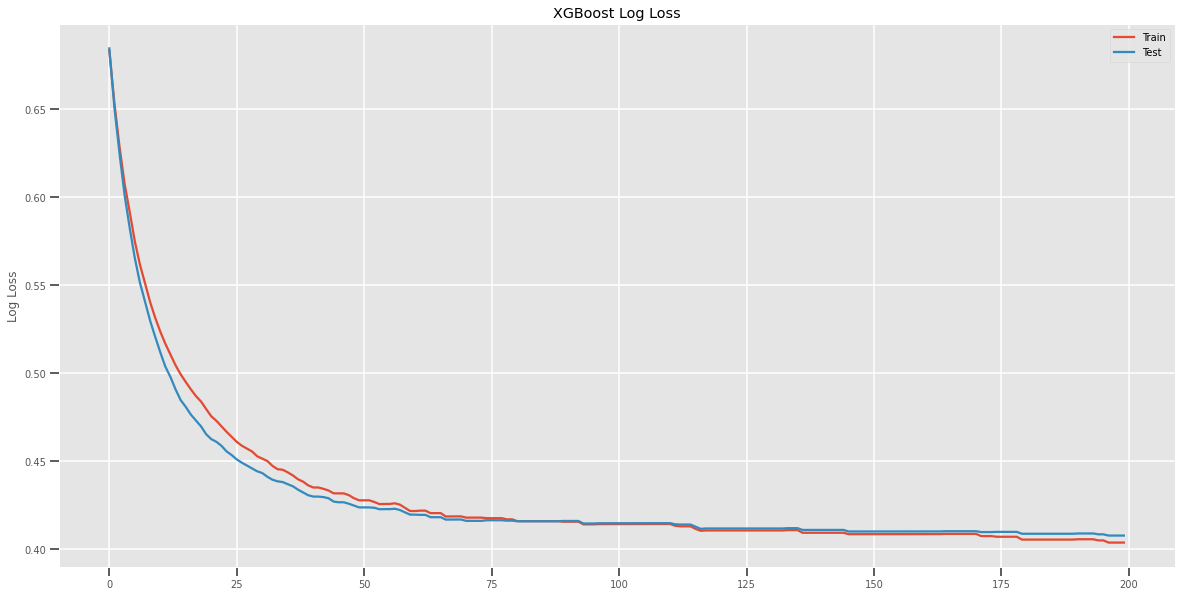

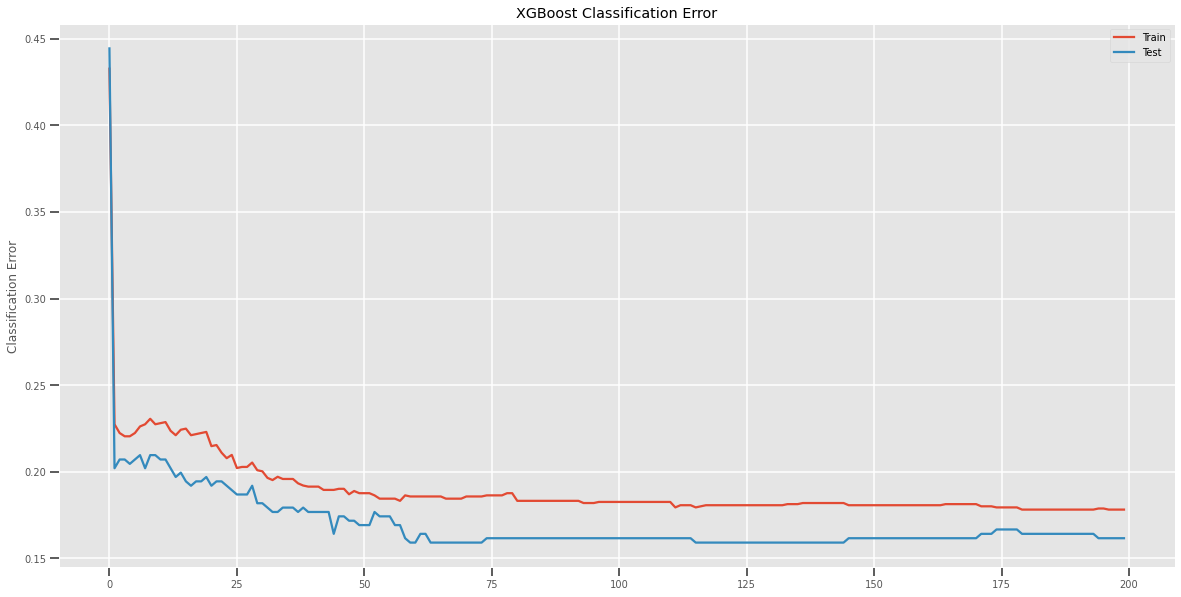

In [79]:
# retrieve performance metrics
results = model_xgb.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

In [80]:
#Dataframe de resultados

idx= ['Resultados_X_train', 'Resultados_X_val', 'Resultados_X_test_enero', 'Resultados_X_test_febrero']


y_train_pred = model_xgb.predict(X_train)

p = model_xgb.predict_proba(X_train)
fp_rates, tp_rates, _ = roc_curve(y_train,p[:,1])
roc_auc = auc(fp_rates, tp_rates)

resultados_eval = pd.DataFrame(index=idx)
resultados_eval.loc['Resultados_X_train','Precision'] = precision_score(y_train, y_train_pred )
resultados_eval.loc['Resultados_X_train','Recall'] = recall_score(y_train, y_train_pred )
resultados_eval.loc['Resultados_X_train','ROC_AUC'] = roc_auc_score(y_train, y_train_pred )
resultados_eval.loc['Resultados_X_train', 'F1_Score'] = f1_score(y_train, y_train_pred )
resultados_eval.loc['Resultados_X_train', 'RMSE'] =np.sqrt( mean_squared_error(y_train, y_train_pred ))
resultados_eval.loc['Resultados_X_train', 'AUC'] = roc_auc
resultados_eval.loc['Resultados_X_train', 'Accuracy'] = accuracy_score(y_train, y_train_pred )

#------------------------------------------------------------------------------------------------------------
#Resultados de validación
#------------------------------------------------------------------------------------------------------------

y_test_pred = model_xgb.predict(X_test)
p = model_xgb.predict_proba(X_test)
fp_rates, tp_rates, _ = roc_curve(y_test,p[:,1])
roc_auc = auc(fp_rates, tp_rates)

resultados_eval.loc['Resultados_X_val','Precision'] = precision_score(y_test, y_test_pred )
resultados_eval.loc['Resultados_X_val','Recall'] = recall_score(y_test, y_test_pred )
resultados_eval.loc['Resultados_X_val','ROC_AUC'] = roc_auc_score(y_test, y_test_pred )
resultados_eval.loc['Resultados_X_val', 'F1_Score'] = f1_score(y_test, y_test_pred )
resultados_eval.loc['Resultados_X_val', 'RMSE'] =np.sqrt( mean_squared_error(y_test, y_test_pred ))
resultados_eval.loc['Resultados_X_val', 'AUC'] = roc_auc
resultados_eval.loc['Resultados_X_val', 'Accuracy'] = accuracy_score(y_test, y_test_pred)

In [82]:
## Mejores parámetros para este modelo
model_xgb

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=10, eta=0.1,
              eval_metric=['error', 'logloss'], gamma=7, learning_rate=0.1,
              max_delta_step=6, max_depth=3, min_child_weight=10, missing=None,
              n_estimators=200, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=11,
              reg_lambda=11, sampling_method='uniform',
              scale_pos_weight=2.751184834123223, seed=None, silent=None,
              subsample=0.95, verbosity=1)

**Resultados Enero**

Resultados de validación:

accuracy score: 0.8048

Reporte de clasificación: 
               precision    recall  f1-score   support

           0       0.83      0.93      0.88       290
           1       0.61      0.36      0.45        84

    accuracy                           0.80       374
   macro avg       0.72      0.65      0.67       374
weighted avg       0.78      0.80      0.78       374


Confusion Matrix: 
 [[271  19]
 [ 54  30]]

RMSE 
0.4417999159975034

MSLE 
0.09377826207494305

F1-score 
0.45112781954887216

Recall 
0.35714285714285715

Presicion 
0.6122448979591837



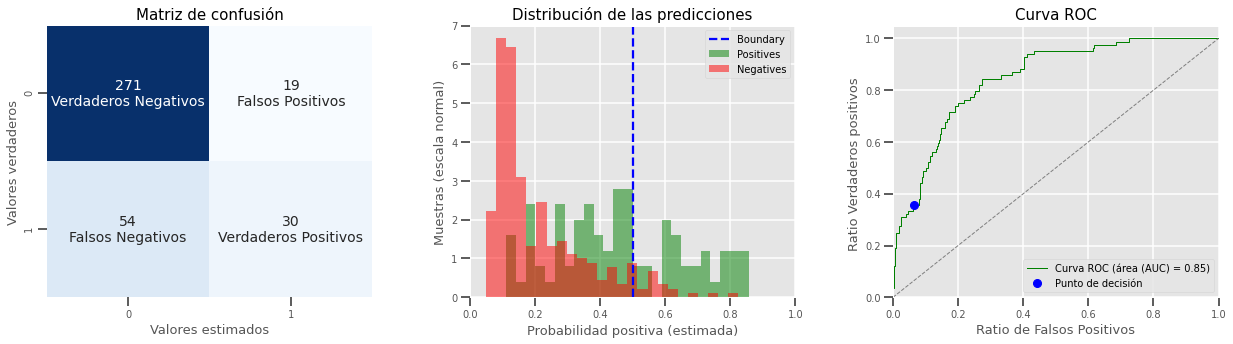

In [83]:
##Evaluación para el mes de enero
X_test_p =  df_train[(df_train.mes_inicial==13)] 
y_test_p = X_test_p[['ID_PAGOS']]
X_test_p = X_test_p.drop("ID_PAGOS", axis=1)

print_score(model_xgb, X_test_p, y_test_p, X_test_p, y_test_p, train=False, valid=True)
###################################################################################################

F1 = evalBinaryClassifier(model_xgb, X_test_p, y_test_p)

In [84]:
y_test_pred = model_xgb.predict(X_test_p)
p = model_xgb.predict_proba(X_test_p)
fp_rates, tp_rates, _ = roc_curve(y_test_p,p[:,1])
roc_auc = auc(fp_rates, tp_rates)
resultados_eval.loc['Resultados_X_test_enero','Precision'] = precision_score(y_test_p, y_test_pred )
resultados_eval.loc['Resultados_X_test_enero','Recall'] = recall_score(y_test_p, y_test_pred )
resultados_eval.loc['Resultados_X_test_enero','ROC_AUC'] = roc_auc_score(y_test_p, y_test_pred )
resultados_eval.loc['Resultados_X_test_enero', 'F1_Score'] = f1_score(y_test_p, y_test_pred )
resultados_eval.loc['Resultados_X_test_enero', 'RMSE'] =np.sqrt( mean_squared_error(y_test_p, y_test_pred ))
resultados_eval.loc['Resultados_X_test_enero', 'AUC'] = roc_auc
resultados_eval.loc['Resultados_X_test_enero', 'Accuracy'] = accuracy_score(y_test_p, y_test_pred)

In [85]:
resultados_eval

Precision    Recall   ROC_AUC  F1_Score      RMSE  \
Resultados_X_train          0.619454  0.860190  0.834057  0.720238  0.422070   
Resultados_X_val            0.654412  0.839623  0.838777  0.735537  0.402015   
Resultados_X_test_enero     0.612245  0.357143  0.645813  0.451128  0.441800   
Resultados_X_test_febrero        NaN       NaN       NaN       NaN       NaN   

                                AUC  Accuracy  
Resultados_X_train         0.914307  0.821857  
Resultados_X_val           0.897625  0.838384  
Resultados_X_test_enero    0.847701  0.804813  
Resultados_X_test_febrero       NaN       NaN

In [ ]:
resultados_eval.to_csv( ruta+ "/tabla_desempeño_pymep90.csv", index=False)

**Resultados Febrero**


*Para validar el modelo en febrero cargamos el modelo entrenado anteriormente*

In [ ]:
model_xgb = pickle.load(open(ruta+ "/modelo_xgb_pymepequeña90.sav", 'rb'))

#####################Cargamos el esquema de entrenamiento para darselo al marco de datos nuevo

esquema_train = pd.read_csv(ruta+"esquema_de_entrenamiento_pymep90.csv")
columns_train = esquema_train.columns

*Repetimos un procedimieno análogo al descrito anteriormente para poder evaluar los datos de febrero. Nota debemos crear df_train que se crea en la primera linea de este modelo, esta linea del código da la estructura para evaluar nuestros datos.*


In [ ]:
##Evaluación para el mes de Febrero
X_test_p =  df_train[(df_train.mes_inicial==14)]

####Definir esquema
X_test_p = X_test_p[columns_train]
y_test_p = X_test_p[['ID_PAGOS']]
X_test_p = X_test_p.drop("ID_PAGOS", axis=1)

print_score(model_xgb, X_test_p, y_test_p, X_test_p, y_test_p, train=False, valid=True)
###################################################################################################

F1 = evalBinaryClassifier(model_xgb, X_test_p, y_test_p)

In [ ]:
resultados_eval = pd.read_csv(ruta+ "/tabla_desempeño_pymep90.csv")
y_test_pred = model_xgb.predict(X_test_p.values)
p = model_xgb.predict_proba(X_test_p.values)
fp_rates, tp_rates, _ = roc_curve(y_test_p.values,p[:,1])
roc_auc = auc(fp_rates, tp_rates)
resultados_eval.loc['Resultados_X_test_febrero','Precision'] = precision_score(y_test_p.values, y_test_pred )
resultados_eval.loc['Resultados_X_test_febrero','Recall'] = recall_score(y_test_p.values, y_test_pred )
resultados_eval.loc['Resultados_X_test_febrero','ROC_AUC'] = roc_auc_score(y_test_p.values, y_test_pred )
resultados_eval.loc['Resultados_X_test_febrero', 'F1_Score'] = f1_score(y_test_p.values, y_test_pred )
resultados_eval.loc['Resultados_X_test_febrero', 'RMSE'] =np.sqrt( mean_squared_error(y_test_p.values, y_test_pred ))
resultados_eval.loc['Resultados_X_test_febrero', 'AUC'] = roc_auc
resultados_eval.loc['Resultados_X_test_febrero', 'Accuracy'] = accuracy_score(y_test_p.values, y_test_pred)
resultados_eval = resultados_eval.drop(3)
resultados_eval = resultados_eval.rename(index ={0:'Resultados_X_train', 1:'Resultados_X_Val', 2:'Resultados_X_test_enero'})
resultados_eval.loc['Modelo'] ='Pyme Pequeña 90'

In [ ]:
resultados_eval

In [ ]:
resultados_eval.to_csv( ruta+ "/tabla_desempeño_pymep90_feb.csv")

**¿Cómo está aprendiendo el modelo?**

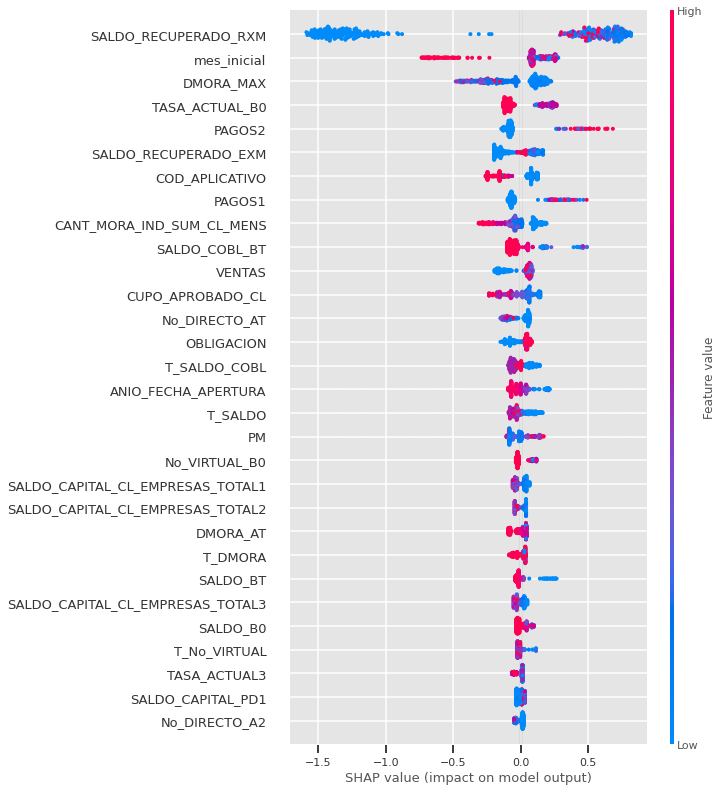

In [86]:
explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, max_display=30, feature_names=df_train.drop(['ID_PAGOS'], axis=1).columns)

**Pyme Pequeña RXE1==9999**
-----------------------------------

In [ ]:
#@title Segmentación Pyme : Pyme Pequeña 9999
df_train = df[(df.SUBSEGMENTO=='Pyme Pequeña') & (df.RXE1==9999)]

df_train = df_train.drop(['SUBSEGMENTO', 'RXE1'],axis=1)
df_train = pd.get_dummies(df_train)
df_train = shuffle(df_train)

#Entrenamos hasta el mes de diciembre para realizar las pruebas en: Enero y Febrero
X = df_train[  (df_train.mes_inicial!=14) & (df_train.mes_inicial!=13)]
y = X[['ID_PAGOS']]
X = X.drop("ID_PAGOS", axis=1)
###############################################################

Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:  4.4min remaining:    0.0s
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:  4.4min finished


[0]	validation_0-error:0.180367	validation_0-logloss:0.54358	validation_1-error:0.179227	validation_1-logloss:0.542135
[1]	validation_0-error:0.096017	validation_0-logloss:0.412745	validation_1-error:0.090004	validation_1-logloss:0.408901
[2]	validation_0-error:0.096017	validation_0-logloss:0.412745	validation_1-error:0.090004	validation_1-logloss:0.408901
[3]	validation_0-error:0.085131	validation_0-logloss:0.351033	validation_1-error:0.084342	validation_1-logloss:0.34907
[4]	validation_0-error:0.083423	validation_0-logloss:0.313685	validation_1-error:0.080437	validation_1-logloss:0.311836
[5]	validation_0-error:0.072537	validation_0-logloss:0.268685	validation_1-error:0.071456	validation_1-logloss:0.267615
[6]	validation_0-error:0.067412	validation_0-logloss:0.236325	validation_1-error:0.067747	validation_1-logloss:0.236672
[7]	validation_0-error:0.066436	validation_0-logloss:0.220345	validation_1-error:0.066576	validation_1-logloss:0.221317
[8]	validation_0-error:0.065508	validation

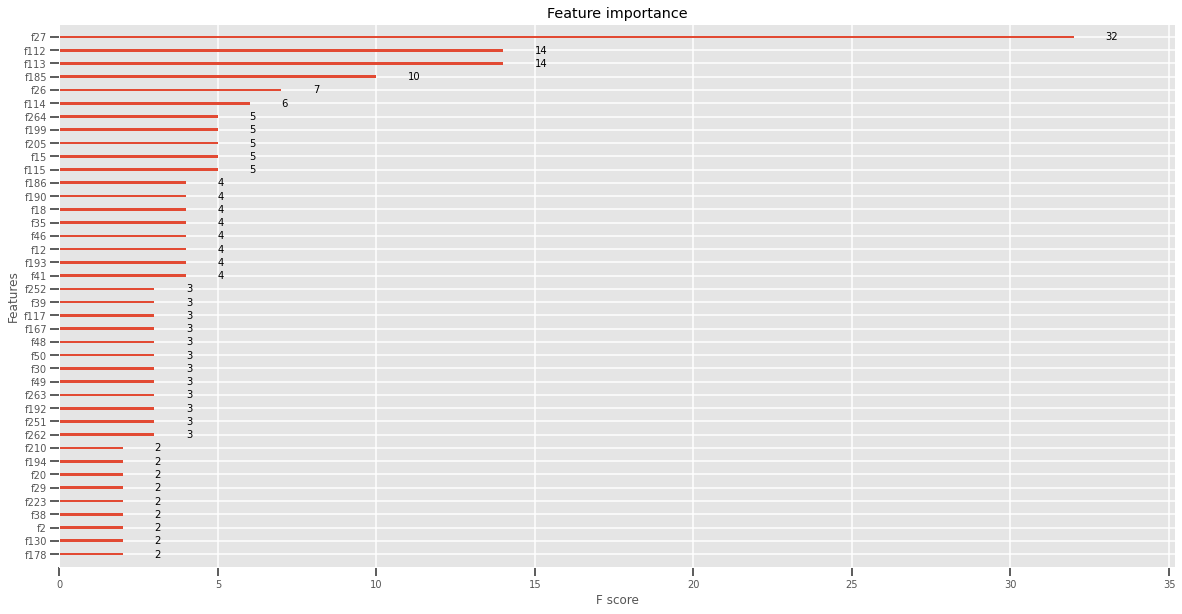

In [ ]:
%%time

#################################### Balanceo de datos



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = seed, shuffle=True, stratify=y)

weight_class=y_train.ID_PAGOS.value_counts()[0]/y_train.ID_PAGOS.value_counts()[1]


######################Modelado Xgboost


model_xgb = model_xgboost(X_train, y_train, X_test, y_test, weight=1 ,grid_hiper=True)

%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 10.0)
sns.set_context("talk", font_scale=0.6)
plt.style.use('ggplot')
plot_importance(model_xgb, max_num_features= 40)

filename = ruta+ "/modelo_xgb_pymepequeña30.sav"
pickle.dump(model_xgb, open(filename, 'wb'))

##############################################################################################
###################################################################################################
print_score(model_xgb, X_train, y_train, X_test, y_test, train=True)
print_score(model_xgb, X_train, y_train, X_test, y_test, train=False)

**Función de pérdida y error**

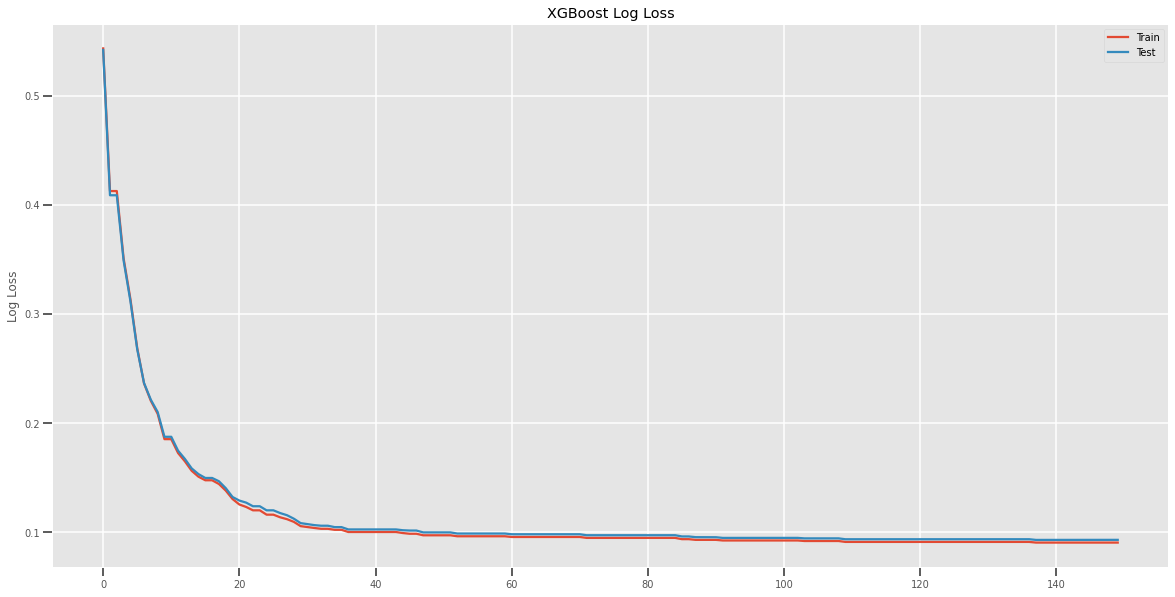

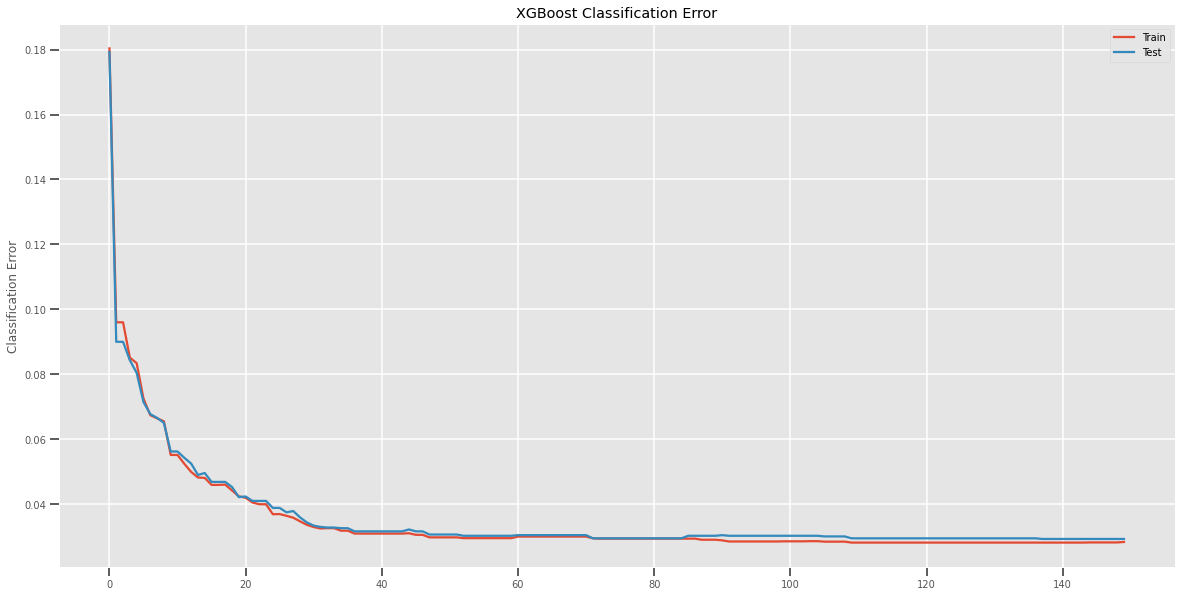

In [ ]:
# retrieve performance metrics
results = model_xgb.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

In [ ]:
#Dataframe de resultados

idx= ['Resultados_X_train', 'Resultados_X_val', 'Resultados_X_test_enero', 'Resultados_X_test_febrero']


y_train_pred = model_xgb.predict(X_train)

p = model_xgb.predict_proba(X_train)
fp_rates, tp_rates, _ = roc_curve(y_train,p[:,1])
roc_auc = auc(fp_rates, tp_rates)

resultados_eval = pd.DataFrame(index=idx)
resultados_eval.loc['Resultados_X_train','Precision'] = precision_score(y_train, y_train_pred )
resultados_eval.loc['Resultados_X_train','Recall'] = recall_score(y_train, y_train_pred )
resultados_eval.loc['Resultados_X_train','ROC_AUC'] = roc_auc_score(y_train, y_train_pred )
resultados_eval.loc['Resultados_X_train', 'F1_Score'] = f1_score(y_train, y_train_pred )
resultados_eval.loc['Resultados_X_train', 'RMSE'] =np.sqrt( mean_squared_error(y_train, y_train_pred ))
resultados_eval.loc['Resultados_X_train', 'AUC'] = roc_auc
resultados_eval.loc['Resultados_X_train', 'Accuracy'] = accuracy_score(y_train, y_train_pred )

#------------------------------------------------------------------------------------------------------------
#Resultados de validación
#------------------------------------------------------------------------------------------------------------

y_test_pred = model_xgb.predict(X_test)
p = model_xgb.predict_proba(X_test)
fp_rates, tp_rates, _ = roc_curve(y_test,p[:,1])
roc_auc = auc(fp_rates, tp_rates)

resultados_eval.loc['Resultados_X_val','Precision'] = precision_score(y_test, y_test_pred )
resultados_eval.loc['Resultados_X_val','Recall'] = recall_score(y_test, y_test_pred )
resultados_eval.loc['Resultados_X_val','ROC_AUC'] = roc_auc_score(y_test, y_test_pred )
resultados_eval.loc['Resultados_X_val', 'F1_Score'] = f1_score(y_test, y_test_pred )
resultados_eval.loc['Resultados_X_val', 'RMSE'] =np.sqrt( mean_squared_error(y_test, y_test_pred ))
resultados_eval.loc['Resultados_X_val', 'AUC'] = roc_auc
resultados_eval.loc['Resultados_X_val', 'Accuracy'] = accuracy_score(y_test, y_test_pred)

In [ ]:
model_xgb

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.2,
              early_stopping_rounds=10, eval_metric=['error', 'logloss'],
              gamma=9, learning_rate=0.4, max_delta_step=16, max_depth=4,
              min_child_weight=13, missing=None, n_estimators=150, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=19, reg_lambda=12, sampling_method='uniform',
              scale_pos_weight=1, seed=None, silent=None, subsample=0.6,
              verbosity=1)

**Resultados Enero**

Test Result:

accuracy score: 0.9359

Classification Report: 
               precision    recall  f1-score   support

           0       0.95      0.98      0.97      1829
           1       0.48      0.25      0.33       122

    accuracy                           0.94      1951
   macro avg       0.71      0.62      0.65      1951
weighted avg       0.92      0.94      0.93      1951


Confusion Matrix: 
 [[1795   34]
 [  91   31]]

RMSE 
0.2531199475389726

MSLE 
0.03078248423361106

F1-score 
0.3315508021390374

Recall 
0.2540983606557377

Presicion 
0.47692307692307695



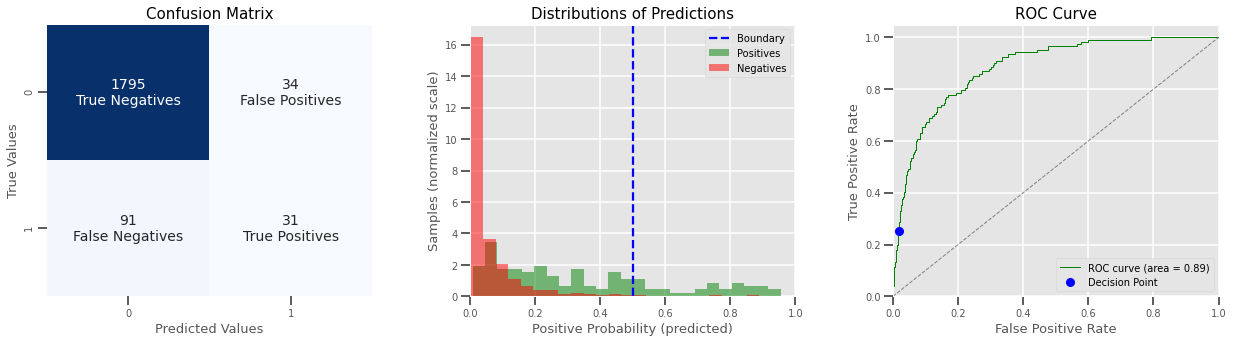

In [ ]:
##Evaluación para el mes de enero
X_test_p =  df_train[(df_train.mes_inicial==13)] 
y_test_p = X_test_p[['ID_PAGOS']]
X_test_p = X_test_p.drop("ID_PAGOS", axis=1)
X_test_p=  sc.transform(X_test_p)
print_score(model_xgb, X_test_p, y_test_p, X_test_p, y_test_p, train=False, valid=True)
###################################################################################################

F1 = evalBinaryClassifier(model_xgb, X_test_p, y_test_p)

In [ ]:
y_test_pred = model_xgb.predict(X_test_p)
p = model_xgb.predict_proba(X_test_p)
fp_rates, tp_rates, _ = roc_curve(y_test_p,p[:,1])
roc_auc = auc(fp_rates, tp_rates)
resultados_eval.loc['Resultados_X_test_enero','Precision'] = precision_score(y_test_p, y_test_pred )
resultados_eval.loc['Resultados_X_test_enero','Recall'] = recall_score(y_test_p, y_test_pred )
resultados_eval.loc['Resultados_X_test_enero','ROC_AUC'] = roc_auc_score(y_test_p, y_test_pred )
resultados_eval.loc['Resultados_X_test_enero', 'F1_Score'] = f1_score(y_test_p, y_test_pred )
resultados_eval.loc['Resultados_X_test_enero', 'RMSE'] =np.sqrt( mean_squared_error(y_test_p, y_test_pred ))
resultados_eval.loc['Resultados_X_test_enero', 'AUC'] = roc_auc
resultados_eval.loc['Resultados_X_test_enero', 'Accuracy'] = accuracy_score(y_test_p, y_test_pred)

In [ ]:
resultados_eval

Precision    Recall   ROC_AUC  F1_Score      RMSE  \
Resultados_X_train          0.977466  0.965537  0.971639  0.971465  0.168407   
Resultados_X_val            0.974793  0.966419  0.970715  0.970588  0.171130   
Resultados_X_test_enero     0.476923  0.254098  0.617754  0.331551  0.253120   
Resultados_X_test_febrero        NaN       NaN       NaN       NaN       NaN   

                                AUC  Accuracy  
Resultados_X_train         0.994973  0.971639  
Resultados_X_val           0.994973  0.970715  
Resultados_X_test_enero    0.885506  0.935930  
Resultados_X_test_febrero       NaN       NaN

In [ ]:
resultados_eval.to_csv( ruta+ "/tabla_desempeño_pymep9999.csv", index=False)

**Resultados Febrero**

*Para validar el modelo en febrero cargamos el modelo entrenado anteriormente*

In [ ]:
model_xgb = pickle.load(open( ruta+ "/modelo_xgb_pymepequeña9999.sav" ,'rb'))

#####################Cargamos el esquema de entrenamiento para darselo al marco de datos nuevo

esquema_train = pd.read_csv(ruta+"esquema_de_entrenamiento_pymep9999.csv")
columns_train = esquema_train.columns


*Repetimos un procedimieno análogo al descrito anteriormente para poder evaluar los datos de febrero. Nota debemos crear df_train que se crea en la primera linea de este modelo, esta linea del código da la estructura para evaluar nuestros datos.*

In [ ]:
##Evaluación para el mes de Febrero
X_test_p =  df_train[(df_train.mes_inicial==14)] 

#############Definir esquema
X_test_p = X_test_p[columns_train]
y_test_p = X_test_p[['ID_PAGOS']]
X_test_p = X_test_p.drop("ID_PAGOS", axis=1)
X_test_p=  sc.transform(X_test_p)
print_score(model_xgb, X_test_p, y_test_p, X_test_p, y_test_p, train=False, valid=True)
###################################################################################################

F1 = evalBinaryClassifier(model_xgb, X_test_p, y_test_p)

In [ ]:
resultados_eval = pd.read_csv( ruta+ "/tabla_desempeño_pymep9999.csv")
y_test_pred = model_xgb.predict(X_test_p.values)
p = model_xgb.predict_proba(X_test_p.values)
fp_rates, tp_rates, _ = roc_curve(y_test_p.values,p[:,1])
roc_auc = auc(fp_rates, tp_rates)
resultados_eval.loc['Resultados_X_test_febrero','Precision'] = precision_score(y_test_p.values, y_test_pred )
resultados_eval.loc['Resultados_X_test_febrero','Recall'] = recall_score(y_test_p.values, y_test_pred )
resultados_eval.loc['Resultados_X_test_febrero','ROC_AUC'] = roc_auc_score(y_test_p.values, y_test_pred )
resultados_eval.loc['Resultados_X_test_febrero', 'F1_Score'] = f1_score(y_test_p.values, y_test_pred )
resultados_eval.loc['Resultados_X_test_febrero', 'RMSE'] =np.sqrt( mean_squared_error(y_test_p.values, y_test_pred ))
resultados_eval.loc['Resultados_X_test_febrero', 'AUC'] = roc_auc
resultados_eval.loc['Resultados_X_test_febrero', 'Accuracy'] = accuracy_score(y_test_p.values, y_test_pred)
resultados_eval = resultados_eval.drop(3)
resultados_eval = resultados_eval.rename(index ={0:'Resultados_X_train', 1:'Resultados_X_Val', 2:'Resultados_X_test_enero'})
resultados_eval.loc['Modelo'] ='Pyme Pequeña 9999'

In [ ]:
resultados_eval

In [ ]:
resultados_eval.to_csv(ruta+ "/tabla_desempeño_pymep9999_feb.csv")

**¿Cómo está aprendiendo el Modelo?**

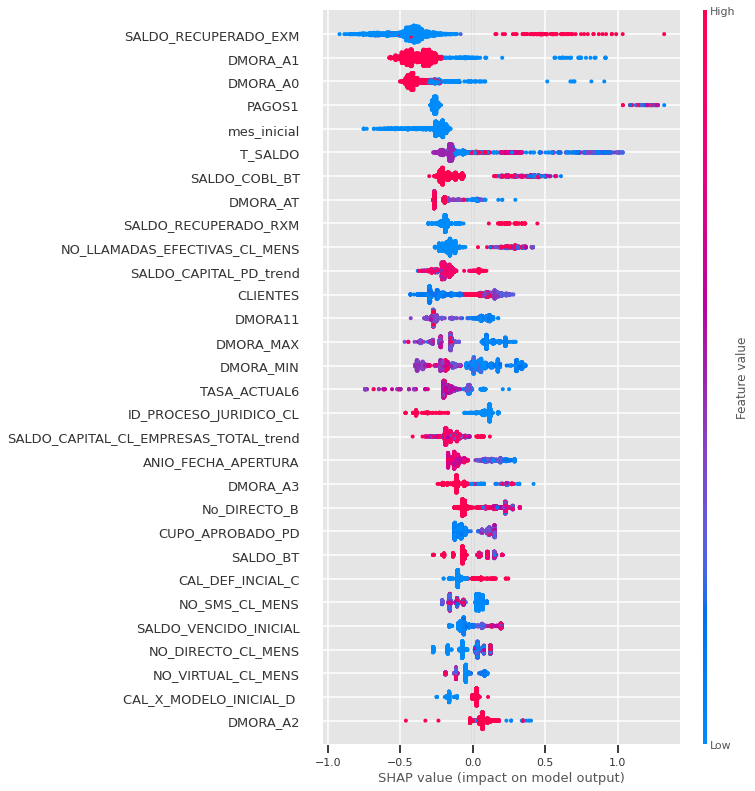

In [ ]:
explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(X_test_p)
shap.summary_plot(shap_values, X_test_p, max_display=30, feature_names=df_train.drop(['ID_PAGOS'], axis=1).columns)

#Pyme Grande

El subsegmento Pyme Grande es obtenido mediante la variable *SUBSEGMENTO* de la base de datos de T_kobra. A continuación también podemos observar la volumetría de los datos disponibles para modelar. Este segmento es el más pequeño. Especialmente tenemos una baja volumetría de datos en altura de mora de 60 y 90 días de mora de la **obligación**. Esta volumetría hace parte de la recolección de datos entre las fechas (Junio 2020- Enero 2021)

Text(0, 0.5, 'Cantidad')

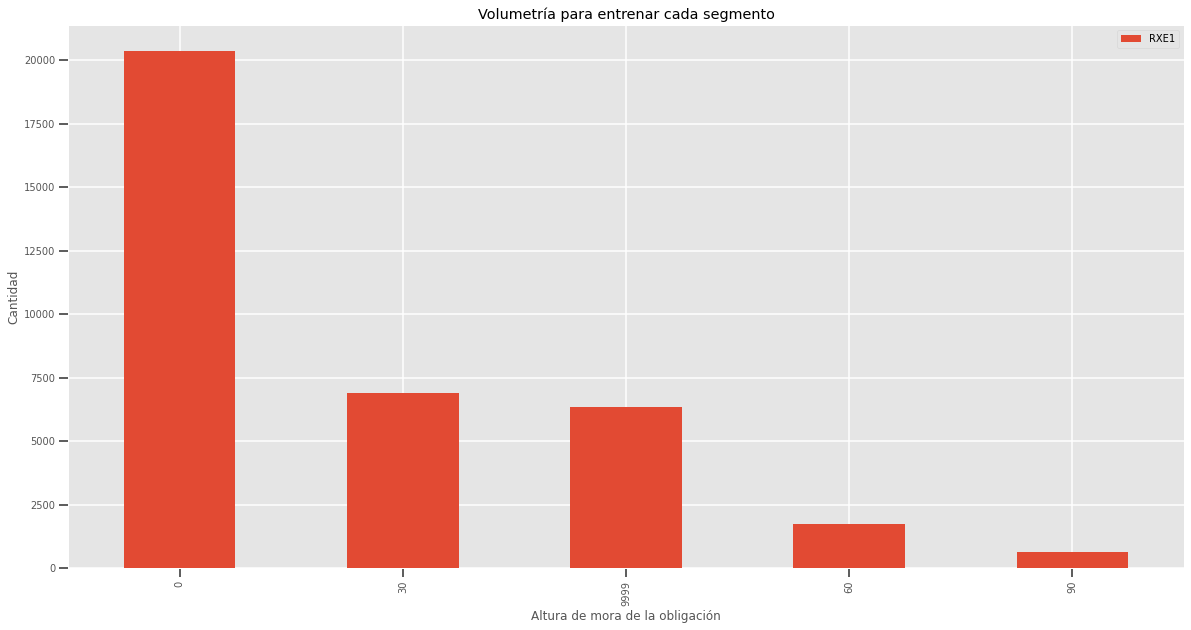

In [89]:
pd.DataFrame(df[(df.SUBSEGMENTO=='Pyme Grande')].RXE1.value_counts()).plot(kind='bar')
plt.title('Volumetría para entrenar cada segmento')
plt.xlabel('Altura de mora de la obligación')
plt.ylabel('Cantidad')

**Pyme Grande RXE1=0**
--------------------------------------------------------------------------

In [90]:
#@title Segmentación Pyme : Pyme Grande 0
df_train = df[(df.SUBSEGMENTO=='Pyme Grande') & (df.RXE1==0)]

df_train = df_train.drop(['SUBSEGMENTO', 'RXE1'],axis=1)
df_train = pd.get_dummies(df_train)
df_train = shuffle(df_train)

#Entrenamos hasta el mes de diciembre para realizar las pruebas en: Enero y Febrero
X = df_train[  (df_train.mes_inicial!=14) & (df_train.mes_inicial!=13)]
y = X[['ID_PAGOS']]
X = X.drop("ID_PAGOS", axis=1)
###############################################################

In [91]:
y.value_counts()

ID_PAGOS
0           12737
1            5392
dtype: int64

Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:  2.4min remaining:    0.0s
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:  2.4min finished


[0]	validation_0-error:0.214507	validation_0-logloss:0.660911	validation_1-error:0.208218	validation_1-logloss:0.660253
[1]	validation_0-error:0.260015	validation_0-logloss:0.626861	validation_1-error:0.257033	validation_1-logloss:0.625405
[2]	validation_0-error:0.232297	validation_0-logloss:0.598921	validation_1-error:0.230281	validation_1-logloss:0.597165
[3]	validation_0-error:0.217334	validation_0-logloss:0.579136	validation_1-error:0.218147	validation_1-logloss:0.577423
[4]	validation_0-error:0.21961	validation_0-logloss:0.558049	validation_1-error:0.218974	validation_1-logloss:0.555761
[5]	validation_0-error:0.221265	validation_0-logloss:0.540899	validation_1-error:0.222835	validation_1-logloss:0.538926
[6]	validation_0-error:0.211129	validation_0-logloss:0.525891	validation_1-error:0.211804	validation_1-logloss:0.523531
[7]	validation_0-error:0.216024	validation_0-logloss:0.512296	validation_1-error:0.217044	validation_1-logloss:0.510206
[8]	validation_0-error:0.217334	validatio

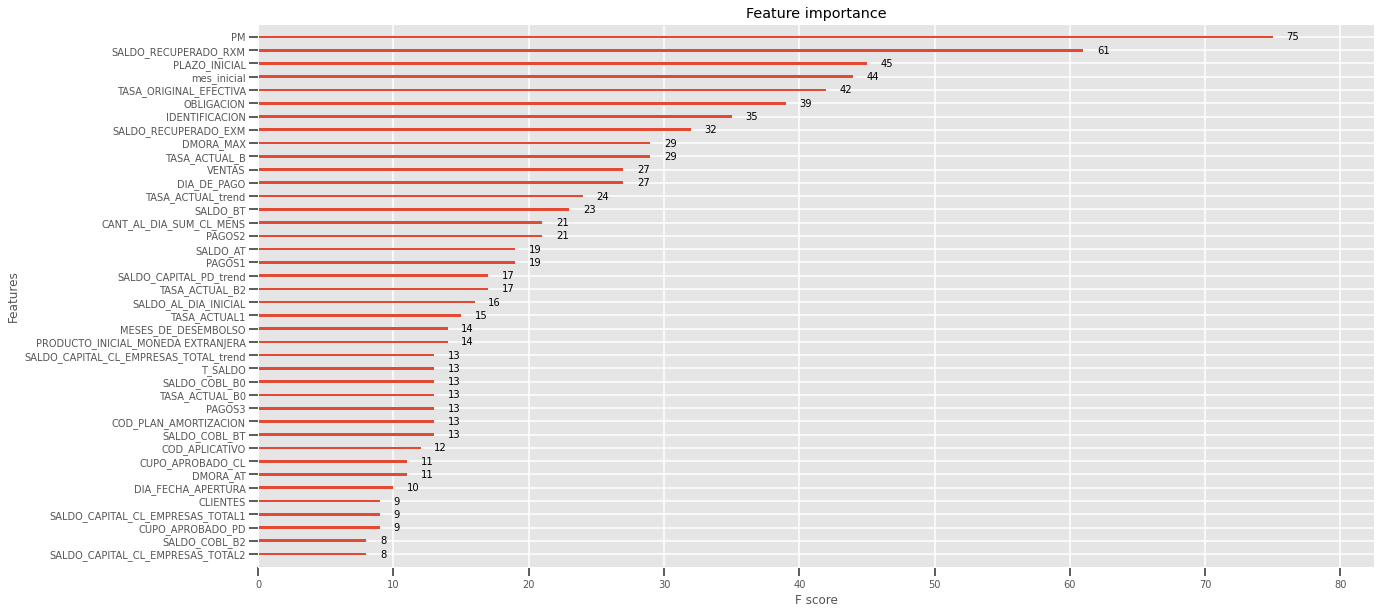

In [93]:
%%time
#################################### Balanceo de datos


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = seed, shuffle=True, stratify=y)

weight_class=y_train.ID_PAGOS.value_counts()[0]/y_train.ID_PAGOS.value_counts()[1] #(segun la documentacion de xgboost sum(negative instances) / sum(positive instances)




######################Modelado Xgboost


model_xgb = model_xgboost(X_train, y_train, X_test, y_test, weight=weight_class ,grid_hiper=True)

%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 10.0)
sns.set_context("talk", font_scale=0.6)
plt.style.use('ggplot')
plot_importance(model_xgb, max_num_features= 40)

filename = ruta+ "/modelo_xgb_pymegrande0.sav"
pickle.dump(model_xgb, open(filename, 'wb'))

##############################################################################################
###################################################################################################
print_score(model_xgb, X_train, y_train, X_test, y_test, train=True)
print_score(model_xgb, X_train, y_train, X_test, y_test, train=False)

**Función de pérdida**

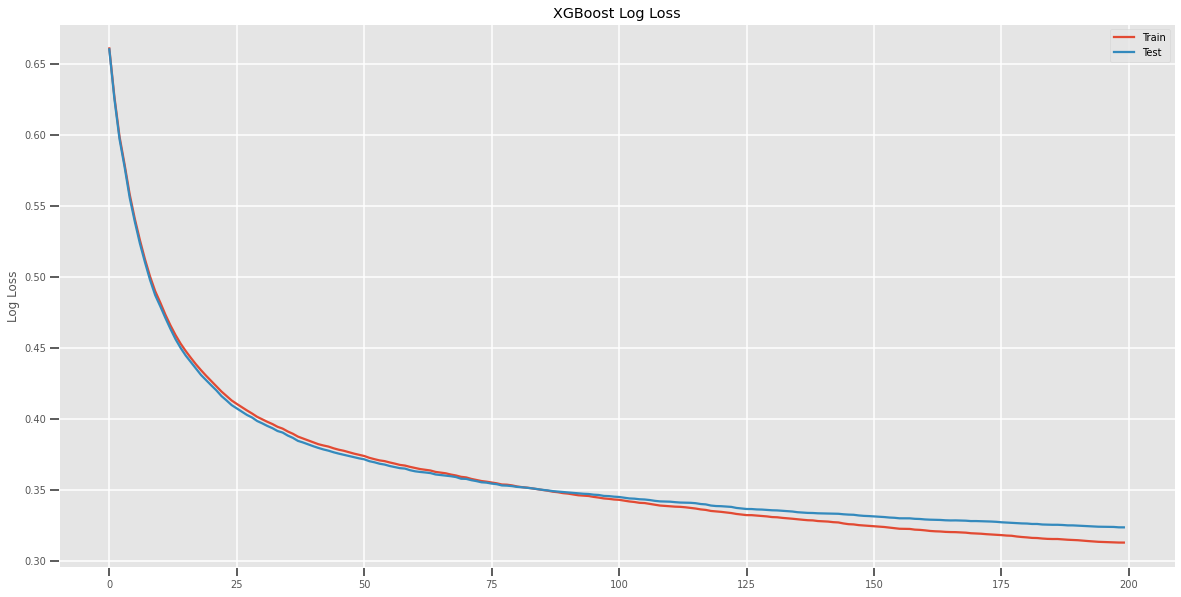

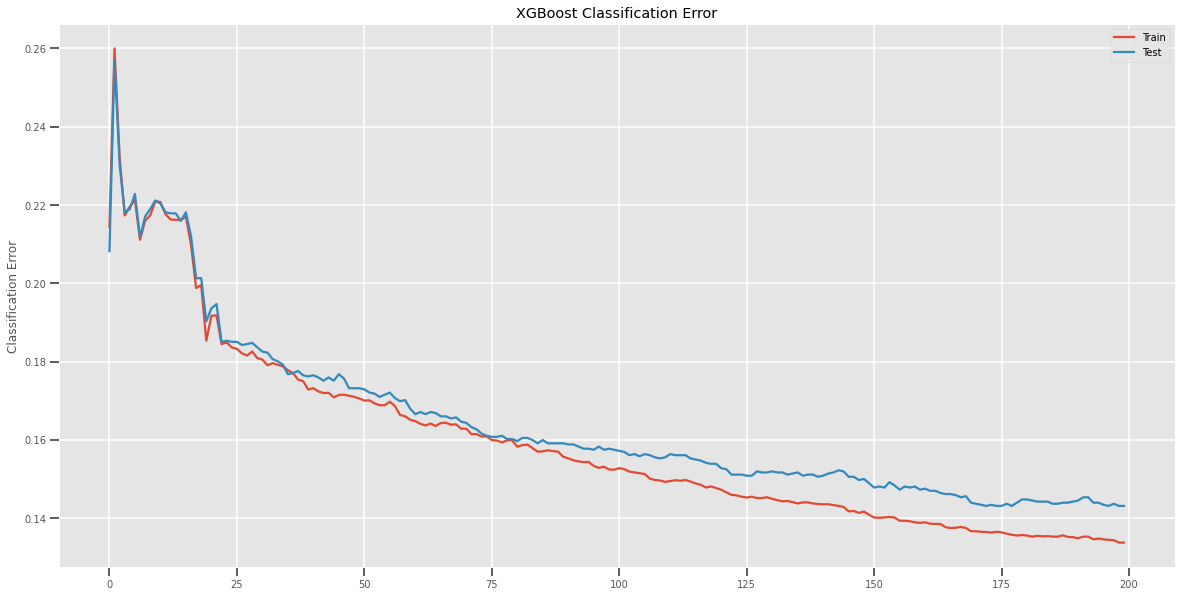

In [94]:
# retrieve performance metrics
results = model_xgb.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

In [95]:
#Dataframe de resultados

idx= ['Resultados_X_train', 'Resultados_X_val', 'Resultados_X_test_enero', 'Resultados_X_test_febrero']


y_train_pred = model_xgb.predict(X_train)

p = model_xgb.predict_proba(X_train)
fp_rates, tp_rates, _ = roc_curve(y_train,p[:,1])
roc_auc = auc(fp_rates, tp_rates)

resultados_eval = pd.DataFrame(index=idx)
resultados_eval.loc['Resultados_X_train','Precision'] = precision_score(y_train, y_train_pred )
resultados_eval.loc['Resultados_X_train','Recall'] = recall_score(y_train, y_train_pred )
resultados_eval.loc['Resultados_X_train','ROC_AUC'] = roc_auc_score(y_train, y_train_pred )
resultados_eval.loc['Resultados_X_train', 'F1_Score'] = f1_score(y_train, y_train_pred )
resultados_eval.loc['Resultados_X_train', 'RMSE'] =np.sqrt( mean_squared_error(y_train, y_train_pred ))
resultados_eval.loc['Resultados_X_train', 'AUC'] = roc_auc
resultados_eval.loc['Resultados_X_train', 'Accuracy'] = accuracy_score(y_train, y_train_pred )

#------------------------------------------------------------------------------------------------------------
#Resultados de validación
#------------------------------------------------------------------------------------------------------------

y_test_pred = model_xgb.predict(X_test)
p = model_xgb.predict_proba(X_test)
fp_rates, tp_rates, _ = roc_curve(y_test,p[:,1])
roc_auc = auc(fp_rates, tp_rates)

resultados_eval.loc['Resultados_X_val','Precision'] = precision_score(y_test, y_test_pred )
resultados_eval.loc['Resultados_X_val','Recall'] = recall_score(y_test, y_test_pred )
resultados_eval.loc['Resultados_X_val','ROC_AUC'] = roc_auc_score(y_test, y_test_pred )
resultados_eval.loc['Resultados_X_val', 'F1_Score'] = f1_score(y_test, y_test_pred )
resultados_eval.loc['Resultados_X_val', 'RMSE'] =np.sqrt( mean_squared_error(y_test, y_test_pred ))
resultados_eval.loc['Resultados_X_val', 'AUC'] = roc_auc
resultados_eval.loc['Resultados_X_val', 'Accuracy'] = accuracy_score(y_test, y_test_pred)

In [96]:
## Mejores parámetros para este modelo
model_xgb

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=10, eta=0.1,
              eval_metric=['error', 'logloss'], gamma=7, learning_rate=0.1,
              max_delta_step=6, max_depth=3, min_child_weight=10, missing=None,
              n_estimators=200, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=11,
              reg_lambda=11, sampling_method='uniform',
              scale_pos_weight=2.3618451553082984, seed=None, silent=None,
              subsample=0.95, verbosity=1)

**Resultados Enero**

Resultados de validación:

accuracy score: 0.8263

Reporte de clasificación: 
               precision    recall  f1-score   support

           0       0.81      0.90      0.85      1253
           1       0.85      0.74      0.79       992

    accuracy                           0.83      2245
   macro avg       0.83      0.82      0.82      2245
weighted avg       0.83      0.83      0.82      2245


Confusion Matrix: 
 [[1125  128]
 [ 262  730]]

RMSE 
0.41679656475549576

MSLE 
0.08346399796351826

F1-score 
0.7891891891891892

Recall 
0.7358870967741935

Presicion 
0.8508158508158508



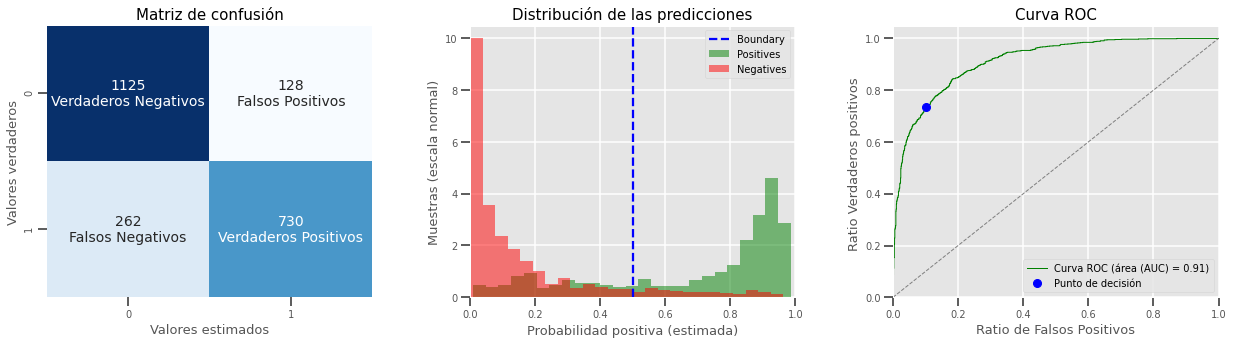

In [99]:
##Evaluación para el mes de Enero
X_test_p =  df_train[(df_train.mes_inicial==13)] 

#############Definir esquema

y_test_p = X_test_p[['ID_PAGOS']]
X_test_p = X_test_p.drop("ID_PAGOS", axis=1)

print_score(model_xgb, X_test_p, y_test_p, X_test_p, y_test_p, train=False, valid=True)
###################################################################################################

F1 = evalBinaryClassifier(model_xgb, X_test_p, y_test_p)

In [101]:
y_test_pred = model_xgb.predict(X_test_p)
p = model_xgb.predict_proba(X_test_p)
fp_rates, tp_rates, _ = roc_curve(y_test_p,p[:,1])
roc_auc = auc(fp_rates, tp_rates)
resultados_eval.loc['Resultados_X_test_enero','Precision'] = precision_score(y_test_p, y_test_pred )
resultados_eval.loc['Resultados_X_test_enero','Recall'] = recall_score(y_test_p, y_test_pred )
resultados_eval.loc['Resultados_X_test_enero','ROC_AUC'] = roc_auc_score(y_test_p, y_test_pred )
resultados_eval.loc['Resultados_X_test_enero', 'F1_Score'] = f1_score(y_test_p, y_test_pred )
resultados_eval.loc['Resultados_X_test_enero', 'RMSE'] =np.sqrt( mean_squared_error(y_test_p, y_test_pred ))
resultados_eval.loc['Resultados_X_test_enero', 'AUC'] = roc_auc
resultados_eval.loc['Resultados_X_test_enero', 'Accuracy'] = accuracy_score(y_test_p, y_test_pred)

In [102]:
resultados_eval

Precision    Recall   ROC_AUC  F1_Score      RMSE  \
Resultados_X_train          0.728445  0.877376  0.869447  0.796004  0.365740   
Resultados_X_val            0.716835  0.857143  0.856947  0.780735  0.378329   
Resultados_X_test_enero     0.850816  0.735887  0.816866  0.789189  0.416797   
Resultados_X_test_febrero        NaN       NaN       NaN       NaN       NaN   

                                AUC  Accuracy  
Resultados_X_train         0.944201  0.866235  
Resultados_X_val           0.936589  0.856867  
Resultados_X_test_enero    0.911948  0.826281  
Resultados_X_test_febrero       NaN       NaN

In [103]:
resultados_eval.to_csv( ruta+ "/tabla_desempeño_pymeg0.csv", index=False)

**Resultados Febrero**

*Para validar el modelo en febrero cargamos el modelo entrenado anteriormente*

In [ ]:
model_xgb = pickle.load(open(ruta+ "/modelo_xgb_pymegrande0.sav", 'rb'))

#####################Cargamos el esquema de entrenamiento para darselo al marco de datos nuevo

esquema_train = pd.read_csv(ruta+"esquema_de_entrenamiento_pymeg0.csv")
columns_train = esquema_train.columns



*Repetimos un procedimieno análogo al descrito anteriormente para poder evaluar los datos de febrero. Nota debemos crear df_train que se crea en la primera linea de este modelo, esta linea del código da la estructura para evaluar nuestros datos.*

In [ ]:
##Evaluación para el mes de Febrero
X_test_p =  df_train[(df_train.mes_inicial==14)] 

#############Definir esquema
X_test_p = X_test_p[columns_train]
y_test_p = X_test_p[['ID_PAGOS']]
X_test_p = X_test_p.drop("ID_PAGOS", axis=1)

print_score(model_xgb, X_test_p, y_test_p, X_test_p, y_test_p, train=False, valid=True)
###################################################################################################

F1 = evalBinaryClassifier(model_xgb, X_test_p, y_test_p)

In [ ]:
resultados_eval = pd.read_csv(  ruta+ "/tabla_desempeño_pymeg0.csv")
y_test_pred = model_xgb.predict(X_test_p.values)
p = model_xgb.predict_proba(X_test_p.values)
fp_rates, tp_rates, _ = roc_curve(y_test_p.values,p[:,1])
roc_auc = auc(fp_rates, tp_rates)
resultados_eval.loc['Resultados_X_test_febrero','Precision'] = precision_score(y_test_p.values, y_test_pred )
resultados_eval.loc['Resultados_X_test_febrero','Recall'] = recall_score(y_test_p.values, y_test_pred )
resultados_eval.loc['Resultados_X_test_febrero','ROC_AUC'] = roc_auc_score(y_test_p.values, y_test_pred )
resultados_eval.loc['Resultados_X_test_febrero', 'F1_Score'] = f1_score(y_test_p.values, y_test_pred )
resultados_eval.loc['Resultados_X_test_febrero', 'RMSE'] =np.sqrt( mean_squared_error(y_test_p.values, y_test_pred ))
resultados_eval.loc['Resultados_X_test_febrero', 'AUC'] = roc_auc
resultados_eval.loc['Resultados_X_test_febrero', 'Accuracy'] = accuracy_score(y_test_p.values, y_test_pred)
resultados_eval = resultados_eval.drop(3)
resultados_eval = resultados_eval.rename(index ={0:'Resultados_X_train', 1:'Resultados_X_Val', 2:'Resultados_X_test_enero'})
resultados_eval.loc['Modelo'] ='Pyme grande 0'


In [ ]:
resultados_eval

In [ ]:
resultados_eval.to_csv(  ruta+ "/tabla_desempeño_pymeg0_feb.csv")

**¿Cómo está aprendiendo el modelo?**

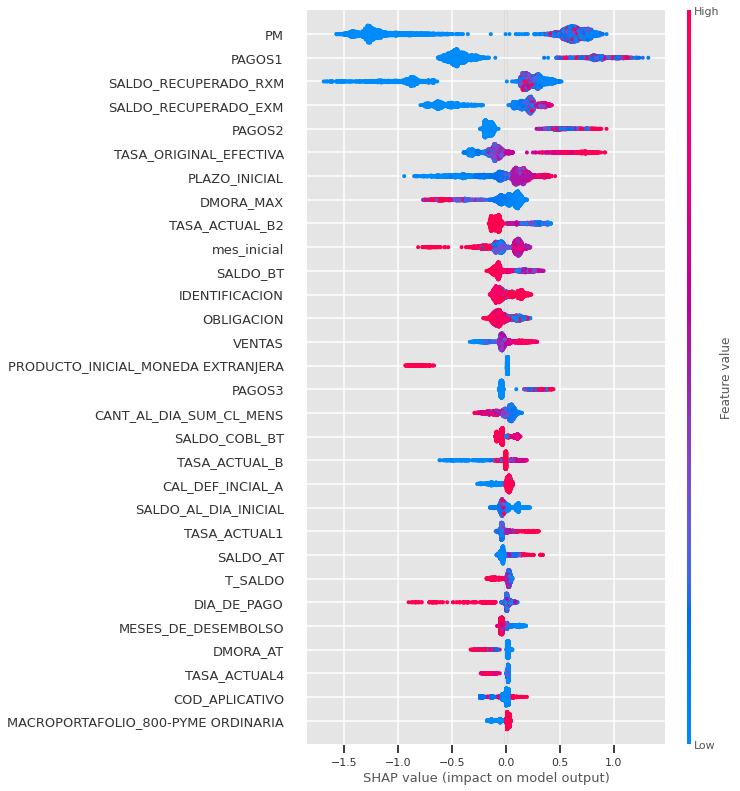

In [104]:
explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, max_display=30, feature_names=df_train.drop(['ID_PAGOS'], axis=1).columns)

**Pyme Grande 30**
-----------------------------------------------

In [112]:
#@title Segmentación Pyme : Pyme Grande 30
df_train = df[(df.SUBSEGMENTO=='Pyme Grande') & (df.RXE1==30)]

df_train = df_train.drop(['SUBSEGMENTO', 'RXE1'],axis=1)
df_train = pd.get_dummies(df_train)
df_train = shuffle(df_train)

#Entrenamos hasta el mes de diciembre para realizar las pruebas en: Enero y Febrero
X = df_train[  (df_train.mes_inicial!=14) & (df_train.mes_inicial!=13)]
y = X[['ID_PAGOS']]
X = X.drop("ID_PAGOS", axis=1)
###############################################################

Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:  1.3min finished


[0]	validation_0-error:0.298554	validation_0-logloss:0.673634	validation_1-error:0.326633	validation_1-logloss:0.675112
[1]	validation_0-error:0.188142	validation_0-logloss:0.643051	validation_1-error:0.207705	validation_1-logloss:0.645863
[2]	validation_0-error:0.172428	validation_0-logloss:0.615082	validation_1-error:0.175042	validation_1-logloss:0.617441
[3]	validation_0-error:0.166771	validation_0-logloss:0.590275	validation_1-error:0.170854	validation_1-logloss:0.593037
[4]	validation_0-error:0.168448	validation_0-logloss:0.569061	validation_1-error:0.170854	validation_1-logloss:0.570747
[5]	validation_0-error:0.167819	validation_0-logloss:0.551191	validation_1-error:0.169179	validation_1-logloss:0.553334
[6]	validation_0-error:0.166143	validation_0-logloss:0.534987	validation_1-error:0.169179	validation_1-logloss:0.537038
[7]	validation_0-error:0.165933	validation_0-logloss:0.52123	validation_1-error:0.167504	validation_1-logloss:0.523141
[8]	validation_0-error:0.164676	validatio

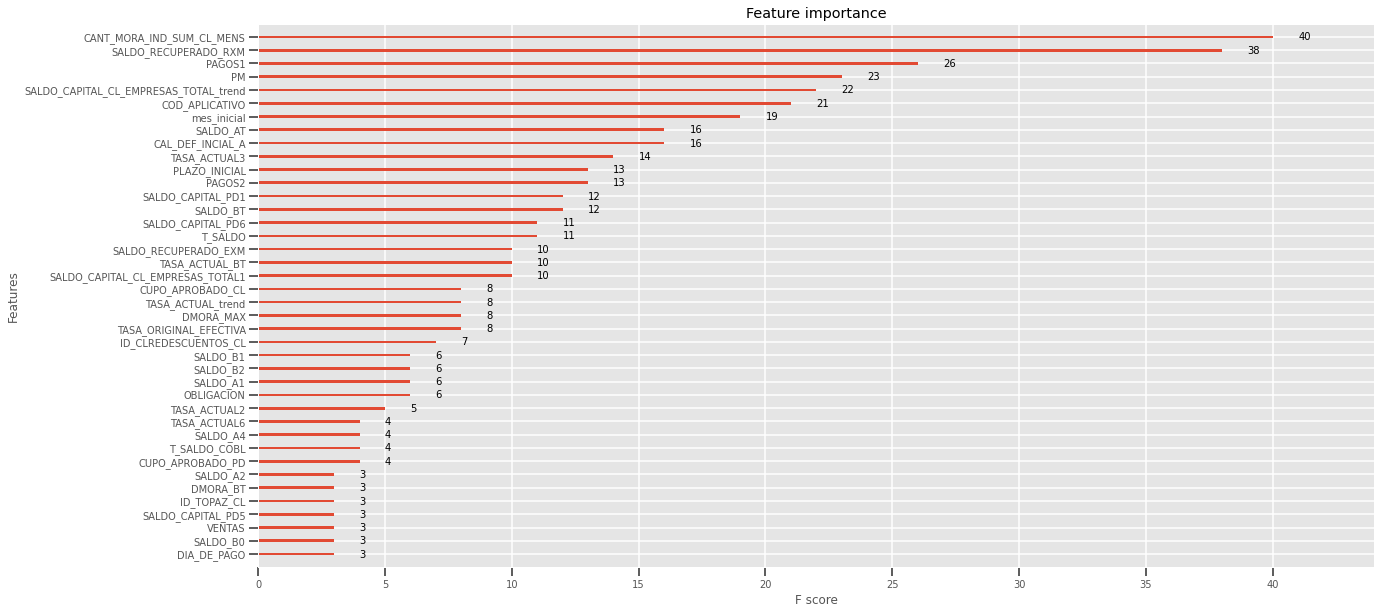

In [113]:
%%time
#################################### Balanceo de datos


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = seed, shuffle=True, stratify=y)

weight_class=y_train.ID_PAGOS.value_counts()[0]/y_train.ID_PAGOS.value_counts()[1] #(segun la documentacion de xgboost sum(negative instances) / sum(positive instances)




######################Modelado Xgboost


model_xgb = model_xgboost(X_train, y_train, X_test, y_test, weight=weight_class ,grid_hiper=True)

%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 10.0)
sns.set_context("talk", font_scale=0.6)
plt.style.use('ggplot')
plot_importance(model_xgb, max_num_features= 40)

filename = ruta+ "/modelo_xgb_pymegrande30.sav"
pickle.dump(model_xgb, open(filename, 'wb'))

##############################################################################################
###################################################################################################
print_score(model_xgb, X_train, y_train, X_test, y_test, train=True)
print_score(model_xgb, X_train, y_train, X_test, y_test, train=False)

**Función de pérdida**

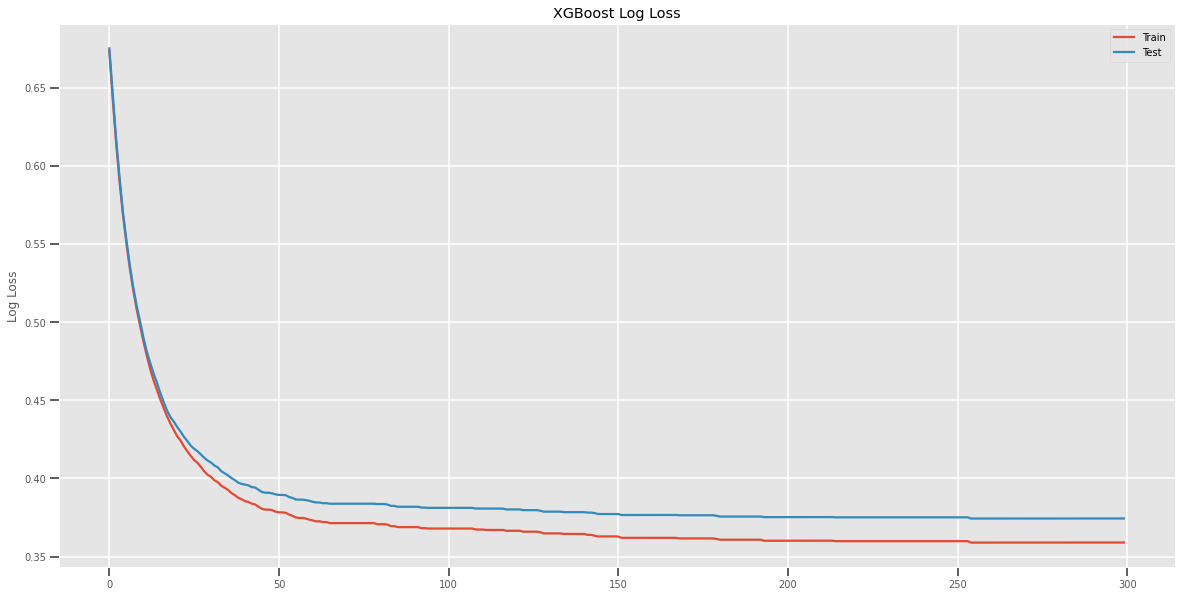

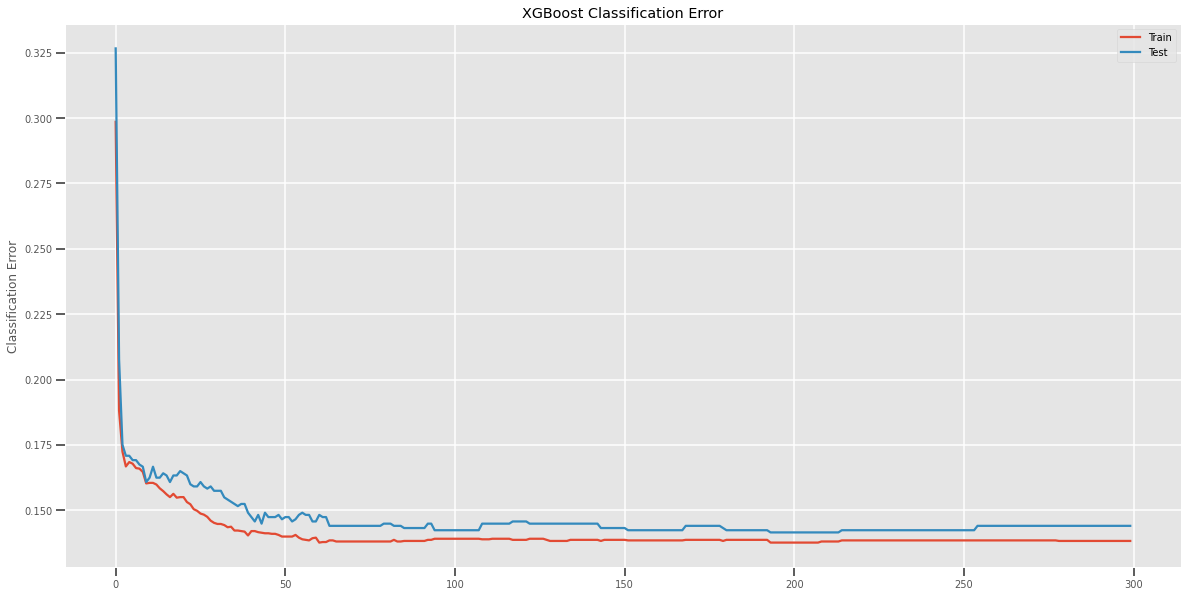

In [114]:
# retrieve performance metrics
results = model_xgb.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

In [115]:
#Dataframe de resultados

idx= ['Resultados_X_train', 'Resultados_X_val', 'Resultados_X_test_enero', 'Resultados_X_test_febrero']


y_train_pred = model_xgb.predict(X_train)

p = model_xgb.predict_proba(X_train)
fp_rates, tp_rates, _ = roc_curve(y_train,p[:,1])
roc_auc = auc(fp_rates, tp_rates)

resultados_eval = pd.DataFrame(index=idx)
resultados_eval.loc['Resultados_X_train','Precision'] = precision_score(y_train, y_train_pred )
resultados_eval.loc['Resultados_X_train','Recall'] = recall_score(y_train, y_train_pred )
resultados_eval.loc['Resultados_X_train','ROC_AUC'] = roc_auc_score(y_train, y_train_pred )
resultados_eval.loc['Resultados_X_train', 'F1_Score'] = f1_score(y_train, y_train_pred )
resultados_eval.loc['Resultados_X_train', 'RMSE'] =np.sqrt( mean_squared_error(y_train, y_train_pred ))
resultados_eval.loc['Resultados_X_train', 'AUC'] = roc_auc
resultados_eval.loc['Resultados_X_train', 'Accuracy'] = accuracy_score(y_train, y_train_pred )

#------------------------------------------------------------------------------------------------------------
#Resultados de validación
#------------------------------------------------------------------------------------------------------------

y_test_pred = model_xgb.predict(X_test)
p = model_xgb.predict_proba(X_test)
fp_rates, tp_rates, _ = roc_curve(y_test,p[:,1])
roc_auc = auc(fp_rates, tp_rates)

resultados_eval.loc['Resultados_X_val','Precision'] = precision_score(y_test, y_test_pred )
resultados_eval.loc['Resultados_X_val','Recall'] = recall_score(y_test, y_test_pred )
resultados_eval.loc['Resultados_X_val','ROC_AUC'] = roc_auc_score(y_test, y_test_pred )
resultados_eval.loc['Resultados_X_val', 'F1_Score'] = f1_score(y_test, y_test_pred )
resultados_eval.loc['Resultados_X_val', 'RMSE'] =np.sqrt( mean_squared_error(y_test, y_test_pred ))
resultados_eval.loc['Resultados_X_val', 'AUC'] = roc_auc
resultados_eval.loc['Resultados_X_val', 'Accuracy'] = accuracy_score(y_test, y_test_pred)

In [116]:
## Mejores parámetros para este modelo
model_xgb

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=10, eta=0.25,
              eval_metric=['error', 'logloss'], gamma=6, learning_rate=0.1,
              max_delta_step=7, max_depth=5, min_child_weight=16, missing=None,
              n_estimators=300, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=15,
              reg_lambda=11, sampling_method='uniform',
              scale_pos_weight=0.7704005934718101, seed=None, silent=None,
              subsample=0.95, verbosity=1)

**Resultados Enero**

Resultados de validación:

accuracy score: 0.7959

Reporte de clasificación: 
               precision    recall  f1-score   support

           0       0.62      0.90      0.73       288
           1       0.94      0.75      0.83       638

    accuracy                           0.80       926
   macro avg       0.78      0.82      0.78       926
weighted avg       0.84      0.80      0.80       926


Confusion Matrix: 
 [[259  29]
 [160 478]]

RMSE 
0.4517783435560668

MSLE 
0.09806222422304543

F1-score 
0.834934497816594

Recall 
0.7492163009404389

Presicion 
0.9428007889546351



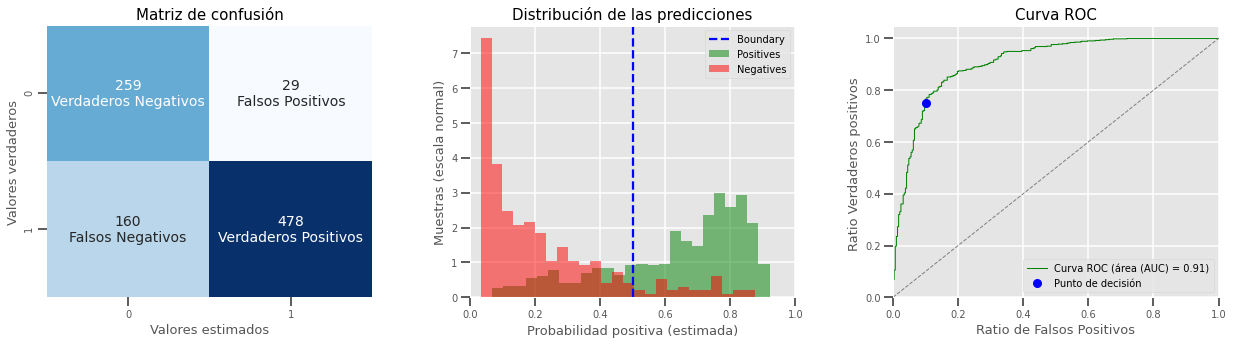

In [117]:
##Evaluación para el mes de enero
X_test_p =  df_train[(df_train.mes_inicial==13)] 
y_test_p = X_test_p[['ID_PAGOS']]
X_test_p = X_test_p.drop("ID_PAGOS", axis=1)

print_score(model_xgb, X_test_p, y_test_p, X_test_p, y_test_p, train=False, valid=True)
###################################################################################################

F1 = evalBinaryClassifier(model_xgb, X_test_p, y_test_p)


In [118]:
y_test_pred = model_xgb.predict(X_test_p)
p = model_xgb.predict_proba(X_test_p)
fp_rates, tp_rates, _ = roc_curve(y_test_p,p[:,1])
roc_auc = auc(fp_rates, tp_rates)
resultados_eval.loc['Resultados_X_test_enero','Precision'] = precision_score(y_test_p, y_test_pred )
resultados_eval.loc['Resultados_X_test_enero','Recall'] = recall_score(y_test_p, y_test_pred )
resultados_eval.loc['Resultados_X_test_enero','ROC_AUC'] = roc_auc_score(y_test_p, y_test_pred )
resultados_eval.loc['Resultados_X_test_enero', 'F1_Score'] = f1_score(y_test_p, y_test_pred )
resultados_eval.loc['Resultados_X_test_enero', 'RMSE'] =np.sqrt( mean_squared_error(y_test_p, y_test_pred ))
resultados_eval.loc['Resultados_X_test_enero', 'AUC'] = roc_auc
resultados_eval.loc['Resultados_X_test_enero', 'Accuracy'] = accuracy_score(y_test_p, y_test_pred)

In [119]:
resultados_eval

Precision    Recall   ROC_AUC  F1_Score      RMSE  \
Resultados_X_train          0.871804  0.885386  0.858196  0.878543  0.371857   
Resultados_X_val            0.866959  0.879822  0.852411  0.873343  0.379544   
Resultados_X_test_enero     0.942801  0.749216  0.824261  0.834934  0.451778   
Resultados_X_test_febrero        NaN       NaN       NaN       NaN       NaN   

                                AUC  Accuracy  
Resultados_X_train         0.928394  0.861722  
Resultados_X_val           0.915108  0.855946  
Resultados_X_test_enero    0.907504  0.795896  
Resultados_X_test_febrero       NaN       NaN

In [120]:
resultados_eval.to_csv( ruta+ "/tabla_desempeño_pymeg30.csv", index=False)

**Resultados Febrero**


*Para validar el modelo en febrero cargamos el modelo entrenado anteriormente*

In [ ]:
model_xgb = pickle.load(open(ruta+ "/modelo_xgb_pymegrande30.sav", 'rb'))

#####################Cargamos el esquema de entrenamiento para darselo al marco de datos nuevo

esquema_train = pd.read_csv(ruta+"esquema_de_entrenamiento_pymeg30.csv")
columns_train = esquema_train.columns

*Repetimos un procedimieno análogo al descrito anteriormente para poder evaluar los datos de febrero. Nota debemos crear df_train que se crea en la primera linea de este modelo, esta linea del código da la estructura para evaluar nuestros datos.*


In [ ]:
##Evaluación para el mes de Febrero
X_test_p =  df_train[(df_train.mes_inicial==14)] 

#############Definir esquema
X_test_p = X_test_p[columns_train]
y_test_p = X_test_p[['ID_PAGOS']]
X_test_p = X_test_p.drop("ID_PAGOS", axis=1)


print_score(model_xgb, X_test_p, y_test_p, X_test_p, y_test_p, train=False, valid=True)
###################################################################################################

F1 = evalBinaryClassifier(model_xgb, X_test_p, y_test_p)


**¿Cómo está aprendiendo el modelo?**

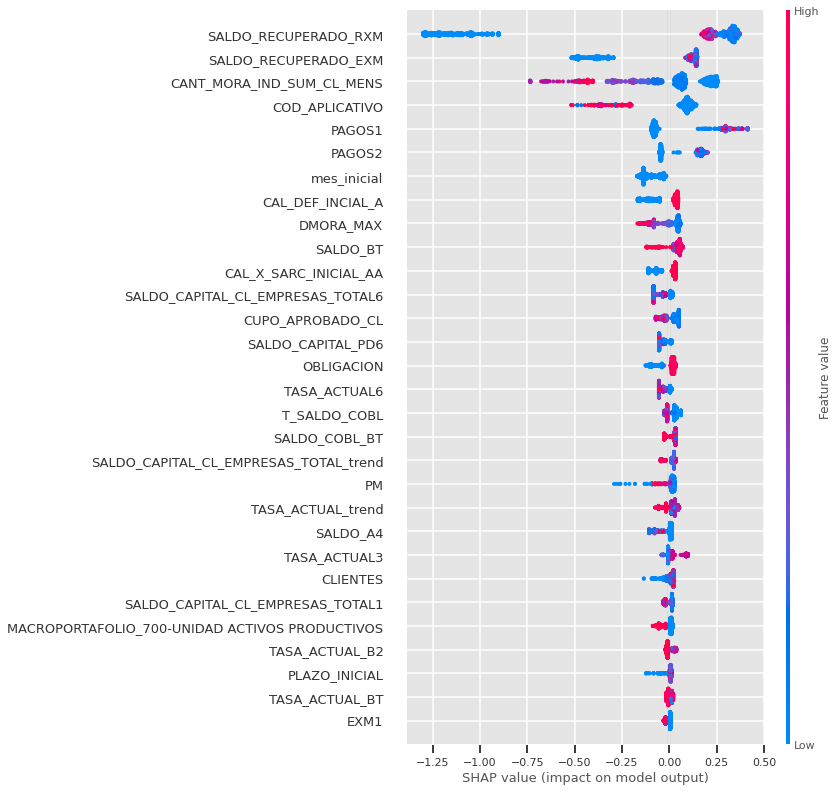

In [ ]:
explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(X_test_p)
shap.summary_plot(shap_values, X_test_p, max_display=30, feature_names=df_train.drop(['ID_PAGOS'], axis=1).columns)

**Pyme Grande 60**
-----------------------------------------------------------------------------

In [14]:
#@title Segmentación Pyme : Pyme Grande 60
df_train = df[(df.SUBSEGMENTO=='Pyme Grande') & (df.RXE1==60)]

df_train = df_train.drop(['SUBSEGMENTO', 'RXE1'],axis=1)
df_train = pd.get_dummies(df_train)
df_train = shuffle(df_train)

#Entrenamos hasta el mes de diciembre para realizar las pruebas en: Enero y Febrero
df_train.reset_index(inplace=True, drop=True)
X = df_train[  (df_train.mes_inicial!=14) & (df_train.mes_inicial!=13)]
y = X[['ID_PAGOS']]
X = X.drop("ID_PAGOS", axis=1)
w = y.ID_PAGOS.value_counts()[0]/y.ID_PAGOS.value_counts()[1]
###############################################################

In [15]:
y.value_counts()

ID_PAGOS
0           891
1           530
dtype: int64

Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:   19.8s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:   19.8s finished


[0]	validation_0-error:0.344288	validation_0-logloss:0.684097	validation_1-error:0.342657	validation_1-logloss:0.684051
[1]	validation_0-error:0.271518	validation_0-logloss:0.669196	validation_1-error:0.216783	validation_1-logloss:0.664865
[2]	validation_0-error:0.254304	validation_0-logloss:0.654585	validation_1-error:0.230769	validation_1-logloss:0.649674
[3]	validation_0-error:0.257434	validation_0-logloss:0.641447	validation_1-error:0.251748	validation_1-logloss:0.634062
[4]	validation_0-error:0.230047	validation_0-logloss:0.6321	validation_1-error:0.202797	validation_1-logloss:0.625798
[5]	validation_0-error:0.251956	validation_0-logloss:0.622217	validation_1-error:0.20979	validation_1-logloss:0.614708
[6]	validation_0-error:0.256651	validation_0-logloss:0.613348	validation_1-error:0.20979	validation_1-logloss:0.604045
[7]	validation_0-error:0.239437	validation_0-logloss:0.607333	validation_1-error:0.230769	validation_1-logloss:0.598766
[8]	validation_0-error:0.258216	validation_0

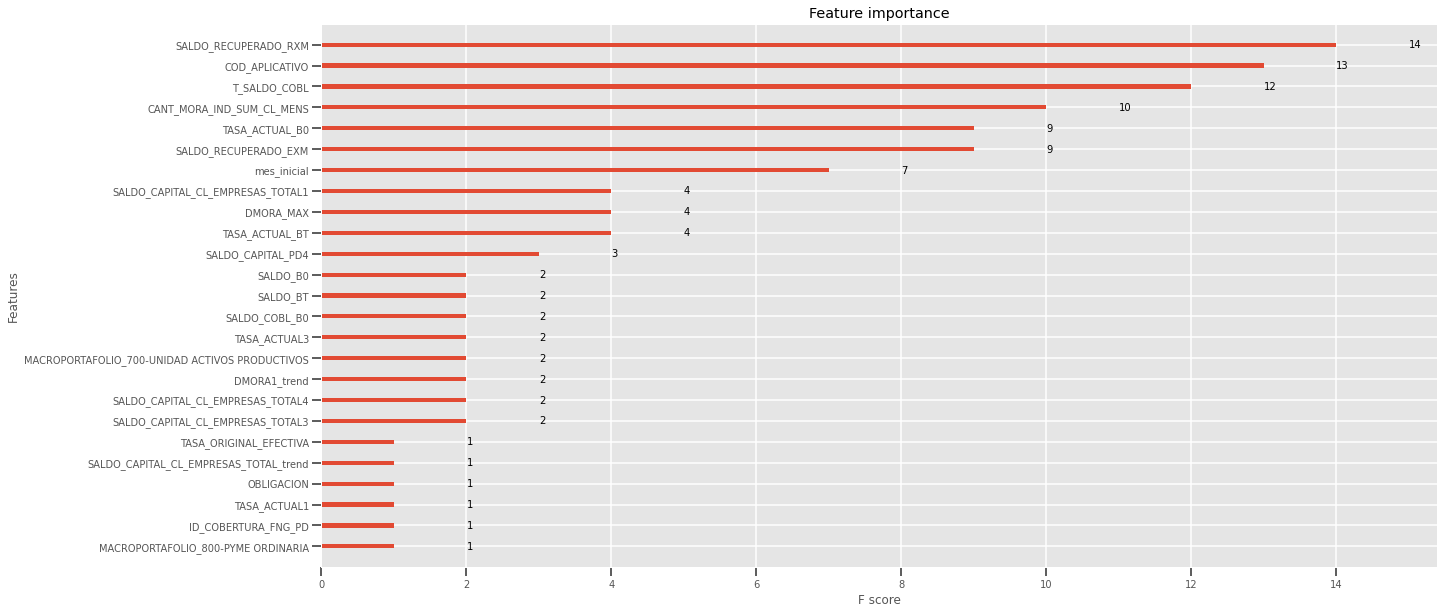

In [16]:
%%time
#################################### Balanceo de datos


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = seed, shuffle=True, stratify=y)

weight_class=y_train.ID_PAGOS.value_counts()[0]/y_train.ID_PAGOS.value_counts()[1] #(segun la documentacion de xgboost sum(negative instances) / sum(positive instances)




######################Modelado Xgboost


model_xgb = model_xgboost(X_train, y_train, X_test, y_test, weight=weight_class ,grid_hiper=True)

%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 10.0)
sns.set_context("talk", font_scale=0.6)
plt.style.use('ggplot')
plot_importance(model_xgb, max_num_features= 40)

#filename = ruta+ "/modelo_xgb_pymegrande60.sav"
#pickle.dump(model_xgb, open(filename, 'wb'))

##############################################################################################
###################################################################################################
print_score(model_xgb, X_train, y_train, X_test, y_test, train=True)
print_score(model_xgb, X_train, y_train, X_test, y_test, train=False)

**Función de pérdida**

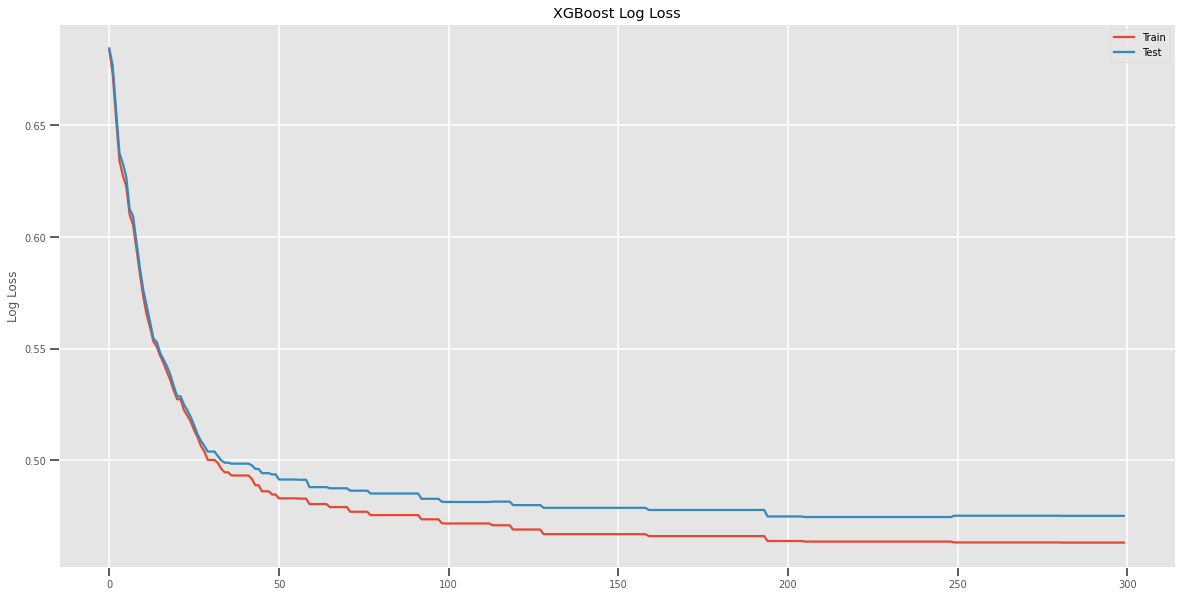

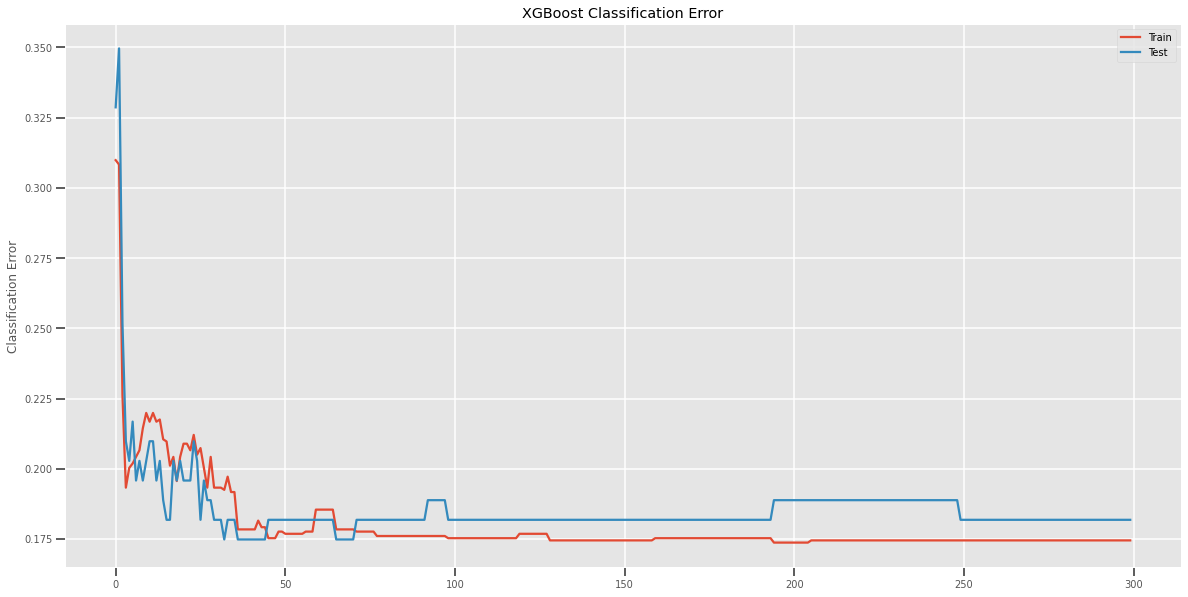

In [146]:
# retrieve performance metrics
results = model_xgb.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

In [147]:
#Dataframe de resultados

idx= ['Resultados_X_train', 'Resultados_X_val', 'Resultados_X_test_enero', 'Resultados_X_test_febrero']


y_train_pred = model_xgb.predict(X_train)

p = model_xgb.predict_proba(X_train)
fp_rates, tp_rates, _ = roc_curve(y_train,p[:,1])
roc_auc = auc(fp_rates, tp_rates)

resultados_eval = pd.DataFrame(index=idx)
resultados_eval.loc['Resultados_X_train','Precision'] = precision_score(y_train, y_train_pred )
resultados_eval.loc['Resultados_X_train','Recall'] = recall_score(y_train, y_train_pred )
resultados_eval.loc['Resultados_X_train','ROC_AUC'] = roc_auc_score(y_train, y_train_pred )
resultados_eval.loc['Resultados_X_train', 'F1_Score'] = f1_score(y_train, y_train_pred )
resultados_eval.loc['Resultados_X_train', 'RMSE'] =np.sqrt( mean_squared_error(y_train, y_train_pred ))
resultados_eval.loc['Resultados_X_train', 'AUC'] = roc_auc
resultados_eval.loc['Resultados_X_train', 'Accuracy'] = accuracy_score(y_train, y_train_pred )

#------------------------------------------------------------------------------------------------------------
#Resultados de validación
#------------------------------------------------------------------------------------------------------------

y_test_pred = model_xgb.predict(X_test)
p = model_xgb.predict_proba(X_test)
fp_rates, tp_rates, _ = roc_curve(y_test,p[:,1])
roc_auc = auc(fp_rates, tp_rates)

resultados_eval.loc['Resultados_X_val','Precision'] = precision_score(y_test, y_test_pred )
resultados_eval.loc['Resultados_X_val','Recall'] = recall_score(y_test, y_test_pred )
resultados_eval.loc['Resultados_X_val','ROC_AUC'] = roc_auc_score(y_test, y_test_pred )
resultados_eval.loc['Resultados_X_val', 'F1_Score'] = f1_score(y_test, y_test_pred )
resultados_eval.loc['Resultados_X_val', 'RMSE'] =np.sqrt( mean_squared_error(y_test, y_test_pred ))
resultados_eval.loc['Resultados_X_val', 'AUC'] = roc_auc
resultados_eval.loc['Resultados_X_val', 'Accuracy'] = accuracy_score(y_test, y_test_pred)

In [148]:
## Mejores parámetros para este modelo
model_xgb

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.2,
              early_stopping_rounds=10, eta=0.4,
              eval_metric=['error', 'logloss'], gamma=8, learning_rate=0.1,
              max_delta_step=10, max_depth=5, min_child_weight=5, missing=None,
              n_estimators=300, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=22,
              reg_lambda=15, sampling_method='uniform',
              scale_pos_weight=1.679245283018868, seed=None, silent=None,
              subsample=0.8, verbosity=1)

**Resultados Enero**

Resultados de validación:

accuracy score: 0.7929

Reporte de clasificación: 
               precision    recall  f1-score   support

           0       0.82      0.91      0.86       222
           1       0.69      0.48      0.57        87

    accuracy                           0.79       309
   macro avg       0.75      0.70      0.72       309
weighted avg       0.78      0.79      0.78       309


Confusion Matrix: 
 [[203  19]
 [ 45  42]]

RMSE 
0.4551040991908594

MSLE 
0.09951130385360805

F1-score 
0.5675675675675675

Recall 
0.4827586206896552

Presicion 
0.6885245901639344



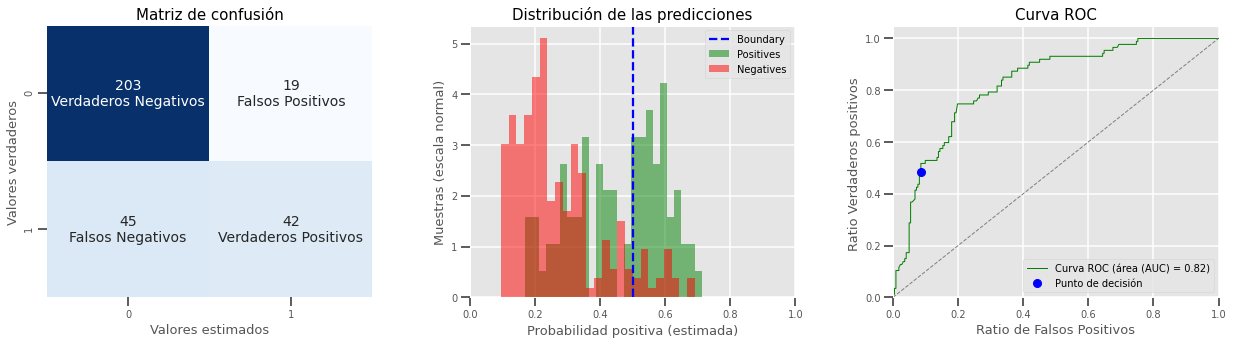

In [149]:
##Evaluación para el mes de enero
X_test_p =  df_train[(df_train.mes_inicial==13)] 
y_test_p = X_test_p[['ID_PAGOS']]
X_test_p = X_test_p.drop("ID_PAGOS", axis=1)

print_score(model_xgb, X_test_p, y_test_p, X_test_p, y_test_p, train=False, valid=True)
###################################################################################################

F1 = evalBinaryClassifier(model_xgb, X_test_p, y_test_p)

In [152]:
y_test_pred = model_xgb.predict(X_test_p)
p = model_xgb.predict_proba(X_test_p)
fp_rates, tp_rates, _ = roc_curve(y_test_p,p[:,1])
roc_auc = auc(fp_rates, tp_rates)
resultados_eval.loc['Resultados_X_test_enero','Precision'] = precision_score(y_test_p, y_test_pred )
resultados_eval.loc['Resultados_X_test_enero','Recall'] = recall_score(y_test_p, y_test_pred )
resultados_eval.loc['Resultados_X_test_enero','ROC_AUC'] = roc_auc_score(y_test_p, y_test_pred )
resultados_eval.loc['Resultados_X_test_enero', 'F1_Score'] = f1_score(y_test_p, y_test_pred )
resultados_eval.loc['Resultados_X_test_enero', 'RMSE'] =np.sqrt( mean_squared_error(y_test_p, y_test_pred ))
resultados_eval.loc['Resultados_X_test_enero', 'AUC'] = roc_auc
resultados_eval.loc['Resultados_X_test_enero', 'Accuracy'] = accuracy_score(y_test_p, y_test_pred)

In [153]:
resultados_eval

Precision    Recall   ROC_AUC  F1_Score      RMSE  \
Resultados_X_train          0.715986  0.882600  0.837055  0.790610  0.417722   
Resultados_X_val            0.707692  0.867925  0.828407  0.779661  0.426401   
Resultados_X_test_enero     0.688525  0.482759  0.698587  0.567568  0.455104   
Resultados_X_test_febrero        NaN       NaN       NaN       NaN       NaN   

                                AUC  Accuracy  
Resultados_X_train         0.898645  0.825509  
Resultados_X_val           0.884067  0.818182  
Resultados_X_test_enero    0.824868  0.792880  
Resultados_X_test_febrero       NaN       NaN

In [154]:
resultados_eval.to_csv( ruta+ "/tabla_desempeño_pymeg60.csv", index=False)

**Resultados Febrero**

*Para validar el modelo en febrero cargamos el modelo entrenado anteriormente*

In [ ]:
model_xgb = pickle.load(open(ruta+ "/modelo_xgb_pymegrande60.sav", 'rb'))

#####################Cargamos el esquema de entrenamiento para darselo al marco de datos nuevo

esquema_train = pd.read_csv(ruta+"esquema_de_entrenamiento_pymeg60.csv")
columns_train = esquema_train.columns

*Repetimos un procedimieno análogo al descrito anteriormente para poder evaluar los datos de febrero. Nota debemos crear df_train que se crea en la primera linea de este modelo, esta linea del código da la estructura para evaluar nuestros datos.*


In [ ]:
##Evaluación para el mes de febrero
X_test_p =  df_train[(df_train.mes_inicial==14)] 

#############Definir esquema
X_test_p = X_test_p[columns_train]
y_test_p = X_test_p[['ID_PAGOS']]
X_test_p = X_test_p.drop("ID_PAGOS", axis=1)

print_score(model_xgb, X_test_p, y_test_p, X_test_p, y_test_p, train=False, valid=True)
###################################################################################################

F1 = evalBinaryClassifier(model_xgb, X_test_p, y_test_p)

In [ ]:
resultados_eval = pd.read_csv(  ruta+ "/tabla_desempeño_pymeg60.csv")
y_test_pred = model_xgb.predict(X_test_p.values)
p = model_xgb.predict_proba(X_test_p.values)
fp_rates, tp_rates, _ = roc_curve(y_test_p.values,p[:,1])
roc_auc = auc(fp_rates, tp_rates)
resultados_eval.loc['Resultados_X_test_febrero','Precision'] = precision_score(y_test_p.values, y_test_pred )
resultados_eval.loc['Resultados_X_test_febrero','Recall'] = recall_score(y_test_p.values, y_test_pred )
resultados_eval.loc['Resultados_X_test_febrero','ROC_AUC'] = roc_auc_score(y_test_p.values, y_test_pred )
resultados_eval.loc['Resultados_X_test_febrero', 'F1_Score'] = f1_score(y_test_p.values, y_test_pred )
resultados_eval.loc['Resultados_X_test_febrero', 'RMSE'] =np.sqrt( mean_squared_error(y_test_p.values, y_test_pred ))
resultados_eval.loc['Resultados_X_test_febrero', 'AUC'] = roc_auc
resultados_eval.loc['Resultados_X_test_febrero', 'Accuracy'] = accuracy_score(y_test_p.values, y_test_pred)
resultados_eval = resultados_eval.drop(3)
resultados_eval = resultados_eval.rename(index ={0:'Resultados_X_train', 1:'Resultados_X_Val', 2:'Resultados_X_test_enero'})
resultados_eval.loc['Modelo'] ='Pyme Grande 60'

In [ ]:
resultados_eval

In [ ]:
resultados_eval.to_csv(  ruta+ "/tabla_desempeño_pymeg60_feb.csv")

**¿Cómo está aprendiendo el modelo?**

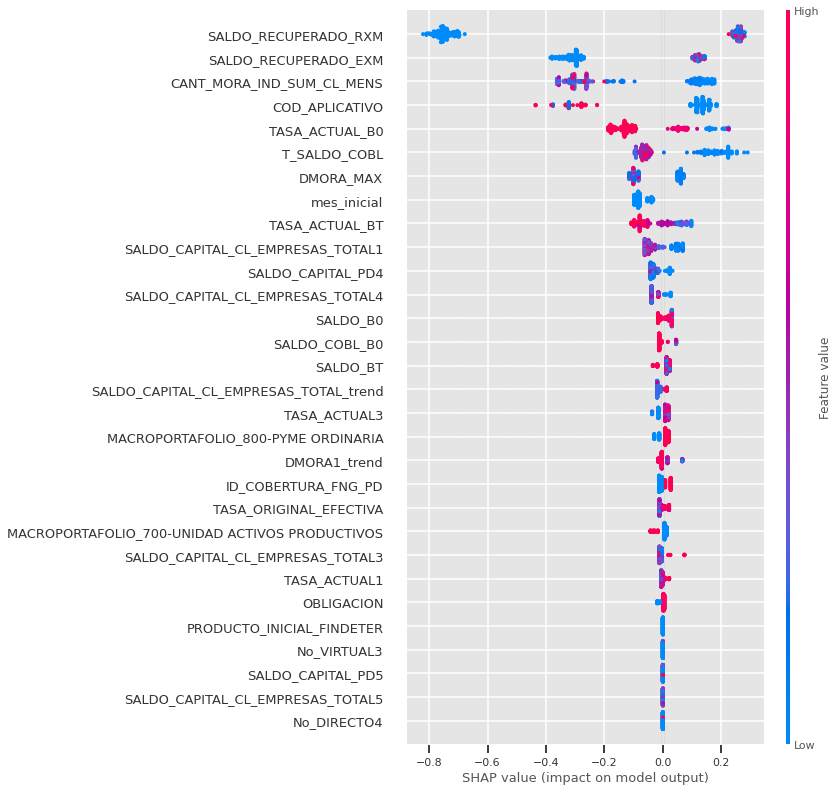

In [20]:
explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(X_test_p)
shap.summary_plot(shap_values, X_test_p, max_display=30, feature_names=df_train.drop(['ID_PAGOS'], axis=1).columns)

**Pyme Grande 90**
----------------------------------------------------

In [ ]:
#@title Segmentación Pyme : Pyme Grande 90
df_train = df[(df.SUBSEGMENTO=='Pyme Grande') & (df.RXE1==90) ]

df_train = df_train.drop(['SUBSEGMENTO', 'RXE1'],axis=1)
df_train = pd.get_dummies(df_train)
df_train = shuffle(df_train)

#Entrenamos hasta el mes de diciembre para realizar las pruebas en: Enero y Febrero
X = df_train[  (df_train.mes_inicial!=14) ]
y = X[['ID_PAGOS']]
X = X.drop("ID_PAGOS", axis=1)
###############################################################

Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:   14.6s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:   14.6s finished


[0]	validation_0-error:0.445596	validation_0-logloss:0.687987	validation_1-error:0.415385	validation_1-logloss:0.686776
[1]	validation_0-error:0.162349	validation_0-logloss:0.66951	validation_1-error:0.138462	validation_1-logloss:0.667072
[2]	validation_0-error:0.160622	validation_0-logloss:0.652539	validation_1-error:0.138462	validation_1-logloss:0.650143
[3]	validation_0-error:0.148532	validation_0-logloss:0.640345	validation_1-error:0.138462	validation_1-logloss:0.635166
[4]	validation_0-error:0.160622	validation_0-logloss:0.625451	validation_1-error:0.138462	validation_1-logloss:0.619528
[5]	validation_0-error:0.160622	validation_0-logloss:0.612931	validation_1-error:0.138462	validation_1-logloss:0.605987
[6]	validation_0-error:0.164076	validation_0-logloss:0.602756	validation_1-error:0.138462	validation_1-logloss:0.594867
[7]	validation_0-error:0.164076	validation_0-logloss:0.593594	validation_1-error:0.138462	validation_1-logloss:0.584657
[8]	validation_0-error:0.176166	validatio

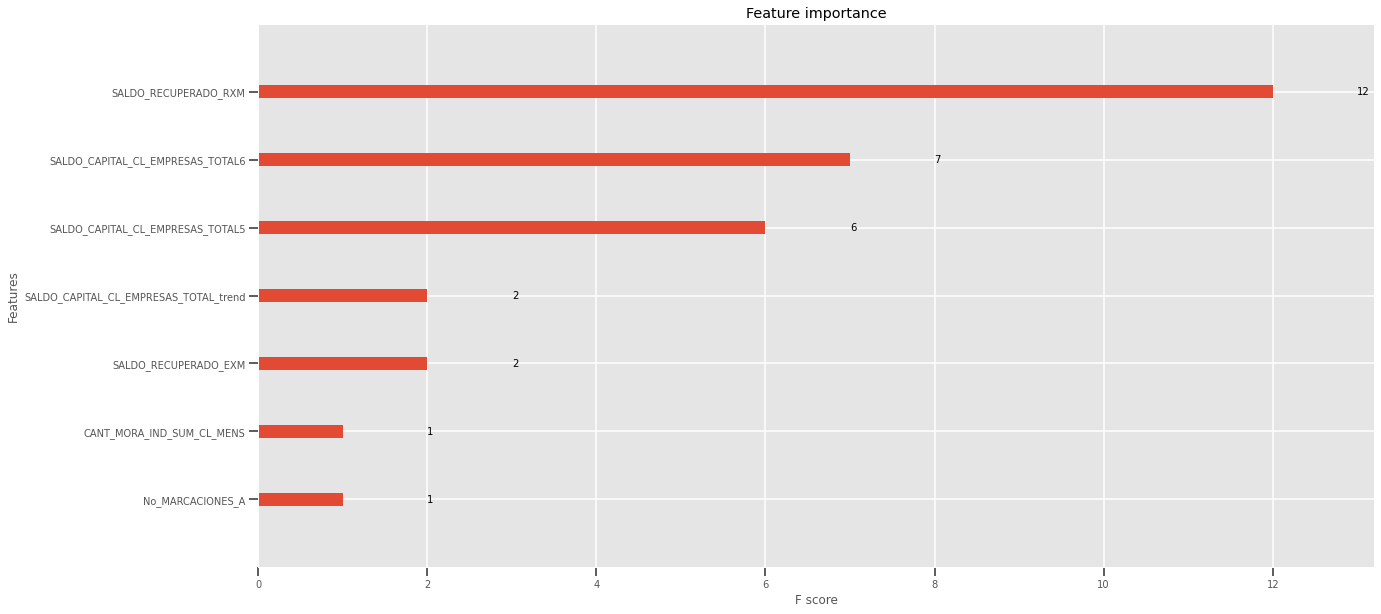

In [ ]:

#################################### Balanceo de datos



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = seed, shuffle=True, stratify=y)

weight_class=y_train.ID_PAGOS.value_counts()[0]/y_train.ID_PAGOS.value_counts()[1]


######################Modelado Xgboost


model_xgb = model_xgboost(X_train, y_train, X_test, y_test, weight=weight_class ,grid_hiper=True)


%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 10.0)
sns.set_context("talk", font_scale=0.6)
plt.style.use('ggplot')
plot_importance(model_xgb, max_num_features= 40)

filename = ruta+ "/modelo_xgb_pymeg90.sav"
pickle.dump(model_xgb, open(filename, 'wb'))


##############################################################################################
###################################################################################################
print_score(model_xgb, X_train, y_train, X_test, y_test, train=True)
print_score(model_xgb, X_train, y_train, X_test, y_test, train=False)

In [ ]:
#@title Dataframe de resultados

idx= ['Resultados_X_train', 'Resultados_X_val', 'Resultados_X_test_enero', 'Resultados_X_test_febrero']


y_train_pred = model_xgb.predict(X_train)

p = model_xgb.predict_proba(X_train)
fp_rates, tp_rates, _ = roc_curve(y_train,p[:,1])
roc_auc = auc(fp_rates, tp_rates)

resultados_eval = pd.DataFrame(index=idx)
resultados_eval.loc['Resultados_X_train','Precision'] = precision_score(y_train, y_train_pred )
resultados_eval.loc['Resultados_X_train','Recall'] = recall_score(y_train, y_train_pred )
resultados_eval.loc['Resultados_X_train','ROC_AUC'] = roc_auc_score(y_train, y_train_pred )
resultados_eval.loc['Resultados_X_train', 'F1_Score'] = f1_score(y_train, y_train_pred )
resultados_eval.loc['Resultados_X_train', 'RMSE'] =np.sqrt( mean_squared_error(y_train, y_train_pred ))
resultados_eval.loc['Resultados_X_train', 'AUC'] = roc_auc
resultados_eval.loc['Resultados_X_train', 'Accuracy'] = accuracy_score(y_train, y_train_pred )

#------------------------------------------------------------------------------------------------------------
#Resultados de validación
#------------------------------------------------------------------------------------------------------------

y_test_pred = model_xgb.predict(X_test)
p = model_xgb.predict_proba(X_test)
fp_rates, tp_rates, _ = roc_curve(y_test,p[:,1])
roc_auc = auc(fp_rates, tp_rates)

resultados_eval.loc['Resultados_X_val','Precision'] = precision_score(y_test, y_test_pred )
resultados_eval.loc['Resultados_X_val','Recall'] = recall_score(y_test, y_test_pred )
resultados_eval.loc['Resultados_X_val','ROC_AUC'] = roc_auc_score(y_test, y_test_pred )
resultados_eval.loc['Resultados_X_val', 'F1_Score'] = f1_score(y_test, y_test_pred )
resultados_eval.loc['Resultados_X_val', 'RMSE'] =np.sqrt( mean_squared_error(y_test, y_test_pred ))
resultados_eval.loc['Resultados_X_val', 'AUC'] = roc_auc
resultados_eval.loc['Resultados_X_val', 'Accuracy'] = accuracy_score(y_test, y_test_pred)

**Resultados Enero**

Resultados de validación:

accuracy score: 0.8595

Reporte de clasificación: 
               precision    recall  f1-score   support

           0       0.90      0.94      0.92       100
           1       0.62      0.48      0.54        21

    accuracy                           0.86       121
   macro avg       0.76      0.71      0.73       121
weighted avg       0.85      0.86      0.85       121


Confusion Matrix: 
 [[94  6]
 [11 10]]

RMSE 
0.37482778414706003

MSLE 
0.06750166311247457

F1-score 
0.5405405405405405

Recall 
0.47619047619047616

Presicion 
0.625



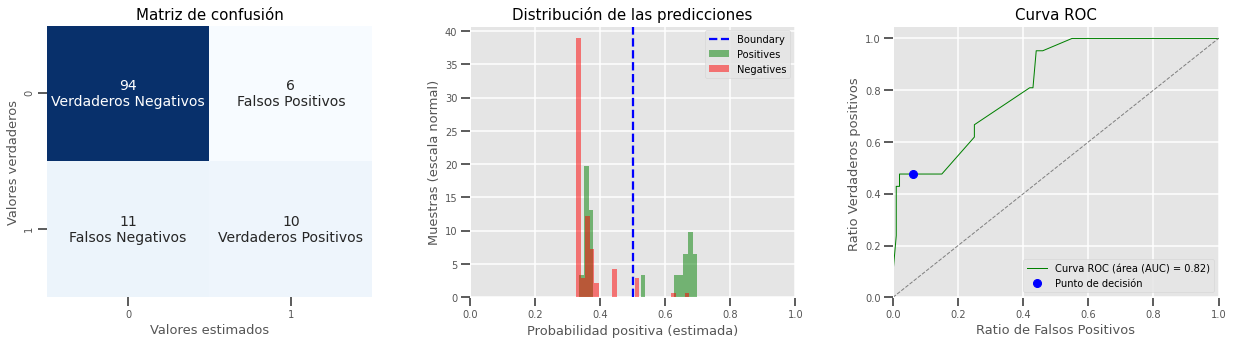

In [ ]:
##Evaluación para el mes de enero
X_test_p =  df_train[(df_train.mes_inicial==13)] 
y_test_p = X_test_p[['ID_PAGOS']]
X_test_p = X_test_p.drop("ID_PAGOS", axis=1)

print_score(model_xgb, X_test_p, y_test_p, X_test_p, y_test_p, train=False, valid=True)
###################################################################################################

F1 = evalBinaryClassifier(model_xgb, X_test_p, y_test_p)


In [ ]:
y_test_pred = model_xgb.predict(X_test_p)
p = model_xgb.predict_proba(X_test_p)
fp_rates, tp_rates, _ = roc_curve(y_test_p,p[:,1])
roc_auc = auc(fp_rates, tp_rates)
resultados_eval.loc['Resultados_X_test_enero','Precision'] = precision_score(y_test_p, y_test_pred )
resultados_eval.loc['Resultados_X_test_enero','Recall'] = recall_score(y_test_p, y_test_pred )
resultados_eval.loc['Resultados_X_test_enero','ROC_AUC'] = roc_auc_score(y_test_p, y_test_pred )
resultados_eval.loc['Resultados_X_test_enero', 'F1_Score'] = f1_score(y_test_p, y_test_pred )
resultados_eval.loc['Resultados_X_test_enero', 'RMSE'] =np.sqrt( mean_squared_error(y_test_p, y_test_pred ))
resultados_eval.loc['Resultados_X_test_enero', 'AUC'] = roc_auc
resultados_eval.loc['Resultados_X_test_enero', 'Accuracy'] = accuracy_score(y_test_p, y_test_pred)

In [ ]:
resultados_eval

In [ ]:
resultados_eval.to_csv( ruta+ "/tabla_desempeño_pymeg60.csv", index=False)

**Resultados Febrero**


*Para validar el modelo en febrero cargamos el modelo entrenado anteriormente*

In [ ]:
model_xgb = pickle.load(open(ruta+ "/modelo_xgb_pymegrande90.sav", 'rb'))

#####################Cargamos el esquema de entrenamiento para darselo al marco de datos nuevo

esquema_train = pd.read_csv(ruta+"esquema_de_entrenamiento_pymeg90.csv")
columns_train = esquema_train.columns

*Repetimos un procedimieno análogo al descrito anteriormente para poder evaluar los datos de febrero. Nota debemos crear df_train que se crea en la primera linea de este modelo, esta linea del código da la estructura para evaluar nuestros datos.*


Resultados de validación:

accuracy score: 0.6707

Reporte de clasificación: 
               precision    recall  f1-score   support

           0       0.72      0.87      0.79       117
           1       0.40      0.20      0.27        50

    accuracy                           0.67       167
   macro avg       0.56      0.54      0.53       167
weighted avg       0.62      0.67      0.63       167


Confusion Matrix: 
 [[102  15]
 [ 40  10]]

RMSE 
0.5738826686399141

MSLE 
0.1582330285359346

F1-score 
0.26666666666666666

Recall 
0.2

Presicion 
0.4



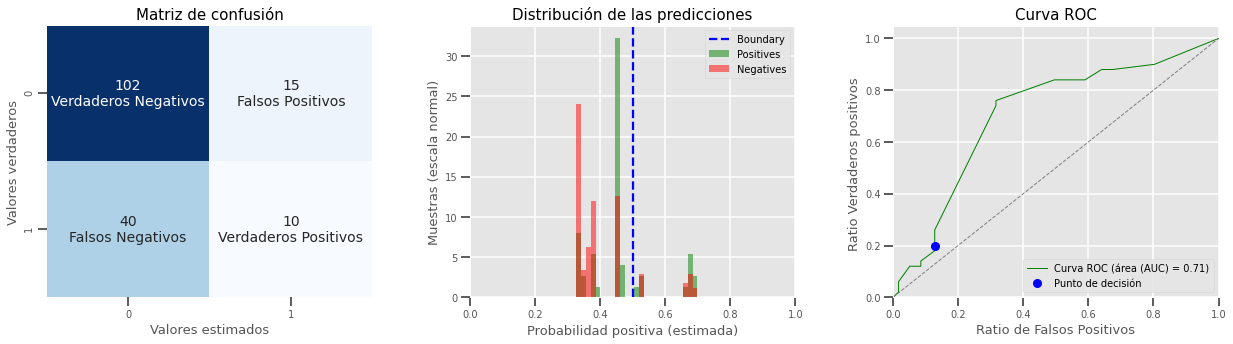

In [ ]:
##Evaluación para el mes de Febrero
X_test_p =  df_train[(df_train.mes_inicial==14)] 

#############Definir esquema
X_test_p = X_test_p[columns_train]
y_test_p = X_test_p[['ID_PAGOS']]
X_test_p = X_test_p.drop("ID_PAGOS", axis=1)

print_score(model_xgb, X_test_p, y_test_p, X_test_p, y_test_p, train=False, valid=True)
###################################################################################################

F1 = evalBinaryClassifier(model_xgb, X_test_p, y_test_p)

In [ ]:
resultados_eval = pd.read_csv( ruta+ "/tabla_desempeño_pymeg90.csv")
y_test_pred = model_xgb.predict(X_test_p.values)
p = model_xgb.predict_proba(X_test_p.values)
fp_rates, tp_rates, _ = roc_curve(y_test_p.values,p[:,1])
roc_auc = auc(fp_rates, tp_rates)
resultados_eval.loc['Resultados_X_test_febrero','Precision'] = precision_score(y_test_p.values, y_test_pred )
resultados_eval.loc['Resultados_X_test_febrero','Recall'] = recall_score(y_test_p.values, y_test_pred )
resultados_eval.loc['Resultados_X_test_febrero','ROC_AUC'] = roc_auc_score(y_test_p.values, y_test_pred )
resultados_eval.loc['Resultados_X_test_febrero', 'F1_Score'] = f1_score(y_test_p.values, y_test_pred )
resultados_eval.loc['Resultados_X_test_febrero', 'RMSE'] =np.sqrt( mean_squared_error(y_test_p.values, y_test_pred ))
resultados_eval.loc['Resultados_X_test_febrero', 'AUC'] = roc_auc
resultados_eval.loc['Resultados_X_test_febrero', 'Accuracy'] = accuracy_score(y_test_p.values, y_test_pred)
resultados_eval = resultados_eval.drop(3)
resultados_eval = resultados_eval.rename(index ={0:'Resultados_X_train', 1:'Resultados_X_Val', 2:'Resultados_X_test_enero'})
resultados_eval.loc['Modelo'] ='Pyme Grande 90'

In [ ]:
resultados_eval

In [ ]:
resultados_eval.to_csv( ruta+ "/tabla_desempeño_pymeg90_feb.csv")

**Pyme Grande 9999**
----------------------------------------

In [ ]:
#@title Segmentación Pyme : Pyme Grande 9999
df_train = df[(df.SUBSEGMENTO=='Pyme Grande') & (df.RXE1==9999)]

df_train = df_train.drop(['SUBSEGMENTO', 'RXE1'],axis=1)
df_train = pd.get_dummies(df_train)
df_train = shuffle(df_train)

#Entrenamos hasta el mes de diciembre para realizar las pruebas en: Enero y Febrero
X = df_train[  (df_train.mes_inicial!=14) & (df_train.mes_inicial!=13)]
y = X[['ID_PAGOS']]
X = X.drop("ID_PAGOS", axis=1)
###############################################################

Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:  1.3min finished


[0]	validation_0-error:0.098263	validation_0-logloss:0.559991	validation_1-error:0.046222	validation_1-logloss:0.574585
[1]	validation_0-error:0.072326	validation_0-logloss:0.473826	validation_1-error:0.072889	validation_1-logloss:0.494979
[2]	validation_0-error:0.043761	validation_0-logloss:0.383865	validation_1-error:0.053333	validation_1-logloss:0.403745
[3]	validation_0-error:0.03942	validation_0-logloss:0.334059	validation_1-error:0.057778	validation_1-logloss:0.36019
[4]	validation_0-error:0.037591	validation_0-logloss:0.281373	validation_1-error:0.051556	validation_1-logloss:0.307982
[5]	validation_0-error:0.034963	validation_0-logloss:0.243726	validation_1-error:0.051556	validation_1-logloss:0.273046
[6]	validation_0-error:0.032564	validation_0-logloss:0.222793	validation_1-error:0.053333	validation_1-logloss:0.253028
[7]	validation_0-error:0.028451	validation_0-logloss:0.194264	validation_1-error:0.045333	validation_1-logloss:0.222321
[8]	validation_0-error:0.025366	validation

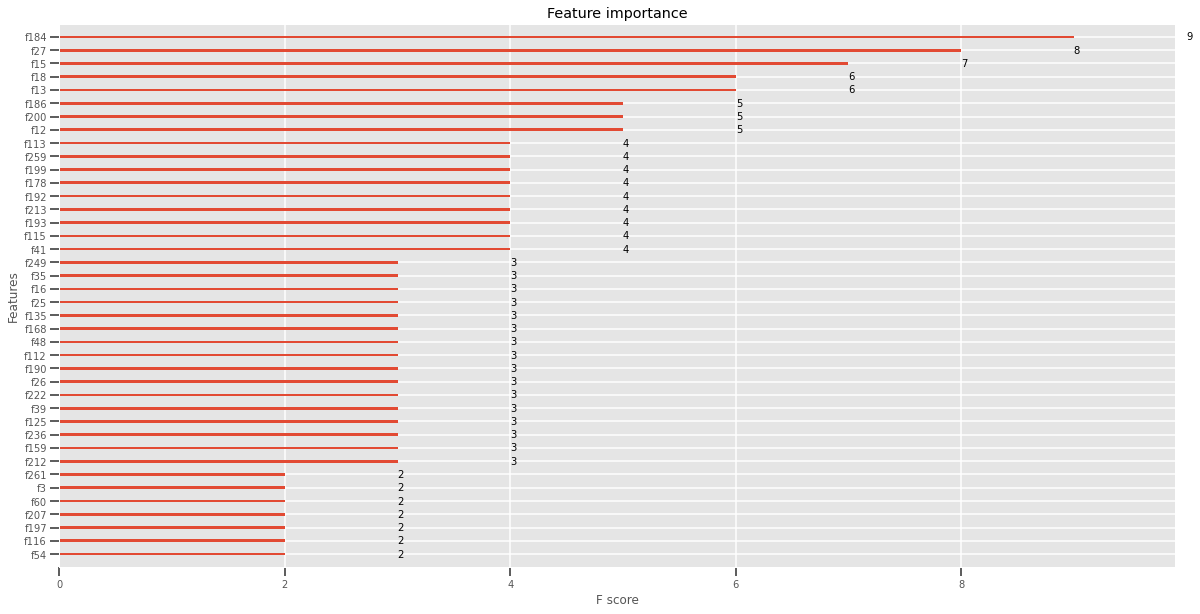

In [ ]:
over = SMOTE(sampling_strategy='minority', random_state=seed)
sc = StandardScaler()


#################################### Balanceo de datos



X_train_t, X_test, y_train_t, y_test = train_test_split(X, y, test_size = 0.2, random_state = seed, shuffle=True)
X_train, y_train = over.fit_resample(X_train_t, y_train_t)  # REALIZAMOS EL BALANCE DE LOS DATOS ANTES DE ESCALARLOS---> Train y Val

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


######################Modelado Xgboost


model_xgb = model_xgboost(X_train, y_train, X_test, y_test, weight=1 ,grid_hiper=True)

%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 10.0)
sns.set_context("talk", font_scale=0.6)
plt.style.use('ggplot')
plot_importance(model_xgb, max_num_features= 40)

filename = ruta+ "/modelo_xgb_pymegrande60.sav"
pickle.dump(model_xgb, open(filename, 'wb'))

##############################################################################################
###################################################################################################
print_score(model_xgb, X_train, y_train, X_test, y_test, train=True)
print_score(model_xgb, X_train, y_train, X_test, y_test, train=False)

**Función de pérdida**

In [ ]:
# retrieve performance metrics
results = model_xgb.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

In [ ]:
#Dataframe de resultados

idx= ['Resultados_X_train', 'Resultados_X_val', 'Resultados_X_test_enero', 'Resultados_X_test_febrero']


y_train_pred = model_xgb.predict(X_train)

p = model_xgb.predict_proba(X_train)
fp_rates, tp_rates, _ = roc_curve(y_train,p[:,1])
roc_auc = auc(fp_rates, tp_rates)

resultados_eval = pd.DataFrame(index=idx)
resultados_eval.loc['Resultados_X_train','Precision'] = precision_score(y_train, y_train_pred )
resultados_eval.loc['Resultados_X_train','Recall'] = recall_score(y_train, y_train_pred )
resultados_eval.loc['Resultados_X_train','ROC_AUC'] = roc_auc_score(y_train, y_train_pred )
resultados_eval.loc['Resultados_X_train', 'F1_Score'] = f1_score(y_train, y_train_pred )
resultados_eval.loc['Resultados_X_train', 'RMSE'] =np.sqrt( mean_squared_error(y_train, y_train_pred ))
resultados_eval.loc['Resultados_X_train', 'AUC'] = roc_auc
resultados_eval.loc['Resultados_X_train', 'Accuracy'] = accuracy_score(y_train, y_train_pred )

#------------------------------------------------------------------------------------------------------------
#Resultados de validación
#------------------------------------------------------------------------------------------------------------

y_test_pred = model_xgb.predict(X_test)
p = model_xgb.predict_proba(X_test)
fp_rates, tp_rates, _ = roc_curve(y_test,p[:,1])
roc_auc = auc(fp_rates, tp_rates)

resultados_eval.loc['Resultados_X_val','Precision'] = precision_score(y_test, y_test_pred )
resultados_eval.loc['Resultados_X_val','Recall'] = recall_score(y_test, y_test_pred )
resultados_eval.loc['Resultados_X_val','ROC_AUC'] = roc_auc_score(y_test, y_test_pred )
resultados_eval.loc['Resultados_X_val', 'F1_Score'] = f1_score(y_test, y_test_pred )
resultados_eval.loc['Resultados_X_val', 'RMSE'] =np.sqrt( mean_squared_error(y_test, y_test_pred ))
resultados_eval.loc['Resultados_X_val', 'AUC'] = roc_auc
resultados_eval.loc['Resultados_X_val', 'Accuracy'] = accuracy_score(y_test, y_test_pred)

In [ ]:
## Mejores parámetros para este modelo
model_xgb

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.2,
              early_stopping_rounds=10, eval_metric=['error', 'logloss'],
              gamma=9, learning_rate=0.4, max_delta_step=16, max_depth=4,
              min_child_weight=13, missing=None, n_estimators=150, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=19, reg_lambda=12, sampling_method='uniform',
              scale_pos_weight=1, seed=None, silent=None, subsample=0.6,
              verbosity=1)

**Resultados Enero**

Test Result:

accuracy score: 0.9818

Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       700
           1       0.60      0.40      0.48        15

    accuracy                           0.98       715
   macro avg       0.79      0.70      0.74       715
weighted avg       0.98      0.98      0.98       715


Confusion Matrix: 
 [[696   4]
 [  9   6]]

RMSE 
0.13483997249264842

MSLE 
0.008735509343967298

F1-score 
0.48

Recall 
0.4

Presicion 
0.6



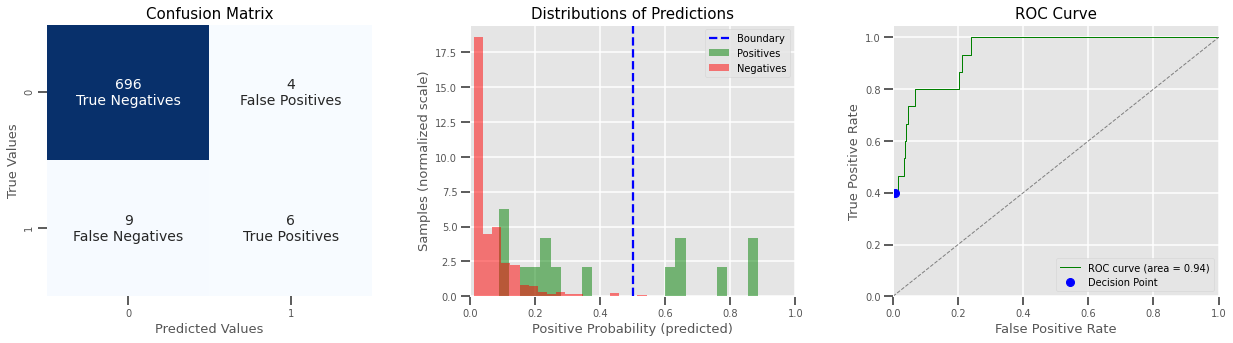

In [ ]:
##Evaluación para el mes de enero
X_test_p =  df_train[(df_train.mes_inicial==13)] 
y_test_p = X_test_p[['ID_PAGOS']]
X_test_p = X_test_p.drop("ID_PAGOS", axis=1)

print_score(model_xgb, X_test_p, y_test_p, X_test_p, y_test_p, train=False, valid=True)
###################################################################################################

F1 = evalBinaryClassifier(model_xgb, X_test_p, y_test_p)

In [ ]:
y_test_pred = model_xgb.predict(X_test_p)
p = model_xgb.predict_proba(X_test_p)
fp_rates, tp_rates, _ = roc_curve(y_test_p,p[:,1])
roc_auc = auc(fp_rates, tp_rates)
resultados_eval.loc['Resultados_X_test_enero','Precision'] = precision_score(y_test_p, y_test_pred )
resultados_eval.loc['Resultados_X_test_enero','Recall'] = recall_score(y_test_p, y_test_pred )
resultados_eval.loc['Resultados_X_test_enero','ROC_AUC'] = roc_auc_score(y_test_p, y_test_pred )
resultados_eval.loc['Resultados_X_test_enero', 'F1_Score'] = f1_score(y_test_p, y_test_pred )
resultados_eval.loc['Resultados_X_test_enero', 'RMSE'] =np.sqrt( mean_squared_error(y_test_p, y_test_pred ))
resultados_eval.loc['Resultados_X_test_enero', 'AUC'] = roc_auc
resultados_eval.loc['Resultados_X_test_enero', 'Accuracy'] = accuracy_score(y_test_p, y_test_pred)

In [ ]:
resultados_eval

Precision    Recall   ROC_AUC  F1_Score      RMSE  \
Resultados_X_train          0.980978  0.989041  0.984932  0.984993  0.122754   
Resultados_X_val            0.574468  0.710526  0.846064  0.635294  0.165999   
Resultados_X_test_enero     0.600000  0.400000  0.697143  0.480000  0.134840   
Resultados_X_test_febrero        NaN       NaN       NaN       NaN       NaN   

                                AUC  Accuracy  
Resultados_X_train         0.997924  0.984932  
Resultados_X_val           0.997924  0.972444  
Resultados_X_test_enero    0.940190  0.981818  
Resultados_X_test_febrero       NaN       NaN

In [ ]:
resultados_eval.to_csv( ruta+ "/tabla_desempeño_pymeg9999.csv", index=False)

**Resultados Febrero**

*Para validar el modelo en febrero cargamos el modelo entrenado anteriormente*

In [ ]:
model_xgb = pickle.load(open(ruta+ "/modelo_xgb_pymegrande99990.sav", 'rb'))

#####################Cargamos el esquema de entrenamiento para darselo al marco de datos nuevo

esquema_train = pd.read_csv(ruta+"esquema_de_entrenamiento_pymeg9999.csv")
columns_train = esquema_train.columns

*Repetimos un procedimieno análogo al descrito anteriormente para poder evaluar los datos de febrero. Nota debemos crear df_train que se crea en la primera linea de este modelo, esta linea del código da la estructura para evaluar nuestros datos.*

In [ ]:
##Evaluación para el mes de febrero
X_test_p =  df_train[(df_train.mes_inicial==14)] 

#############Definir esquema
X_test_p = X_test_p[columns_train]

y_test_p = X_test_p[['ID_PAGOS']]
X_test_p = X_test_p.drop("ID_PAGOS", axis=1)

print_score(model_xgb, X_test_p, y_test_p, X_test_p, y_test_p, train=False, valid=True)
###################################################################################################

F1 = evalBinaryClassifier(model_xgb, X_test_p, y_test_p)

In [ ]:
resultados_eval = pd.read_csv( ruta+ "/tabla_desempeño_pymeg9999.csv")
y_test_pred = model_xgb.predict(X_test_p.values)
p = model_xgb.predict_proba(X_test_p.values)
fp_rates, tp_rates, _ = roc_curve(y_test_p.values,p[:,1])
roc_auc = auc(fp_rates, tp_rates)
resultados_eval.loc['Resultados_X_test_febrero','Precision'] = precision_score(y_test_p.values, y_test_pred )
resultados_eval.loc['Resultados_X_test_febrero','Recall'] = recall_score(y_test_p.values, y_test_pred )
resultados_eval.loc['Resultados_X_test_febrero','ROC_AUC'] = roc_auc_score(y_test_p.values, y_test_pred )
resultados_eval.loc['Resultados_X_test_febrero', 'F1_Score'] = f1_score(y_test_p.values, y_test_pred )
resultados_eval.loc['Resultados_X_test_febrero', 'RMSE'] =np.sqrt( mean_squared_error(y_test_p.values, y_test_pred ))
resultados_eval.loc['Resultados_X_test_febrero', 'AUC'] = roc_auc
resultados_eval.loc['Resultados_X_test_febrero', 'Accuracy'] = accuracy_score(y_test_p.values, y_test_pred)
resultados_eval = resultados_eval.drop(3)
resultados_eval = resultados_eval.rename(index ={0:'Resultados_X_train', 1:'Resultados_X_Val', 2:'Resultados_X_test_enero'})
resultados_eval.loc['Modelo'] ='Pyme Grande 9999'

In [ ]:
resultados_eval

In [ ]:
resultados_eval.to_csv( ruta+ "/tabla_desempeño_pymeg9999_feb.csv")

**¿Cómo está aprendiendo el modelo?**

In [ ]:
explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(X_test_p)
shap.summary_plot(shap_values, X_test_p, max_display=30, feature_names=df_train.drop(['ID_PAGOS'], axis=1).columns)